### Pre configurazione se si usa colab

In [ ]:
%%bash
pip install torch torchvision torchaudio
python -c "import torch; print(torch.version.cuda)"
TORCH=1.10.0
CUDA=cu111
pip install scikeras
pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}+${CUDA}.html
pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}+${CUDA}.html
pip install torch-geometric

#scaricamento dataset
wget -P ./dataset-raw https://raw.githubusercontent.com/naddi96/progetto-ML/master/dataset-raw/cora.cites
wget -P ./dataset-raw https://raw.githubusercontent.com/naddi96/progetto-ML/master/dataset-raw/cora.content

# Sperimentazione di tecchine di apprendimento sul dataset Cora 

## informazioni sul dataset
Il dataset Cora è costituito da 2708 pubblicazioni scientifiche classificate in una delle sette classi. La rete di citazioni è composta da 5278 link. Ogni pubblicazione nel set di dati è descritta da un vettore di parole con valore 0/1 che indica l'assenza/presenza della parola corrispondente dal dizionario. Il dizionario è composto da 1433 parole uniche.


## importazionde delle librerie

In [1]:
from sklearn.manifold import TSNE
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from torch_geometric.data import Data
import numpy as np
import torch
import random
from torch_geometric.data import Data
from torch_geometric.data import InMemoryDataset
import numpy as np
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

from sklearn.preprocessing import OneHotEncoder

import sklearn
from sklearn import metrics
from sklearn.model_selection import KFold


import networkx as nx
from networkx.algorithms import community 
from matplotlib import pylab

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import torch.nn.functional as F

from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
import torch_geometric.nn as pyg_nn
import torch_geometric
import torch_geometric.utils as pyg_utils
import pandas as pd
from sklearn.model_selection import ParameterGrid

# Caricamento del dataset in memoria e split in train/test

In [2]:
class MyDatasetLoader(InMemoryDataset):
    
    def __init__(self, root, transform=None, pre_transform=None):
        super().__init__(root, transform, pre_transform)
        #self.num_node_features=1433
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return ['cora.cites', 'cora.content']

    @property
    def processed_file_names(self):
        return ['cites.pt',"content.pt"]


    def process(self): 
        feat_data, labels, edge_index, word_count, labels_count,label_map = self.load_cora_raw()
        edge_index= torch.tensor(edge_index)
        labels=  torch.tensor(labels, dtype=torch.long)
        num_nodes=2708
        feat_data=torch.tensor(feat_data,dtype=torch.float32)


        data = Data(x=feat_data,
                    edge_index=edge_index,
                    y=labels,
                    word_count=word_count,
                    labels_count=labels_count,
                    label_map=label_map)
        data.train_mask= torch.zeros([2708], dtype=torch.bool) 
        data.train_mask.fill_(True)
        data.test_mask= torch.zeros([2708], dtype=torch.bool) 
        data.test_mask.fill_(False)
        data.val_mask= torch.zeros([2708], dtype=torch.bool) 
        data.val_mask.fill_(False)
        random.seed(453)
        sampled_test = random.sample(range(num_nodes), int(num_nodes*0.20))
        data.train_mask[sampled_test]=False
        sampled_val=[]
        #data.x[sampled_test]= torch.zeros([1433], dtype=torch.float32)
        """for x in range(0,int(num_nodes*0.1)):
            num=sampled_test.pop()
            sampled_val.append(num)
        
        data.val_mask[sampled_val]=True """
        data.test_mask[sampled_test]=True
        

        data = data if self.pre_transform is None else self.pre_transform(data)
        
        torch.save(self.collate([data]), self.processed_paths[0])

    @staticmethod
    def load_cora_raw():
        word_count={}
        for x in range(0,1433):
            word_count[x]=0
        labels_count={}
        numero_nodi=2708
        numero_feature=1433
        feat_data = np.zeros((numero_nodi, numero_feature))
        labels = np.empty((numero_nodi), dtype=np.int32)
        node_map = {}
        label_map = {}
        with open("./dataset-raw/cora.content") as fp:
            for i,line in enumerate(fp):
                info = line.strip().split()
            # print(info[1:-1])
                data =[]
                for x in info[1:-1]:
                    data.append(float(x))
                node_map[info[0]]=i
                feat_data[i,:] = data
                
                if not info[-1] in label_map:
                    label_map[info[-1]] = len(label_map)
                    labels_count[info[-1]]=1    

                labels_count[info[-1]]=labels_count[info[-1]]+1
                labels[i] = label_map[info[-1]]

                

                for i,val in enumerate(data):
                    word_count[i]=word_count[i]+val
        
        #from collections import defaultdict
        #adj_lists = defaultdict(set)
        edge_list1=[]
        edge_list2=[]
        with open("./dataset-raw/cora.cites") as fp:
            for i,line in enumerate(fp):
                info = line.strip().split()
                paper1 = node_map[info[0]]
                paper2 = node_map[info[1]]

                edge_list1.append(paper1)
                edge_list1.append(paper2)
                edge_list2.append(paper2)
                edge_list2.append(paper1)


        return feat_data, labels , [edge_list1,edge_list2],word_count,labels_count,label_map



dataset=MyDatasetLoader(root='./cora')
#reduce_dim_pca(dataset,100)
train_x= dataset[0].x[dataset[0].train_mask]
train_y= dataset[0].y[dataset[0].train_mask]
test_x = dataset[0].x[dataset[0].test_mask]
test_y = dataset[0].y[dataset[0].test_mask]

print(sum(train_x[500]))








Processing...


tensor(24.)


Done!


# funzioni utili

In [3]:


dict_valutazioni={}


def GridSearch_table_plot(grid_clf, param_list=[],
                          num_results=40,
                          negative=True,
                          graph=True,
                          display_all_params=True):

  
    from matplotlib      import pyplot as plt
    from IPython.display import display
    import pandas as pd

    clf = grid_clf.best_estimator_
    clf_params = grid_clf.best_params_
    if negative:
        clf_score = -grid_clf.best_score_
    else:
        clf_score = grid_clf.best_score_
    clf_stdev = grid_clf.cv_results_['std_test_score'][grid_clf.best_index_]
    cv_results = grid_clf.cv_results_

    print("best parameters: {}".format(clf_params))
    print("best score:      {:0.5f} (+/-{:0.5f})".format(clf_score, clf_stdev))
    #if display_all_params:
     #   import pprint
      #  pprint.pprint(clf.get_params())

    # pick out the best results
    # =========================
    scores_df = pd.DataFrame(cv_results).sort_values(by='rank_test_score')
    import uuid
      
    scores_df.to_pickle(str(uuid.uuid4())+"file.pkl")
    best_row = scores_df.iloc[0, :]
    if negative:
        best_mean = -best_row['mean_test_score']
    else:
        best_mean = best_row['mean_test_score']
    best_stdev = best_row['std_test_score']
    #best_param = best_row['param_' + param_name]

    # display the top 'num_results' results
    # =====================================
    table=pd.DataFrame(cv_results)
    del table['split0_test_score']
    del table['split1_test_score']
    del table['split2_test_score']
    del table['split3_test_score']
    del table['split4_test_score']
    del table['split0_train_score']
    del table['split1_train_score']
    del table['split2_train_score']
    del table['split3_train_score']
    del table['split4_train_score']
    del table['mean_fit_time']
    del table['std_fit_time']
    del table['mean_score_time']	
    del table['std_score_time']
    del table['param_reduce_dim']
    del table['params']
    display(table \
            .sort_values(by='rank_test_score').head(num_results))

    # plot the results
    # ================
    scores_df = scores_df.sort_values(by='rank_test_score')
    print(scores_df.keys())
    for param_name in param_list:
        scores_df = scores_df.sort_values(by='param_' + param_name)
        best_param = best_row['param_' + param_name]
        
        if negative:
            means = -scores_df['mean_test_score']
        else:
            means = scores_df['mean_test_score']
        stds = scores_df['std_test_score']
        params = scores_df['param_' + param_name]
        params.fillna(1400, inplace=True)
        #params = [str(i) for i in params]
        # plot
        if graph:
            plt.figure(figsize=(8, 8))
            plt.plot(params, means,"o")

            plt.axhline(y=best_mean + best_stdev, color='red')
            plt.axhline(y=best_mean - best_stdev, color='red')
            plt.plot(best_param, best_mean, 'or')

            plt.title(param_name + " vs Score\nBest Score {:0.5f}".format(clf_score))
            plt.xlabel(param_name)
            plt.ylabel('Score')
    plt.show()





def train_gnn(dataset,train_mask,test_mask,train_args,model_args,model,device):    
    model=model(**model_args).to(device)

    optimizer=train_args['optimizer'](model.parameters())
    model.train()
    for _ in range(train_args['epochs']):
        optimizer.zero_grad()
        out = model(dataset)
        loss=train_args['loss'](out[train_mask],dataset.y[train_mask])
        loss.backward()
        optimizer.step()
    
    model.eval()
    pred = model(dataset)
    pred=pred.argmax(dim=1)

    f_test=metrics.f1_score(dataset.y[test_mask].cpu(), pred[test_mask].cpu() ,average='macro')
    f_train=metrics.f1_score(dataset.y[train_mask].cpu(), pred[train_mask].cpu() ,average='macro')

    return f_test,f_train
def gridSearch(cv,dataset,preprocessing,parametri_training,parametri_modello,modello):
    
    kfold = KFold(n_splits=cv,random_state=223, shuffle=True)
    results=[]
    for pre in ParameterGrid(preprocessing):
        data=dataset.clone()
        if pre['reduce_dim']=='passthrough':
            pass
        else:
            
            reduction=pre['reduce_dim']
            del pre['reduce_dim']
            red=reduction(**pre)
            k= red.fit_transform(data.x.to('cpu'))
            
            data.x =torch.tensor(k,dtype=torch.float32)

        feature_len=len(data.x[0])
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        #device='cpu'
        
        print(feature_len)
        data = data.to(device)
        
        for tra in ParameterGrid(parametri_training):
            for mod in ParameterGrid(parametri_modello):
                f1_fold_test=[]
                f1_fold_train=[]
                for train, test in kfold.split(data.x[data.train_mask], data.y[data.train_mask]):
                    train=torch.from_numpy(train).long().to(device)
                    test=torch.from_numpy (test).long().to(device)
                    mod['n_feature']=feature_len
                    f1_test,f1_train=train_gnn(
                          dataset=data,
                          train_mask=train,
                          test_mask=test,
                          train_args=tra,
                          model_args=mod,
                          model=modello,
                          device=device)
                    f1_fold_test.append(f1_test)
                    f1_fold_train.append(f1_train)
                    #print(f1)
                train_mean = sum(f1_fold_train) / len(f1_fold_train)
                train_std = (sum([((x - train_mean) ** 2) for x in f1_fold_train]) / len(f1_fold_train))** 0.5
                test_mean = sum(f1_fold_test) / len(f1_fold_test)
                test_std = (sum([((x - test_mean) ** 2) for x in f1_fold_test]) / len(f1_fold_test))** 0.5
                dic_score={'z_mean_test_score':test_mean, 	'z_std_test_score':test_std, 'z_mean_train_score':train_mean, 	'z_std_train_score':train_std}
                rec=dict(**tra,**mod, **dic_score)
            
                results.append(rec)
    dataframe=pd.DataFrame(results)
    
    return  dataframe



def reduce_dim_pca(dataset,reduce_dim_to):
    pca = PCA(n_components=reduce_dim_to)
    x= pca.fit_transform(dataset[0].x)
   
    dataset.data.x =torch.tensor(x,dtype=torch.float32)
    return 



def valutate_test(Y,Y_pred):
    acc=metrics.accuracy_score(Y, Y_pred)
    f=metrics.f1_score(Y, Y_pred,average='macro')
    confmatr=metrics.confusion_matrix(Y, Y_pred)
    return {'Accuracy':acc,"f1":f,"Confusion Matrix":confmatr}


def valutate_model_with_kfold(model,X,Y,n_splits):
    kfold = KFold(n_splits=n_splits, shuffle=True)
    train_x=X
    train_y=Y
    accuracy_list=[]
    f1_list=[]
    for train, test in kfold.split(train_x, train_y):
        
        model =model.fit(train_x[train],train_y[train])
        y_pred = model.predict(train_x[test])
        accuracy=metrics.accuracy_score(train_y[test], y_pred)
        f1=metrics.f1_score(train_y[test], y_pred,average='macro')
        accuracy_list.append(accuracy)
        f1_list.append(f1)

    accuracy=sum(accuracy_list)/len(accuracy_list)
    f1=sum(f1_list)/len(f1_list)
    return {"accuracy":accuracy,"f1":f1}

def compute_TSNE(emb):
    xs, ys = zip(*TSNE(init='pca',random_state=33).fit_transform(emb.detach().numpy()))
    return torch.Tensor(xs), torch.Tensor(ys)

def plot_embeddings(xs,ys,labels):
    color_list = ["red", "orange", "green", "blue", "purple", "brown","black","gray","yellow"]
    colors = []
    colors += [color_list[y] for y in labels]
    plt.figure(figsize = (10, 10))
    plt.scatter(xs, ys, color=colors)

def save_graph(graph,file_name):
    #initialze Figure
    plt.figure(num=None, figsize=(20, 20), dpi=80)
    plt.axis('off')
    fig = plt.figure(1)
    pos = nx.spring_layout(graph)
    nx.draw_networkx_nodes(graph,pos)
    nx.draw_networkx_edges(graph,pos)
    nx.draw_networkx_labels(graph,pos)

    cut = 1.00
    xmax = cut * max(xx for xx, yy in pos.values())
    ymax = cut * max(yy for xx, yy in pos.values())
    plt.xlim(0, xmax)
    plt.ylim(0, ymax)

    plt.savefig(file_name,bbox_inches="tight")
    #pylab.close()
    del fig


def transform_to_one_hot(x):
    ohe = OneHotEncoder()
    return ohe.fit_transform(x.reshape(-1, 1)).toarray()

def argmax_one_hot(y_pred):
    ohe = OneHotEncoder()
    return ohe.fit_transform(np.argmax(y_pred,axis=1).reshape(-1, 1)).toarray()




# Statistiche sul dataset 

In [4]:
dataset=MyDatasetLoader(root='./cora')
train_y= dataset[0].y[dataset[0].train_mask]
test_y = dataset[0].y[dataset[0].test_mask]
train_x=dataset[0].x[dataset[0].train_mask]
test_x=dataset[0].x[dataset[0].test_mask]
word_count=dataset[0].word_count

Processing...
Done!


## Heat map delle feature rispetto alle classi
    Asse y -> features
    Asse x -> classi

    0 -> Neural_Networks \
    1 -> Rule_Learning \
    2 -> Reinforcement_Learning \ 
    3 -> Probabilistic_Methods \
    4 -> Theory \
    5 -> Genetic_Algorithms \
    6 -> Case_Based 

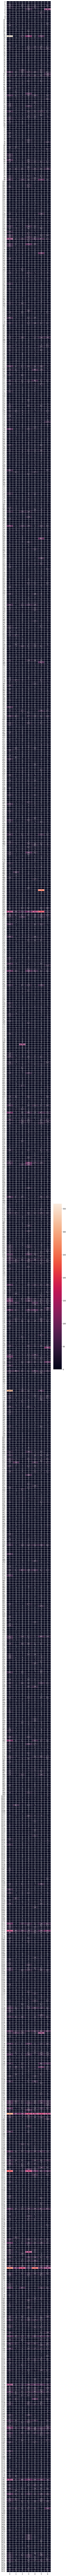

In [ ]:
matrix=np.zeros((len(dataset[0].x[0]),7))
for element,label in zip(dataset[0].x,dataset[0].y):
    for feature,index in zip(element,range(0,len(element))):
        matrix[index][label]=matrix[index][label]+feature

matrice=matrix
#matrix[matrix==0.0]=np.nan
plt.figure(figsize = (6,0.2*len(matrice)))
sns.heatmap(matrice, annot=True, linewidths=.5)
plt.show()

## Grafico a barre del della frequenza delle feature rispetto ai documenti

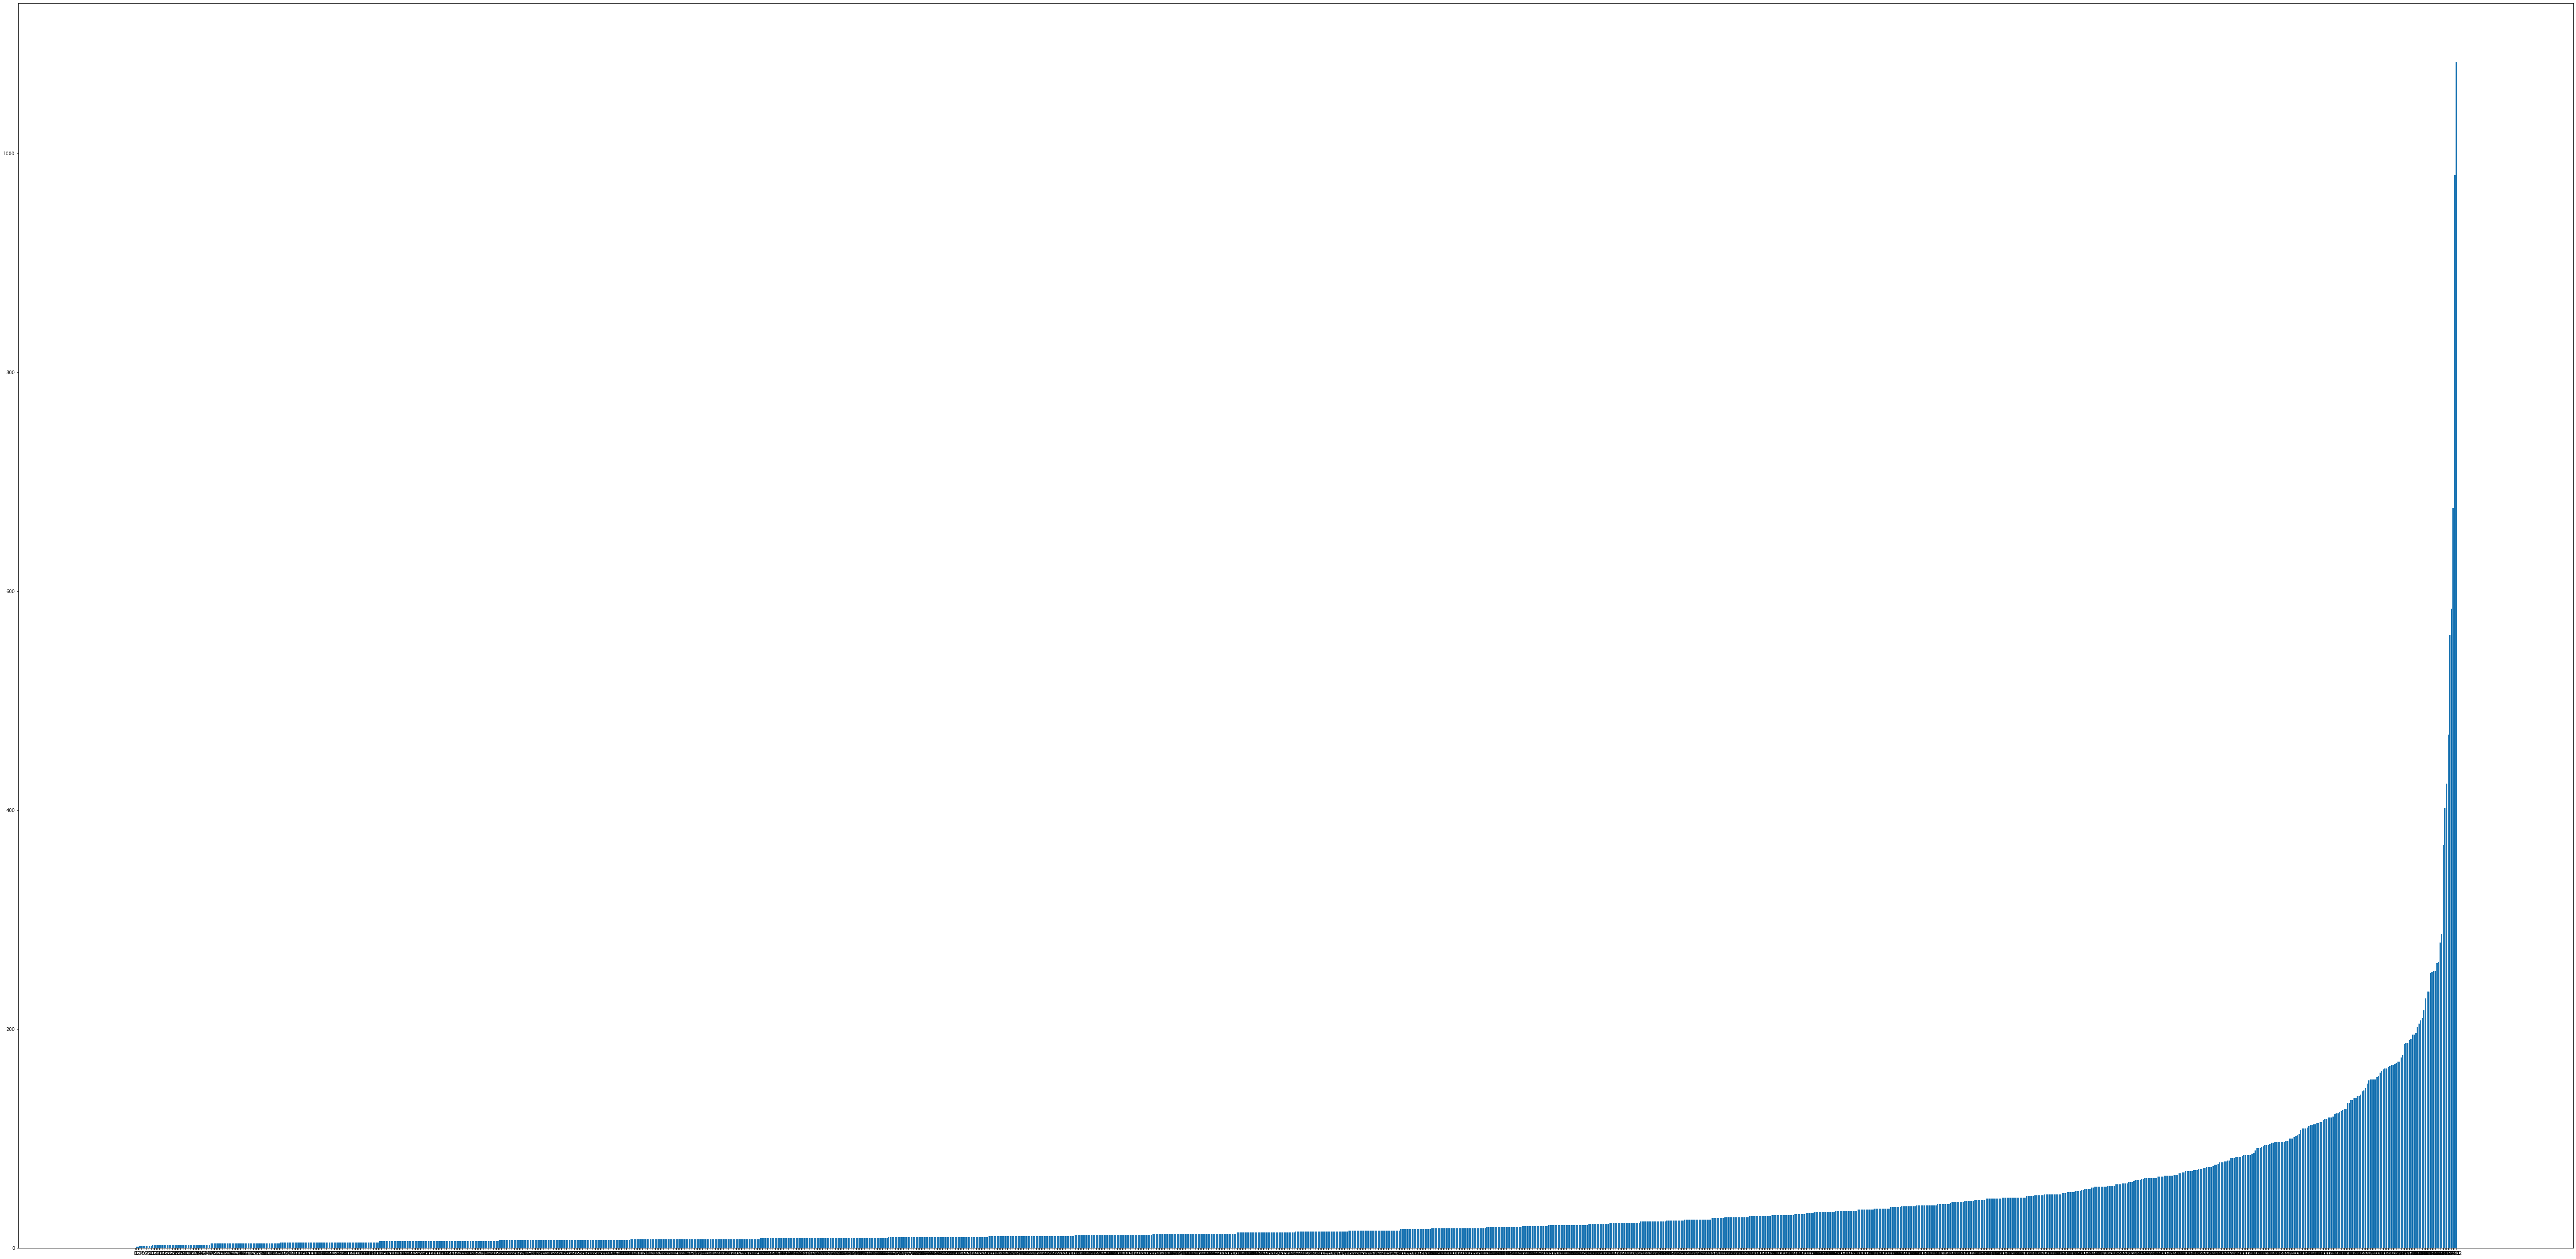

occorrenza massima:  1083.0
occorrenza minima:   0.0
occorenza media:     34.34473133286811


In [ ]:

plt.figure(figsize = (100, 50))
plt.bar(range(len(word_count)), sorted(list(word_count.values())), align='center')
plt.xticks(range(len(word_count)), list(word_count.keys()))
plt.show()
def avg(lst):
    return sum(lst) / len(lst)
print("occorrenza massima: ",max(list(word_count.values())))
print("occorrenza minima:  ",min(list(word_count.values())))
print("occorenza media:    ",avg(list(word_count.values())))

## Numero di documenti per etichetta

### Numero di documenti per etichetta su tutto il dataset

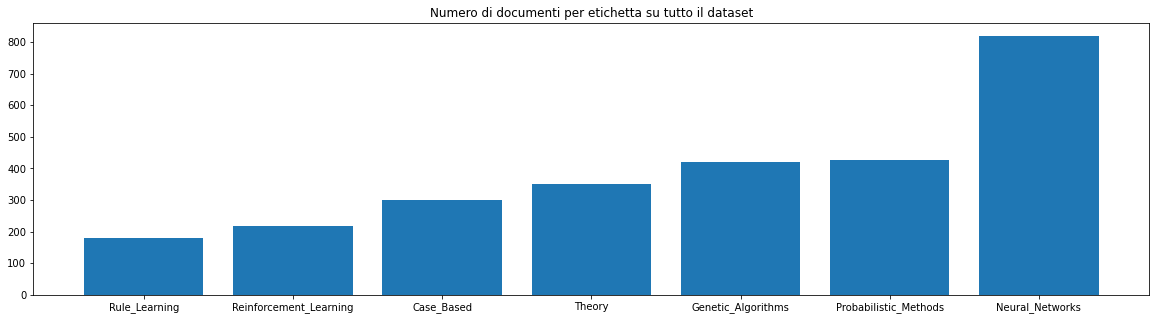

In [ ]:
labels_count=dataset[0].labels_count
Z = [x for _,x in sorted(zip(list(labels_count.values()),list(labels_count.keys())))]
plt.figure(figsize = (20, 5))
plt.bar(range(len(labels_count)), sorted(list(labels_count.values())), align='center')
plt.xticks(range(len(labels_count)),Z)
plt.title('Numero di documenti per etichetta su tutto il dataset')
plt.show()

### Numero di documenti per etichetta sul training set

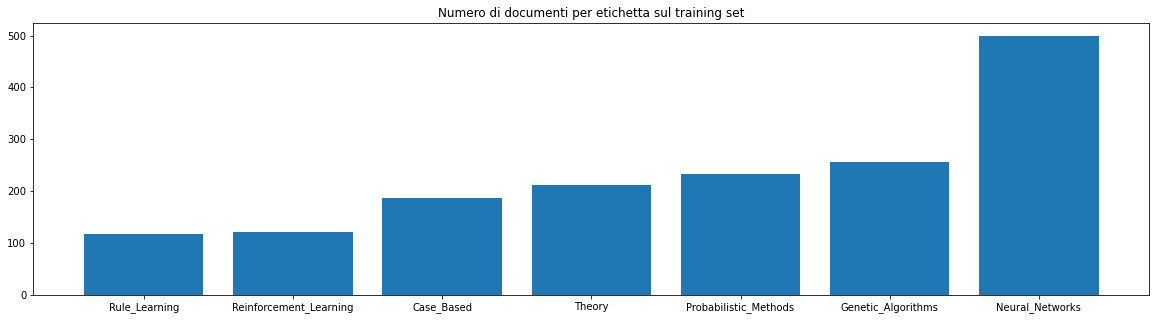

In [ ]:
label_map=inv_map = {dataset.data.label_map[k] : k for k in dataset.data.label_map}
labels_count=dataset[0].labels_count
for x in labels_count.keys():
    labels_count[x]=0
for label in train_y:
    labels_count[label_map[int(label)]]+=1
Z = [x for _,x in sorted(zip(list(labels_count.values()),list(labels_count.keys())))]
plt.figure(figsize = (20, 5))
plt.bar(range(len(labels_count)), sorted(list(labels_count.values())), align='center')
plt.xticks(range(len(labels_count)),Z)
plt.title('Numero di documenti per etichetta sul training set')
plt.show()

### Numero di documenti per etichetta sul test set

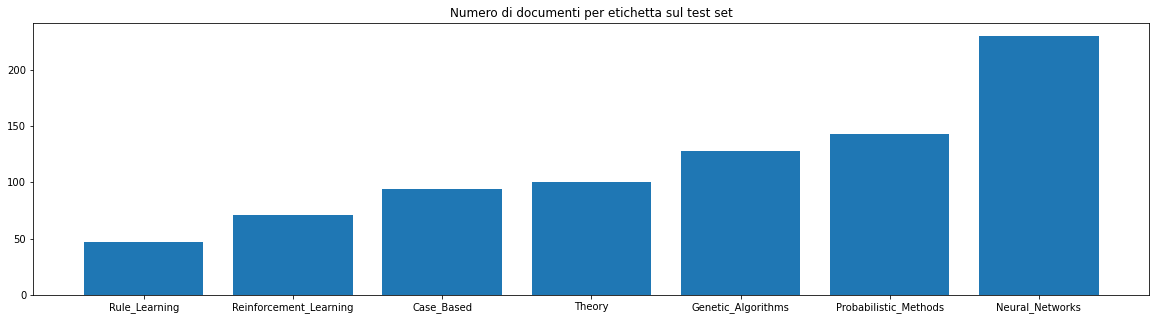

In [ ]:
labels_count=dataset[0].labels_count
for x in labels_count.keys():
    labels_count[x]=0
for label in test_y:
    labels_count[label_map[int(label)]]+=1
Z = [x for _,x in sorted(zip(list(labels_count.values()),list(labels_count.keys())))]
plt.figure(figsize = (20, 5))
plt.bar(range(len(labels_count)), sorted(list(labels_count.values())), align='center')
plt.xticks(range(len(labels_count)),Z)
plt.title('Numero di documenti per etichetta sul test set')
plt.show()

## Plot dei punti delle feature del trainig set con colorazione rispetto alla label (TSNE)
Con tecnica di riduzione t-distributed stochastic neighbor embedding (TSNE)

Colore associato alla label: 0 -> Neural_Networks -> red 
Colore associato alla label: 1 -> Rule_Learning -> orange 
Colore associato alla label: 2 -> Reinforcement_Learning -> green 
Colore associato alla label: 3 -> Probabilistic_Methods -> blue 
Colore associato alla label: 4 -> Theory -> purple 
Colore associato alla label: 5 -> Genetic_Algorithms -> brown 
Colore associato alla label: 6 -> Case_Based -> fuchsia 


C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


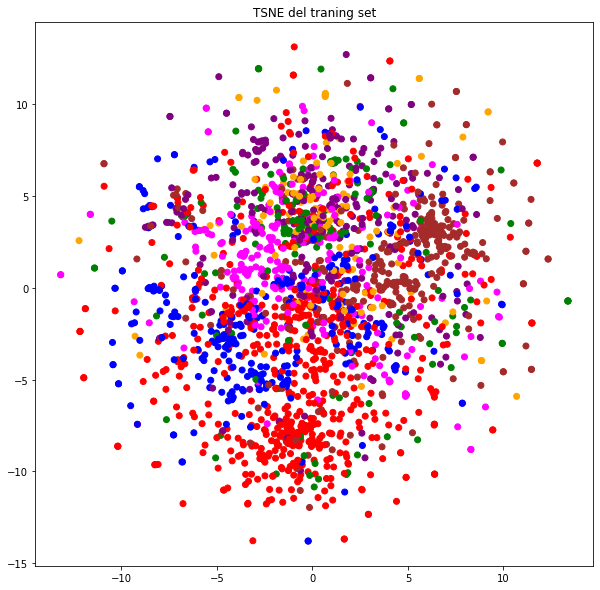

In [ ]:
color_list = ["red", "orange", "green", "blue", "purple", "brown","fuchsia"]
colors_train = []
colors_train +=  [color_list[y] for y in dataset[0].y[dataset[0].train_mask]]
for x in label_map.keys():
    print(f"Colore associato alla label: {x} -> {label_map[x]} -> {color_list[x]} "   )

xs_tsne, ys_tsne = zip(*TSNE(learning_rate='auto',init='pca').fit_transform(dataset[0].x))
xs_tsne= torch.Tensor(xs_tsne)
ys_tsne= torch.Tensor(ys_tsne)

xs_tsne_train = xs_tsne[dataset[0].train_mask]
ys_tsne_train = ys_tsne[dataset[0].train_mask]
plt.figure(figsize = (10, 10))
plt.title("TSNE del traning set")
plt.scatter(xs_tsne_train, ys_tsne_train, color=colors_train)

## Plot dei punti delle feature del trainig set con colorazione rispetto alla label (PCA)
Con tecnica di riduzione Principal component analysis (PCA)

Colore associato alla label: 0 -> Neural_Networks -> red 
Colore associato alla label: 1 -> Rule_Learning -> orange 
Colore associato alla label: 2 -> Reinforcement_Learning -> green 
Colore associato alla label: 3 -> Probabilistic_Methods -> blue 
Colore associato alla label: 4 -> Theory -> purple 
Colore associato alla label: 5 -> Genetic_Algorithms -> brown 
Colore associato alla label: 6 -> Case_Based -> fuchsia 


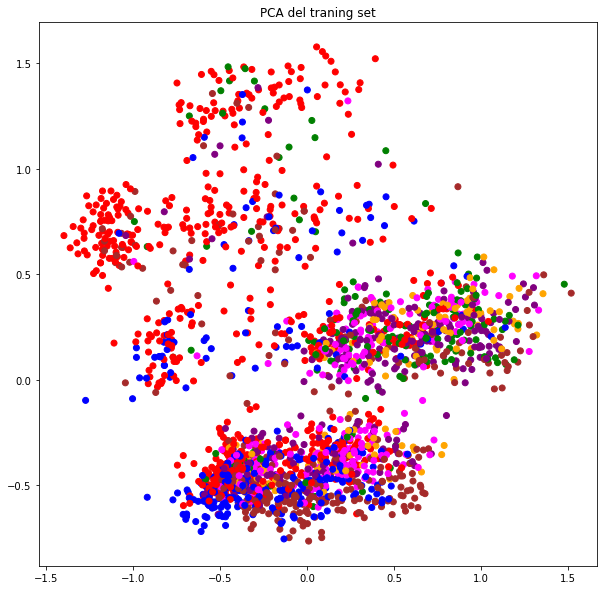

In [ ]:
for x in label_map.keys():
    print(f"Colore associato alla label: {x} -> {label_map[x]} -> {color_list[x]} "   )

pca = PCA(n_components=2)
principalComponents = pca.fit_transform( dataset[0].x)
xs_pca,ys_pca=zip(*principalComponents)
xs_pca= torch.Tensor(xs_pca)
ys_pca= torch.Tensor(ys_pca)
xs_pca_train = xs_pca[dataset[0].train_mask]
ys_pca_train = ys_pca[dataset[0].train_mask]

plt.figure(figsize = (10, 10))
plt.title("PCA del traning set")
plt.scatter(xs_pca_train, ys_pca_train, color=colors_train)



## Plot dei punti delle feature del test set con colorazione rispetto alla label (TSNE)
Con tecnica di riduzione t-distributed stochastic neighbor embedding (TSNE)

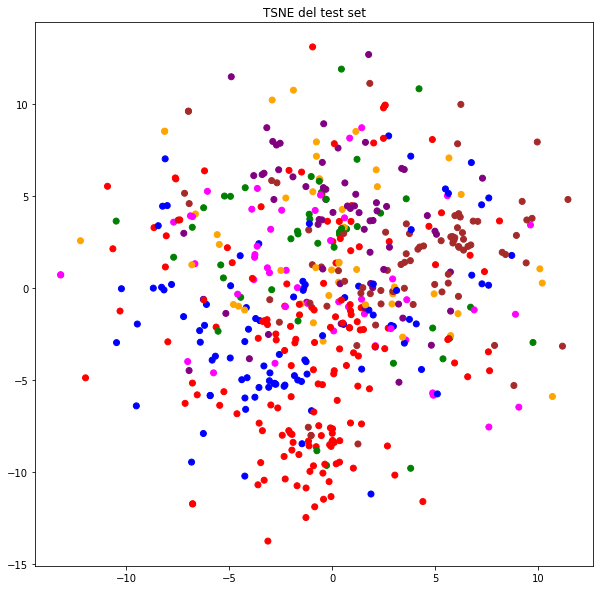

In [ ]:
colors_test=[]
colors_test +=  [color_list[y] for y in test_y]
xs_tsne_test=xs_tsne[dataset[0].test_mask]
ys_tsne_test=ys_tsne[dataset[0].test_mask]
plt.figure(figsize = (10, 10))
plt.title("TSNE del test set")
plt.scatter(xs_tsne_test, ys_tsne_test, color=colors_test)



## Plot dei punti delle feature del test set con colorazione rispetto alla label (PCA)
Con tecnica di riduzione Principal component analysis (PCA)

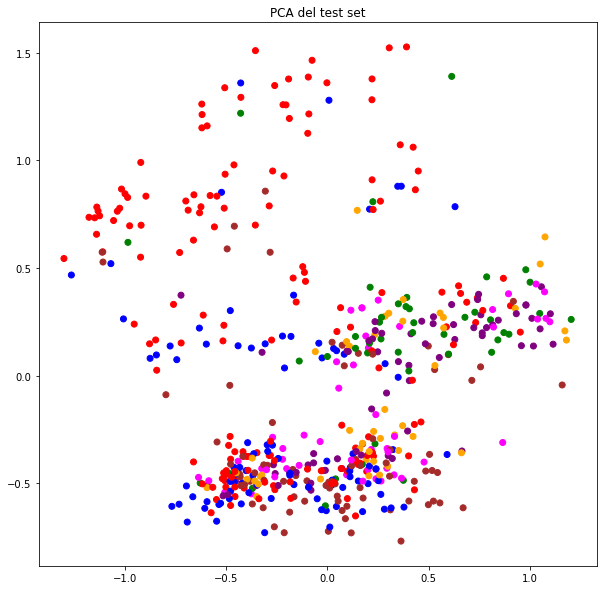

In [ ]:
xs_pca_test=xs_pca[dataset[0].test_mask]
ys_pca_test=ys_pca[dataset[0].test_mask]
plt.figure(figsize = (10, 10))
plt.title("PCA del test set")
plt.scatter(xs_pca_test, ys_pca_test, color=colors_test)

## Plot degli autovalori del dataset

C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


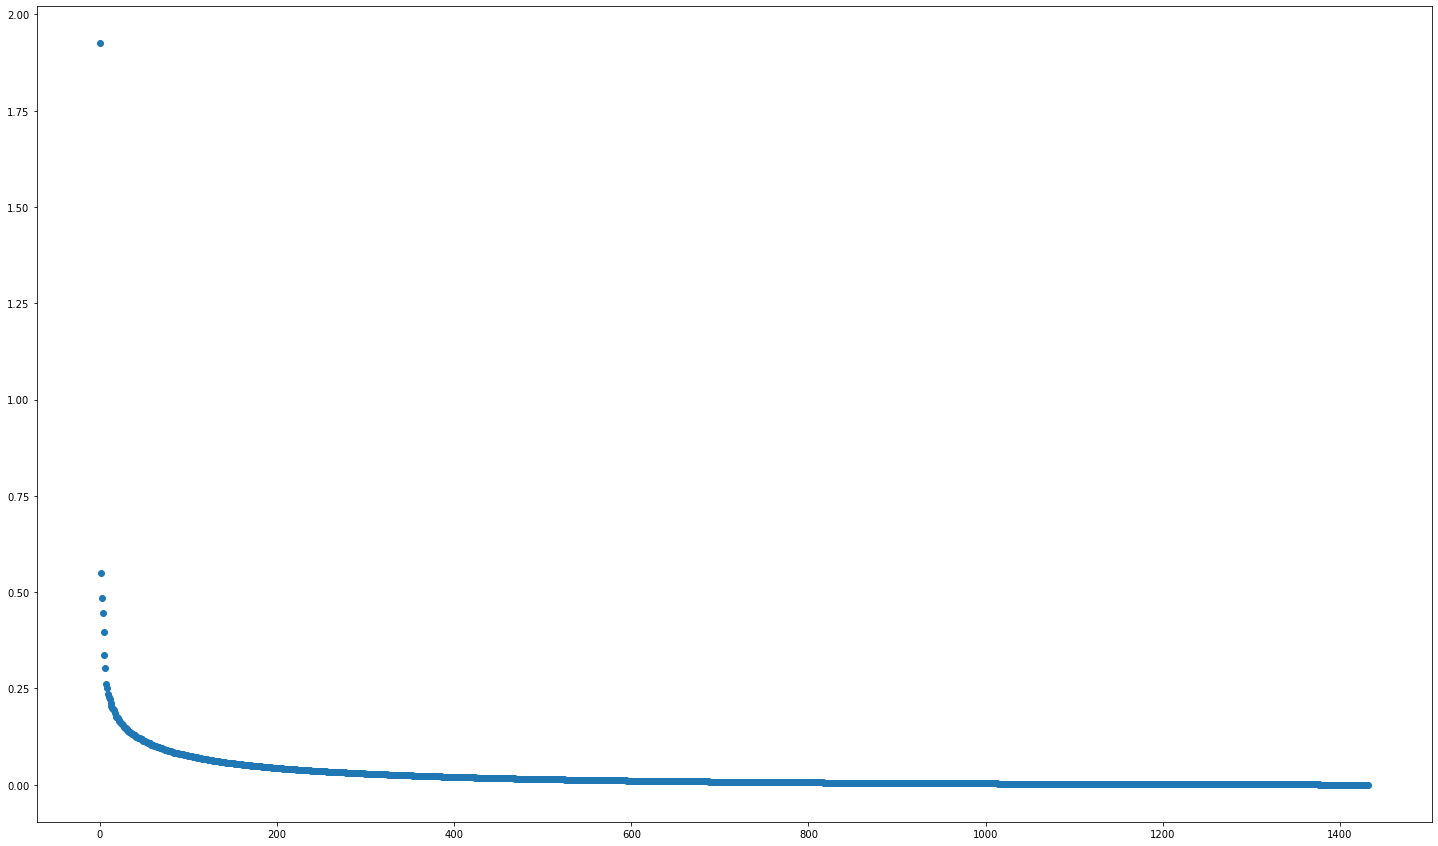

In [4]:
matr=dataset[0].x.cpu().detach().numpy()
autovalori=np.linalg.eigvals(np.cov(matr))
xpoints = list(range(0,len(autovalori)))
ypoints = sorted(autovalori ,reverse=True)
plt.figure(figsize = (25, 15))
plt.plot(xpoints[:1433], ypoints[:1433], 'o')
plt.show()

## Alcune statistiche sul grafo

visualizzazzione del grafo interattiva online
https://nocodefunctions.com/html/vosviewer/index.html?json=data/public/vosviewer_de6bf2c77e0fa2c0e672.json

Network density formula: $d= \frac{2m}{n(n-1)}$ 

Triadic closure coefficient :  $T=3\frac{ |triangoli| }{|triadi|}$ \
dove per triade si intende 2 archi che condividono un nodo 

In [18]:


node_atr=[0,1,2,3,4,5,6]

G=torch_geometric.utils.convert.to_networkx(dataset[0],node_attrs=['y'],to_undirected=True)
density = nx.density(G)
print("Network density:", density)
triadic_closure = nx.transitivity(G)
print("Triadic closure:", triadic_closure)
nx.write_gexf(G, 'quaker_network.gexf')
print("Average Degree: ",2*G.number_of_edges() / float(G.number_of_nodes()))
diameter = max([max(j.values()) for (i,j) in nx.shortest_path_length(G)])
print("Diameter: ", diameter)
print(nx.info(G))

Network density: 0.0014399999126942077
Triadic closure: 0.09349725626661058
Average Degree:  3.8980797636632203
Diameter:  19
Graph with 2708 nodes and 5278 edges


![title](https://raw.githubusercontent.com/naddi96/progetto-ML/master/grafo.png)

# Metriche Utilizzate per valutare i modelli

1. Accuracy: $\frac{|esempi \space classificati  \space correttamente|}{|totale \space di \space esempi|}$


2. Macro f1:  $  \frac{1}{|C|}\sum_{i=0}^{|C|} f1score_i$   

$f1score_i= \frac{2 P_i R_i}{P_i+R_i}$ 

dove $P_i$ e $R_i$ sono rispettivamente precision e recall della classe $i$ 

1. Confusion Matrix


# Logistic regression

La regressione logistica è una tecnica di classificazione utilizzata per assegnare osservazioni a un insieme discreto di classi.

A differenza della regressione lineare che restituisce valori numerici continui, la regressione logistica trasforma il proprio output utilizzando la funzione sigmoide o  softmax per restituire un valore di probabilità che può quindi essere mappato a due o più classi discrete.


partiamo dal modello di regressione semplice 

$z^{k}=b+ W^t x^{(k)}$

vi applichiamo la softmax 

$y^{(k)}_i=softmax_i(b+W^t x^{(k)})=\frac{e^{z_i}}{\sum_{j=1}^K{e^{z_j}}}$

dove  $y^{(k)}_i$ è la probabilità predetta della k-esima osservazione con di essere della iesima classe

indiachiamo con indichiamo con $\hat{y}=softmax(z_i)$ il vettore delle probabilità predetto, la funzione di costo nel caso multinomiale ha questa forma 

$L= -  \sum_{j=0}^{K}l_j log(\hat{y}_j)$

dove $l$ è il vettore one hot della label target



C è il parametro di regolazizzazione inversa quindi valori più piccoli indicano una regolazizzazione più marcata

solver che sono stati utilizati sono i segienti
- **Newton’s Method** data una funzione $f : R \rightarrow R$
  
   l'algoritmo trova una radice $z \in R $ di f tale che $f(z)=0$ tramite una sequenza di iterazioni che partono da un valore base e che utiliziano questa regola di update:
   
   $z_{i+1}= z_i-\frac{f(z_i)}{f'(z_i)}$
   
   ad ogni iterazione l'algoritmo approssima la retta tangente a f nel punto $(z_i,f(z_i))$ e definisce il nuovo valore $z_{i+1}$ come il valore in cui la retta interseca l'asse delle x 
- **Broyden–Fletcher–Goldfarb–Shanno** in poche parole è simile al metodo precedente con la differenza che la matrice Hessiana viene approssimata usando stime iterative 

- **liblinear** Utilizza un algoritmo di coordinate descent.  coordinate descent si basa sulla minimizzazione di una funzione multivariata risolvendo problemi di ottimizzazione univariata in nelle singole dimensioni. Quindi, si muove verso il minimo considerando una direzione alla volta.

- **Stochastic Average Gradient descent** Una variante di gradient descent che usa un random sampling per i precedenti valori del gradiente 





In [39]:

pipe = Pipeline([("reduce_dim", "passthrough"),
                 ('logisticregression', LogisticRegression())])

parametri=  [
                {  
                    "reduce_dim": [PCA()],
                    "reduce_dim__n_components":[64,128,256,512,1024],
                    "logisticregression__penalty":['l1', 'l2', 'none'],
                    "logisticregression__solver":['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                    "logisticregression__C": [0.1,0.5,1,10,50,100]
                },
                {
                    "reduce_dim": ["passthrough"],
                    "logisticregression__penalty":['l1', 'l2', 'none'],
                    "logisticregression__solver":['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                    "logisticregression__C": [0.1,0.5,1,10,50,100]
                }
            ]
        

grid = GridSearchCV(pipe, n_jobs=-1, param_grid=parametri,cv=5,scoring='f1_macro',return_train_score=True)
grid.fit(train_x,train_y)

print("tuned hpyerparameters :(best parameters) ",grid.best_params_)

C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
1620 fits failed out of a total of 3600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in f

tuned hpyerparameters :(best parameters)  {'logisticregression__C': 0.5, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear', 'reduce_dim': PCA(n_components=1024), 'reduce_dim__n_components': 1024}


best parameters: {'logisticregression__C': 0.5, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear', 'reduce_dim': PCA(n_components=1024), 'reduce_dim__n_components': 1024}
best score:      0.73952 (+/-0.02320)


param_logisticregression__C param_logisticregression__penalty  \
139                         0.5                                l2   
627                         0.5                                l2   
626                         0.5                                l2   
625                         0.5                                l2   
628                         0.5                                l2   
629                         0.5                                l2   
134                         0.5                                l2   
234                           1                                l2   
129                         0.5                                l2   
149                         0.5                                l2   
144                         0.5                                l2   
138                         0.5                                l2   
249                           1                                l2   
244                           1                                l2   
239                           1                                l2   
229                           1                                l2   
148                         0.5                                l2   
645                           1                                l2   
646                           1                                l2   
649                           1                                l2   
648                           1                                l2   
228                           1                                l2   
238                           1                                l2   
243                           1                                l2   
647                           1                                l2   
128                         0.5                                l2   
143                         0.5                                l2   
133                         0.5                                l2   
644                           1                                l1   
248                           1                                l2   
642                           1                                l1   
38                          0.1                                l2   
233                           1                                l2   
339                          10                                l2   
667                          10                                l2   
624                         0.5                                l1   
237                           1                                l2   
137                         0.5                                l2   
29                          0.1                                l2   
142                         0.5                                l2   

    param_logisticregression__solver param_reduce_dim__n_components  \
139                        liblinear                           1024   
627                        liblinear                            NaN   
626                            lbfgs                            NaN   
625                        newton-cg                            NaN   
628                              sag                            NaN   
629                             saga                            NaN   
134                            lbfgs                           1024   
234                            lbfgs                           1024   
129                        newton-cg                           1024   
149                             saga                           1024   
144                              sag                           1024   
138                        liblinear                            512   
249                             saga                           1024   
244                              sag                           1024   
239                        liblinear                           1024   
229                        newton-cg  

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_logisticregression__C', 'param_logisticregression__penalty',
       'param_logisticregression__solver', 'param_reduce_dim',
       'param_reduce_dim__n_components', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'split0_train_score', 'split1_train_score',
       'split2_train_score', 'split3_train_score', 'split4_train_score',
       'mean_train_score', 'std_train_score'],
      dtype='object')


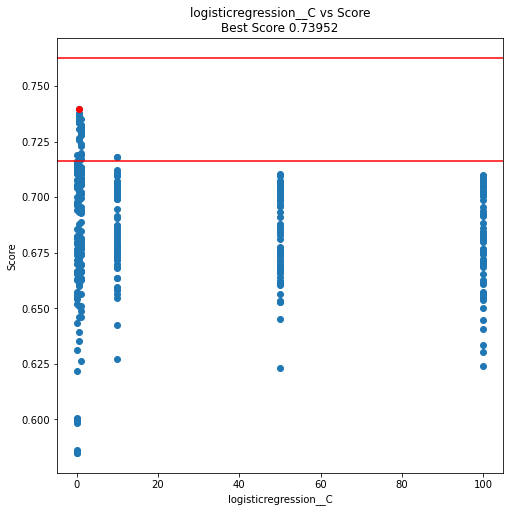

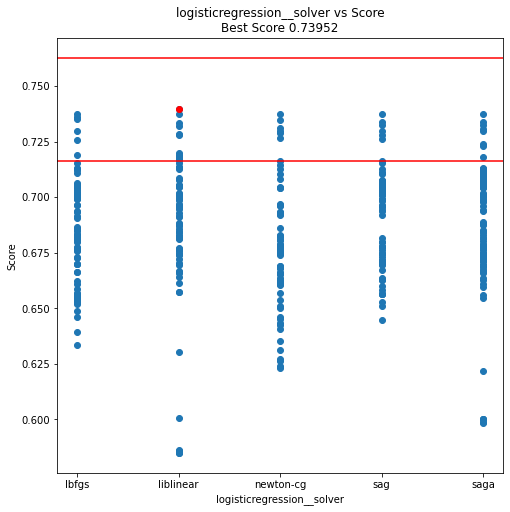

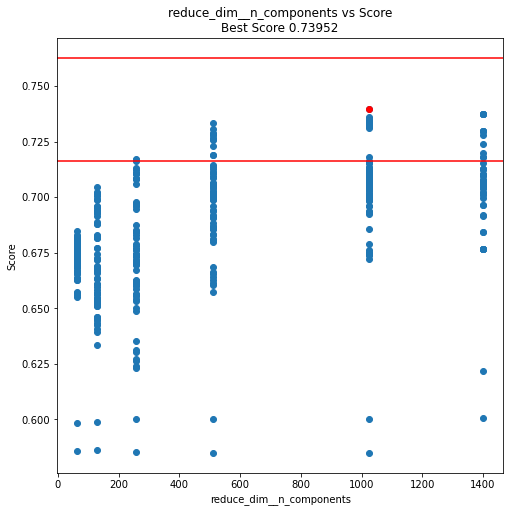

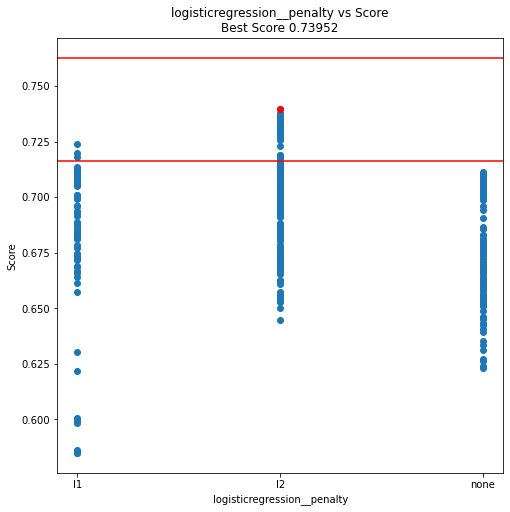

In [40]:


GridSearch_table_plot(grid, param_list=['logisticregression__C','logisticregression__solver',"reduce_dim__n_components","logisticregression__penalty"],negative=False)

In [41]:
print(grid.best_params_)
model=grid.best_estimator_
model.fit(train_x,train_y)
model = model.fit(train_x,train_y)
y_pred = model.predict(test_x)
test_valutation=valutate_test(test_y,y_pred)
dict_valutazioni['LogisticRegression']={"test":test_valutation}
print("Logostic Regression")
print( f"Accuracy: {test_valutation['Accuracy']}")
print( f"Macro f1: {test_valutation['f1']}")
print(f"Confusion Matrix:\n {test_valutation['Confusion Matrix']}")


{'logisticregression__C': 0.5, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear', 'reduce_dim': PCA(n_components=1024), 'reduce_dim__n_components': 1024}
Logostic Regression
Accuracy: 0.7541589648798521
Macro f1: 0.7295343766146508
Confusion Matrix:
 [[134   3   0   7  10   3   2]
 [  6  23   1   4   6   3   3]
 [  8   0  29   2   3   1   1]
 [ 14   1   1  70   2   1   4]
 [  4   1   1   3  50   2   4]
 [  7   0   1   1   2  70   2]
 [  5   1   0   3   8   2  32]]


# Linear Discriminant Analysis
Il modello calcola le probablitià condizionali delle classi dei dati utilizzando la regola di Bayes,

$p(y=k|x) = \frac{P(x|y=k) P(y=k)}{\sum_l P(x|y=l)P(y=l) } $

Il modello effettua fitting rispetto alla densità Gaussiana in ogni classe ed assume che tutte le classi hanno la stessa matrice di covarianza, ossia

$P(x|y=k)$ è modellata con una distribuzione gaussiana:

e quindi avremo la log-posteriori avrà questa forma

$log P(y=k|x) = log P(x|y=k)+ logP(y=k) =$ 
 
$-\frac{1}{2}(x-\mu_k)^t \Sigma^{-1} (x-\mu_k)+log P(y=k) + C_{st}$ 

notiamo che $\Sigma$ è uguale per tutte le classi 




In [42]:
pipe = Pipeline([("reduce_dim", "passthrough"),
                 ('LinearDiscriminantAnalysis',LinearDiscriminantAnalysis(store_covariance=True))])

parametri=  [
                {  
                    "reduce_dim": [PCA()],
                    "reduce_dim__n_components":[64,128,256,512,1024],
                    "LinearDiscriminantAnalysis__solver":['svd', 'lsqr', 'eigen'],
                   
                },
                {
                    "reduce_dim": ["passthrough"],
                    "LinearDiscriminantAnalysis__solver":['svd', 'lsqr', 'eigen'],
                }
            ]
        

grid = GridSearchCV(pipe, n_jobs=-1, param_grid=parametri,cv=5,scoring='f1_macro',return_train_score=True)
grid.fit(train_x,train_y)

print("tuned hpyerparameters :(best parameters) ",grid.best_params_)

C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\discriminant_analysis.py", line 599, in fit
    se

tuned hpyerparameters :(best parameters)  {'LinearDiscriminantAnalysis__solver': 'eigen', 'reduce_dim': PCA(n_components=256), 'reduce_dim__n_components': 256}


best parameters: {'LinearDiscriminantAnalysis__solver': 'eigen', 'reduce_dim': PCA(n_components=256), 'reduce_dim__n_components': 256}
best score:      0.72377 (+/-0.03667)


param_LinearDiscriminantAnalysis__solver param_reduce_dim__n_components  \
12                                    eigen                            256   
8                                      lsqr                            512   
2                                       svd                            256   
7                                      lsqr                            256   
13                                    eigen                            512   
3                                       svd                            512   
11                                    eigen                            128   
1                                       svd                            128   
6                                      lsqr                            128   
5                                      lsqr                             64   
10                                    eigen                             64   
0                                       svd                             64   
4                                       svd                           1024   
14                                    eigen                           1024   
9                                      lsqr                           1024   
15                                      svd                            NaN   
16                                     lsqr                            NaN   
17                                    eigen                            NaN   

    mean_test_score  std_test_score  rank_test_score  mean_train_score  \
12         0.723768        0.036670                1          0.834523   
8          0.717539        0.031913                2          0.913347   
2          0.717444        0.036833                3          0.834712   
7          0.715098        0.037178                4          0.836939   
13         0.713394        0.032135                5          0.914953   
3          0.712449        0.027135                6          0.915341   
11         0.702872        0.038085                7          0.778533   
1          0.697998        0.038148                8          0.780095   
6          0.694357        0.045467                9          0.780503   
5          0.677102        0.050598               10          0.729022   
10         0.673363        0.048791               11          0.726447   
0          0.669835        0.052465               12          0.730271   
4          0.669241        0.030359               13          0.975004   
14         0.669178        0.035398               14          0.975199   
9          0.668067        0.026937               15          0.975674   
15         0.426305        0.033417               16          0.993777   
16         0.425983        0.033631               17          0.993777   
17              NaN             NaN               18               NaN   

    std_train_score  
12         0.002895  
8          0.004605  
2          0.004577  
7          0.002271  
13         0.002585  
3          0.003044  
11         0.005406  
1          0.005034  
6          0.006069  
5          0.008220  
10         0.004383  
0          0.006894  
4          0.003037  
14         0.002470  
9          0.002174  
15         0.000782  
16         0.000782  
17              NaN

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_LinearDiscriminantAnalysis__solver', 'param_reduce_dim',
       'param_reduce_dim__n_components', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'split0_train_score', 'split1_train_score',
       'split2_train_score', 'split3_train_score', 'split4_train_score',
       'mean_train_score', 'std_train_score'],
      dtype='object')


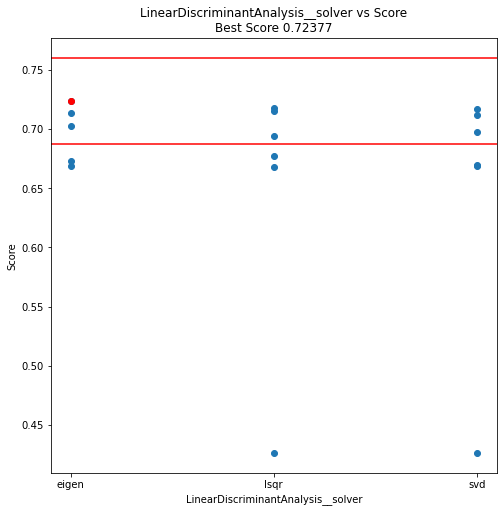

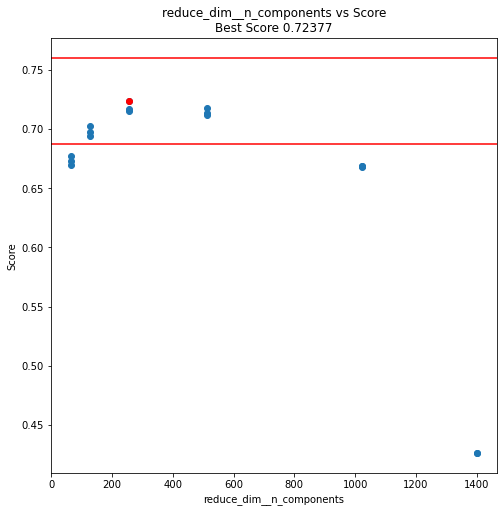

In [43]:
GridSearch_table_plot(grid, param_list=['LinearDiscriminantAnalysis__solver',"reduce_dim__n_components"],negative=False)

In [44]:
print(grid.best_params_)
model=grid.best_estimator_
model.fit(train_x,train_y)
model = model.fit(train_x,train_y)
y_pred = model.predict(test_x)
test_valutation=valutate_test(test_y,y_pred)
dict_valutazioni['LinearDiscriminantAnalysis']={"test":test_valutation}
print("Linear Discriminant Analysis")
print( f"Accuracy: {test_valutation['Accuracy']}")
print( f"Macro f1: {test_valutation['f1']}")
print(f"Confusion Matrix:\n {test_valutation['Confusion Matrix']}")



{'LinearDiscriminantAnalysis__solver': 'eigen', 'reduce_dim': PCA(n_components=256), 'reduce_dim__n_components': 256}
Linear Discriminant Analysis
Accuracy: 0.7208872458410351
Macro f1: 0.7024394799735906
Confusion Matrix:
 [[135   3   0   5  14   1   1]
 [  8  26   0   1   7   1   3]
 [  9   0  25   4   4   2   0]
 [ 18   2   1  66   3   0   3]
 [  9   2   0   3  47   0   4]
 [ 14   0   0   1   2  63   3]
 [  8   2   0   2  11   0  28]]


# Quadratic Discriminant Analysis
La Quadratic Discriminant Analysis non è molto diversa dalla Linear, eccetto per il fatto che assumiamo che la matrice di covarianza possa essere diversa per ogni classe e quindi abbiamo la matrice di covarianza diversa per ogni classe e avremo la seguente log-posteriori

$logP(y=k|x) = -\frac{1}{2} log|\Sigma_k| -\frac{1}{2} (x-\mu_k)^t \Sigma_k^{-1} (x-\mu_k)+ logP(y=k) + C_{st}$

notiamo come nella formulazione abbiamo una matrice di covariariaza divera per ogni classe




In [45]:
pipe = Pipeline([("reduce_dim", "passthrough"),
                 ('LinearDiscriminantAnalysis',QuadraticDiscriminantAnalysis(store_covariance=True))])

parametri=  [
                {  
                    "reduce_dim": [PCA()],
                    "reduce_dim__n_components":[64,128,256,512,1024],
                },
                {
                    "reduce_dim": ["passthrough"],
                    
                }
            ]
        

grid = GridSearchCV(pipe, n_jobs=-1, param_grid=parametri,cv=5,scoring='f1_macro',return_train_score=True)
grid.fit(train_x,train_y)

print("tuned hpyerparameters :(best parameters) ",grid.best_params_)

tuned hpyerparameters :(best parameters)  {'reduce_dim': PCA(n_components=64), 'reduce_dim__n_components': 64}


best parameters: {'reduce_dim': PCA(n_components=64), 'reduce_dim__n_components': 64}
best score:      0.57832 (+/-0.03103)


param_reduce_dim__n_components  mean_test_score  std_test_score  \
0                             64         0.578318        0.031030   
1                            128         0.438354        0.029331   
4                           1024         0.172264        0.012897   
2                            256         0.083101        0.008734   
3                            512         0.066626        0.000142   
5                            NaN         0.055936        0.016121   

   rank_test_score  mean_train_score  std_train_score  
0                1          0.912426         0.004336  
1                2          0.809561         0.001390  
4                3          0.990619         0.002635  
2                4          0.372595         0.000230  
3                5          0.066626         0.000035  
5                6          0.188027         0.048976

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_reduce_dim', 'param_reduce_dim__n_components', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'split3_train_score',
       'split4_train_score', 'mean_train_score', 'std_train_score'],
      dtype='object')


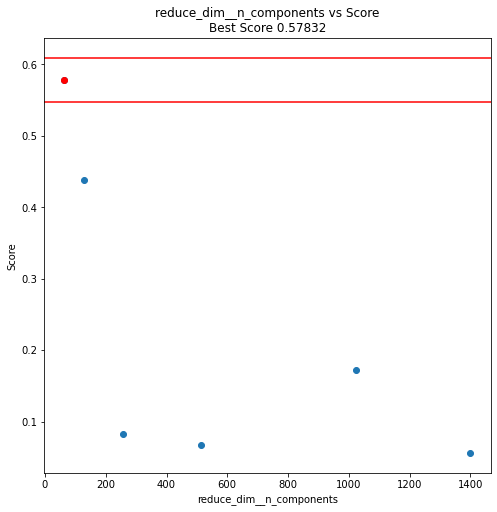

In [46]:
GridSearch_table_plot(grid, param_list=["reduce_dim__n_components"],negative=False)

In [47]:
print(grid.best_params_)
model=grid.best_estimator_
model.fit(train_x,train_y)
model = model.fit(train_x,train_y)
y_pred = model.predict(test_x)
test_valutation=valutate_test(test_y,y_pred)
dict_valutazioni['QuadraticDiscriminantAnalysis']={"test":test_valutation}
print("Quadratic Discriminant Analysis")
print( f"Accuracy: {test_valutation['Accuracy']}")
print( f"Macro f1: {test_valutation['f1']}")
print(f"Confusion Matrix:\n {test_valutation['Confusion Matrix']}")



{'reduce_dim': PCA(n_components=64), 'reduce_dim__n_components': 64}
Quadratic Discriminant Analysis
Accuracy: 0.6432532347504621
Macro f1: 0.5948183681784084
Confusion Matrix:
 [[115   5   1  14  17   5   2]
 [  5  12   0   4   9  11   5]
 [  8   1  21   3   1   6   4]
 [ 18   1   0  64   4   2   4]
 [  8   7   1   4  38   6   1]
 [  2   1   2   1   1  71   5]
 [  7   3   0   5   7   2  27]]


# K Neighbors Classifier

L'idea dietro kNN è la seguente: si considerano tutti gli elementi del training set e consideriamo i  elementi più vicini all'elemento che vogliamo classificare. 

La classificazione viene fatta assegnando il nuovo elemento alla classe che compare più frequentemente all'interno di questi  elementi.

il parametro weights che può essere 'uniform' o 'distance':
- **uniform**  Tutti i punti nel vicinato sono pesati allo stesso modo
- **distance**  i punti sono pesati per l'inverso della loro distanza. in questo caso, i vicini più vicini al punto di query avranno un'influenza maggiore rispetto ai "vicini" più lontani.

il parametro p è la potenza da usare quando si calcola la distanza di  minkowski tra due punti

$(\sum_{i=1}^n |x_i-y_i|^p ) ^\frac{1}{p}$


In [48]:
pipe = Pipeline([("reduce_dim", "passthrough"),
                 ('KNeighborsClassifier', KNeighborsClassifier())])

parametri=  [
                {  
                    "reduce_dim": [PCA()],
                    "reduce_dim__n_components":[64,128,256,512,1024],
                    "KNeighborsClassifier__weights":['uniform', 'distance'],
                    "KNeighborsClassifier__n_neighbors":[1,3,5,10,20],
                    "KNeighborsClassifier__p":[0.5, 1,2,4,8,50,100]
                },
                {
                    "reduce_dim": ["passthrough"],
                    "KNeighborsClassifier__weights":['uniform', 'distance'],
                    "KNeighborsClassifier__n_neighbors":[1,3,5,10,20],
                    "KNeighborsClassifier__p":[0.5, 1,2,4,8,50,100]
                    
                }
            ]
        

grid = GridSearchCV(pipe, n_jobs=-1, param_grid=parametri,cv=5,scoring='f1_macro',return_train_score=True)
grid.fit(train_x,train_y)

print("tuned hpyerparameters :(best parameters) ",grid.best_params_)

tuned hpyerparameters :(best parameters)  {'KNeighborsClassifier__n_neighbors': 10, 'KNeighborsClassifier__p': 2, 'KNeighborsClassifier__weights': 'distance', 'reduce_dim': PCA(n_components=64), 'reduce_dim__n_components': 64}


C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
300 fits failed out of a total of 2100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\neighbors\_classification.py", line 198, in 

best parameters: {'KNeighborsClassifier__n_neighbors': 10, 'KNeighborsClassifier__p': 2, 'KNeighborsClassifier__weights': 'distance', 'reduce_dim': PCA(n_components=64), 'reduce_dim__n_components': 64}
best score:      0.54576 (+/-0.01588)


param_KNeighborsClassifier__n_neighbors param_KNeighborsClassifier__p  \
235                                      10                             2   
245                                      10                             4   
165                                       5                             2   
175                                       5                             4   
160                                       5                             2   
225                                      10                             1   
305                                      20                             2   
315                                      20                             4   
155                                       5                             1   
240                                      10                             4   
95                                        3                             2   
256                                      10                             8   
230                                      10                             2   
255                                      10                             8   
325                                      20                             8   
310                                      20                             4   
176                                       5                             4   
246                                      10                             4   
259                                      10                             8   
300                                      20                             2   
258                                      10                             8   
170                                       5                             4   
257                                      10                             8   
251                                      10                             8   
326                                      20                             8   
320                                      20                             8   
105                                       3                             4   
345                                      20                           100   
275                                      10                           100   
100                                       3                             4   
250                                      10                             8   
90                                        3                             2   
150                                       5                             1   
185                                       5                             8   
85                                        3                             1   
186                                       5                             8   
220                                      10                             1   
316                                      20                             4   
327                                      20                             8   
335                                      20                            50   

    param_KNeighborsClassifier__weights param_reduce_dim__n_components  \
235                            distance                             64   
245                            distance                             64   
165                            distance                             64   
175                            distance                             64   
160                             uniform                             64   
225                            distance                             64   
305                            distance                             64   
315                            distance                             64   
155                            distance                             64   
240                             uniform                             64   
95                             d

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_KNeighborsClassifier__n_neighbors',
       'param_KNeighborsClassifier__p', 'param_KNeighborsClassifier__weights',
       'param_reduce_dim', 'param_reduce_dim__n_components', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'split3_train_score',
       'split4_train_score', 'mean_train_score', 'std_train_score'],
      dtype='object')


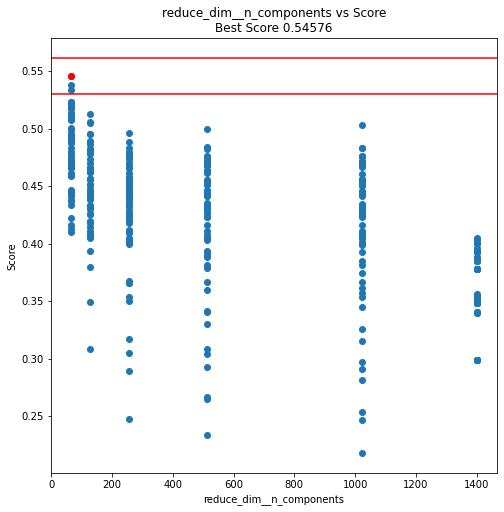

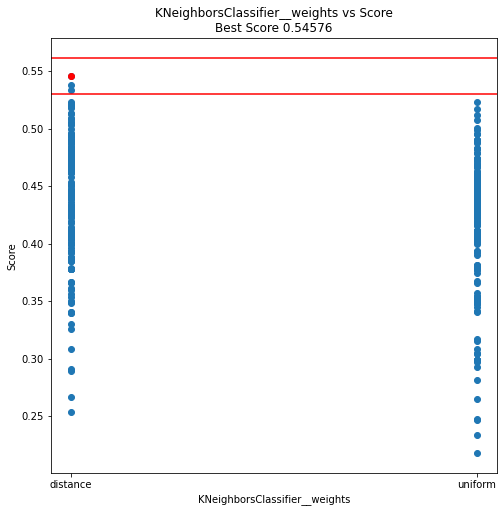

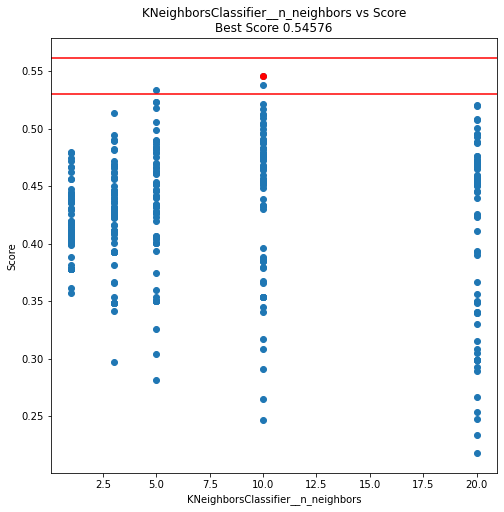

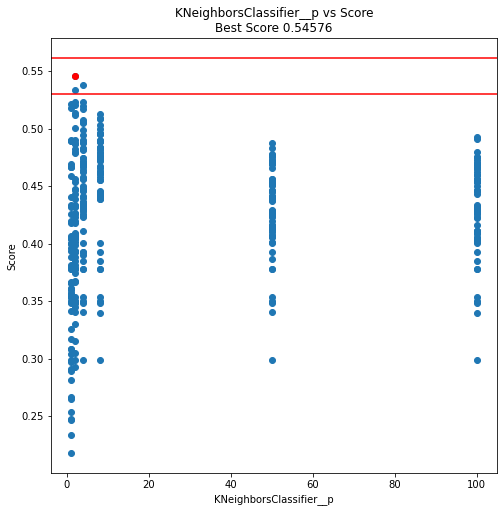

In [49]:
GridSearch_table_plot(grid, param_list=["reduce_dim__n_components","KNeighborsClassifier__weights","KNeighborsClassifier__n_neighbors","KNeighborsClassifier__p"],negative=False)

In [50]:
print(grid.best_params_)
model=grid.best_estimator_
model.fit(train_x,train_y)
model = model.fit(train_x,train_y)
y_pred = model.predict(test_x)
test_valutation=valutate_test(test_y,y_pred)
dict_valutazioni['KNeighborsClassifier']={"test":test_valutation}
print("K-Neighbors Classifier")
print( f"Accuracy: {test_valutation['Accuracy']}")
print( f"Macro f1: {test_valutation['f1']}")
print(f"Confusion Matrix:\n {test_valutation['Confusion Matrix']}")




{'KNeighborsClassifier__n_neighbors': 10, 'KNeighborsClassifier__p': 2, 'KNeighborsClassifier__weights': 'distance', 'reduce_dim': PCA(n_components=64), 'reduce_dim__n_components': 64}
K-Neighbors Classifier
Accuracy: 0.5914972273567468
Macro f1: 0.5586107912543066
Confusion Matrix:
 [[121   3   1  12  11   8   3]
 [ 17  12   1   6   5   4   1]
 [ 13   1  24   1   2   2   1]
 [ 28   0   0  59   2   1   3]
 [ 15   1   3  10  26   7   3]
 [ 21   0   1   0   5  56   0]
 [ 14   1   1   5   6   2  22]]


# Decision Tree Classifer

I decision Tree sono un metodo di apprendimento supervisionato non parametrico utilizzato per la classificazione e la regressione.
L'obiettivo è creare un modello che predice il valore di una variabile target apprendendo semplici regole decisionali dedotte dalle caratteristiche dei dati.

Gli alberi di decisione sono costruiti andando a partizionare in modo ricorsivo lo spazio delle features.

Supponiamo adesso di considerare un nodo e di volerlo partizionare.

L'idea è quella di andare a selezionare la feature e la soglia tali che una determinata misura è massimizzata nell'intersezione del training set con ognuna delle sottoregioni ottenute dalla partizione. Questa misura è una misura di impurità, e deve essere minimizzata.

la misura di impurità  gini index

$G_S=1-\sum_{i=1}^k (\frac{|S_i|}{|S|} )^2$

misura si impurità entropia

$H_s=-\sum^k_{i=1}\frac{|S_i|}{|S|}log_2 \frac{|S_i|}{|S|}$

dove $S$ è l'insieme del training set  $k$ è il numero di classi $S_i$ è l'insieme degli elementi della classe $i$



In [51]:
pipe = Pipeline([("reduce_dim", "passthrough"),
                 ('DecisionTreeClassifier', DecisionTreeClassifier())])

parametri=  [
                {  
                    "reduce_dim": [PCA()],
                    "reduce_dim__n_components":[64,128,256,512,1024],
                    "DecisionTreeClassifier__criterion":['gini','entropy'],
                    "DecisionTreeClassifier__max_depth":[4,8,16,32,64,128,256]

                },
                {
                    "reduce_dim": ["passthrough"],
                    "DecisionTreeClassifier__criterion":['gini','entropy'],
                    "DecisionTreeClassifier__max_depth":[4,8,16,32,64,128,256]
                    
                }
            ]
        

grid = GridSearchCV(pipe, n_jobs=-1, param_grid=parametri,cv=5,scoring='f1_macro',return_train_score=True)
grid.fit(train_x,train_y)

print("tuned hpyerparameters :(best parameters) ",grid.best_params_)

tuned hpyerparameters :(best parameters)  {'DecisionTreeClassifier__criterion': 'gini', 'DecisionTreeClassifier__max_depth': 32, 'reduce_dim': 'passthrough'}


best parameters: {'DecisionTreeClassifier__criterion': 'gini', 'DecisionTreeClassifier__max_depth': 32, 'reduce_dim': 'passthrough'}
best score:      0.60855 (+/-0.00632)


param_DecisionTreeClassifier__criterion  \
73                                    gini   
74                                    gini   
75                                    gini   
80                                 entropy   
76                                    gini   
83                                 entropy   
82                                 entropy   
81                                 entropy   
72                                    gini   
79                                 entropy   
78                                 entropy   
71                                    gini   
5                                     gini   
6                                     gini   
10                                    gini   
41                                 entropy   
7                                     gini   
40                                 entropy   
30                                    gini   
8                                     gini   
51                                 entropy   
15                                    gini   
55                                 entropy   
20                                    gini   
45                                 entropy   
65                                 entropy   
47                                 entropy   
42                                 entropy   
50                                 entropy   
11                                    gini   
25                                    gini   
57                                 entropy   
56                                 entropy   
61                                 entropy   
9                                     gini   
26                                    gini   
31                                    gini   
16                                    gini   
52                                 entropy   
67                                 entropy   

   param_DecisionTreeClassifier__max_depth param_reduce_dim__n_components  \
73                                      32                            NaN   
74                                      64                            NaN   
75                                     128                            NaN   
80                                      32                            NaN   
76                                     256                            NaN   
83                                     256                            NaN   
82                                     128                            NaN   
81                                      64                            NaN   
72                                      16                            NaN   
79                                      16                            NaN   
78                                       8                            NaN   
71                                       8                            NaN   
5                                        8                             64   
6                                        8                            128   
10                                      16                             64   
41                                       8                            128   
7                                        8                            256   
40                                       8                             64   
30                                     256                             64   
8                                        8                            512   
51                                      32                            128   
15                                      32                             64   
55                                      64                             64   
20                                      64                             64   
45                                      16                             64   
65                                     256                             64   
47                                   

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_DecisionTreeClassifier__criterion',
       'param_DecisionTreeClassifier__max_depth', 'param_reduce_dim',
       'param_reduce_dim__n_components', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'split0_train_score', 'split1_train_score',
       'split2_train_score', 'split3_train_score', 'split4_train_score',
       'mean_train_score', 'std_train_score'],
      dtype='object')


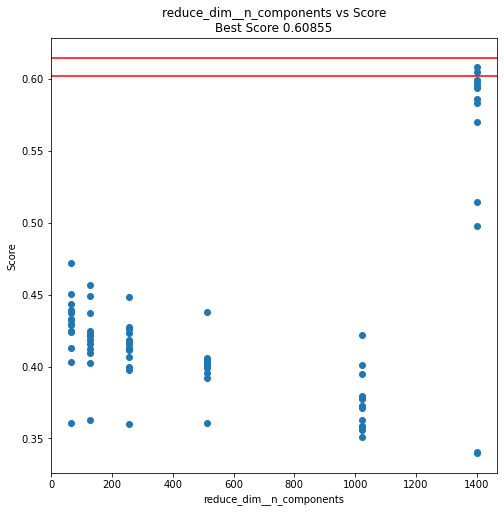

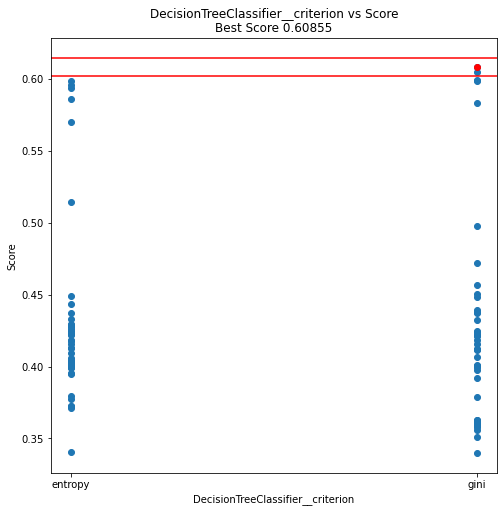

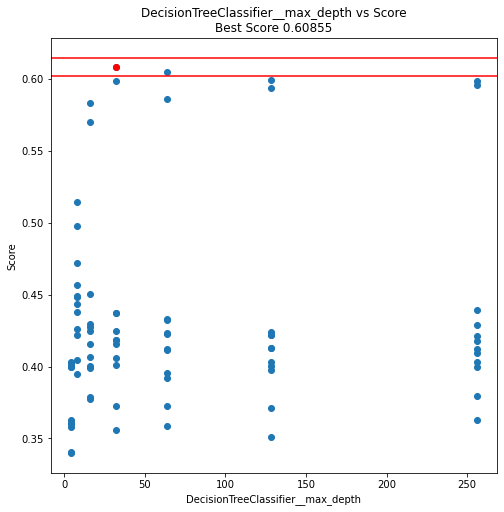

In [52]:
GridSearch_table_plot(grid, param_list=["reduce_dim__n_components","DecisionTreeClassifier__criterion","DecisionTreeClassifier__max_depth"],negative=False)

In [53]:
print(grid.best_params_)
model=grid.best_estimator_
model.fit(train_x,train_y)
y_pred = model.predict(test_x)
test_valutation=valutate_test(test_y,y_pred)
cros_valutation=valutate_model_with_kfold(model,dataset[0].x,dataset[0].y,n_splits=5)
dict_valutazioni['DecisionTreeClassifier']={"test":test_valutation,"kfold":cros_valutation}


print("DecisionTree Classifier")
print( f"Accuracy: {test_valutation['Accuracy']}")
print( f"Macro f1: {test_valutation['f1']}")
print( f"kfold avg Accuracy: {cros_valutation['accuracy']}")
print( f"kfold avg Macro f1: {cros_valutation['f1']}")
print(f"Confusion Matrix:\n {test_valutation['Confusion Matrix']}")

{'DecisionTreeClassifier__criterion': 'gini', 'DecisionTreeClassifier__max_depth': 32, 'reduce_dim': 'passthrough'}
DecisionTree Classifier
Accuracy: 0.6358595194085028
Macro f1: 0.6099557825807619
kfold avg Accuracy: 0.6532449816180231
kfold avg Macro f1: 0.6254743118722947
Confusion Matrix:
 [[127   1   5   9  10   4   3]
 [  9  21   0   3   5   3   5]
 [  8   1  21   4   3   4   3]
 [ 29   1   2  54   4   1   2]
 [ 20   1   0   2  34   3   5]
 [ 15   0   0   0   2  64   2]
 [ 16   1   0   3   6   2  23]]


# Random Forest Classifier

Random Forest è un meta stimatore che si adatta a un numero di alberi decisionali su vari sottocampioni del training set e utilizza la media o la maggioranza per migliorare l'accuratezza predittiva e controllare l'overfitting.

La creazione di una random forest di  alberi di decisione avviene nel seguente modo:

Per ogni albero $b= 1, ... ,B$
Si genera un sample dal training set.
Si apprende un albero di decisione  $T_b$ nel sample effettuando le seguenti operazioni per ogni nodo:

1. Si selezionano $m$ variabili (tra le features) in modo randomico
2. Si sceglie la "migliore" rispetto a queste  variabili
3. Si splitta il nodo in due figli
4. alla fine si ritorna la sequenza di alberi  $T_1, ... ,T_B$
Una volta che si ha la random forest nel caso della classificazione si procede calcolando la maggioranza

nel nostro caso abbiamo utilizzato una foresta di 100 alberi



In [54]:
pipe = Pipeline([("reduce_dim", "passthrough"),
                 ('RandomForestClassifier', RandomForestClassifier())])

parametri=  [
                {  
                    "reduce_dim": [PCA()],
                    "reduce_dim__n_components":[64,128,256,512,1024],
                    "RandomForestClassifier__criterion":['gini','entropy'],
                    "RandomForestClassifier__max_depth":[4,8,16,32,64,128,256],
                    "RandomForestClassifier__n_estimators":[64,128,256,512],


                },
                {
                    "reduce_dim": ["passthrough"],
                    "RandomForestClassifier__criterion":['gini','entropy'],
                    "RandomForestClassifier__max_depth":[4,8,16,32,64,128,256],
                    "RandomForestClassifier__n_estimators":[64,128,256,512],
                    
                }
            ]
        

grid = GridSearchCV(pipe, n_jobs=-1, param_grid=parametri,cv=5,scoring='f1_macro',return_train_score=True)
grid.fit(train_x,train_y)

print("tuned hpyerparameters :(best parameters) ",grid.best_params_)

tuned hpyerparameters :(best parameters)  {'RandomForestClassifier__criterion': 'gini', 'RandomForestClassifier__max_depth': 128, 'RandomForestClassifier__n_estimators': 512, 'reduce_dim': 'passthrough'}


best parameters: {'RandomForestClassifier__criterion': 'gini', 'RandomForestClassifier__max_depth': 128, 'RandomForestClassifier__n_estimators': 512, 'reduce_dim': 'passthrough'}
best score:      0.72797 (+/-0.02755)


param_RandomForestClassifier__criterion  \
303                                    gini   
307                                    gini   
306                                    gini   
302                                    gini   
305                                    gini   
301                                    gini   
298                                    gini   
296                                    gini   
331                                 entropy   
299                                    gini   
297                                    gini   
300                                    gini   
330                                 entropy   
329                                 entropy   
327                                 entropy   
335                                 entropy   
332                                 entropy   
326                                 entropy   
294                                    gini   
295                                    gini   
304                                    gini   
328                                 entropy   
333                                 entropy   
292                                    gini   
334                                 entropy   
321                                 entropy   
325                                 entropy   
293                                    gini   
322                                 entropy   
320                                 entropy   
323                                 entropy   
324                                 entropy   
291                                    gini   
288                                    gini   
289                                    gini   
290                                    gini   
317                                 entropy   
318                                 entropy   
316                                 entropy   
319                                 entropy   

    param_RandomForestClassifier__max_depth  \
303                                     128   
307                                     256   
306                                     256   
302                                     128   
305                                     256   
301                                     128   
298                                      64   
296                                      64   
331                                     128   
299                                      64   
297                                      64   
300                                     128   
330                                     128   
329                                     128   
327                                      64   
335                                     256   
332                                     256   
326                                      64   
294                                      32   
295                                      32   
304                                     256   
328                                     128   
333                                     256   
292                                      32   
334                                     256   
321                                      32   
325                                      64   
293                                      32   
322                                      32   
320                                      32   
323                                      32   
324                                      64   
291                                      16   
288                                      16   
289                                      16   
290                                      16   
317                                      16   
318                                      16   
316                                      16   
319                                      16   

    param_RandomForestClassifier__n_estimators param_reduce_dim__n_components  \
303                                        512                     

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_RandomForestClassifier__criterion',
       'param_RandomForestClassifier__max_depth',
       'param_RandomForestClassifier__n_estimators', 'param_reduce_dim',
       'param_reduce_dim__n_components', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'split0_train_score', 'split1_train_score',
       'split2_train_score', 'split3_train_score', 'split4_train_score',
       'mean_train_score', 'std_train_score'],
      dtype='object')


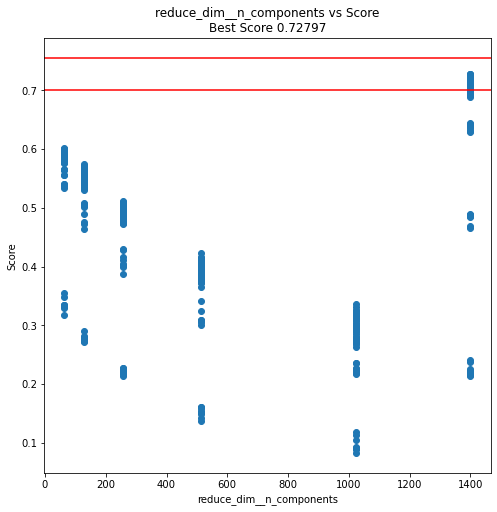

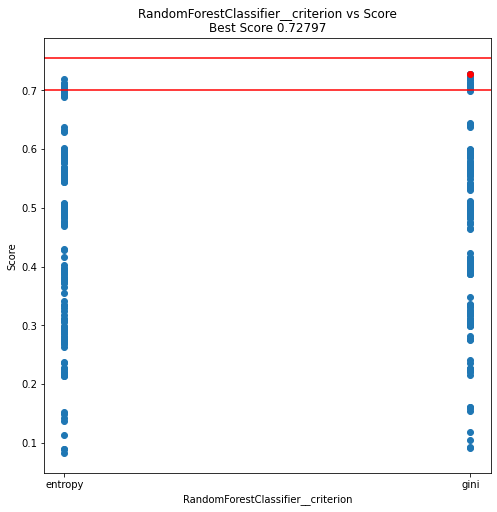

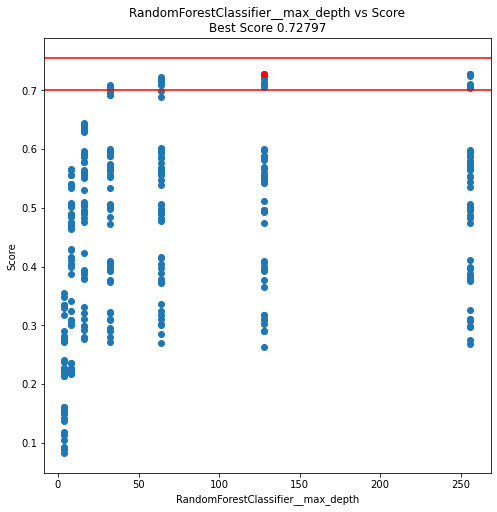

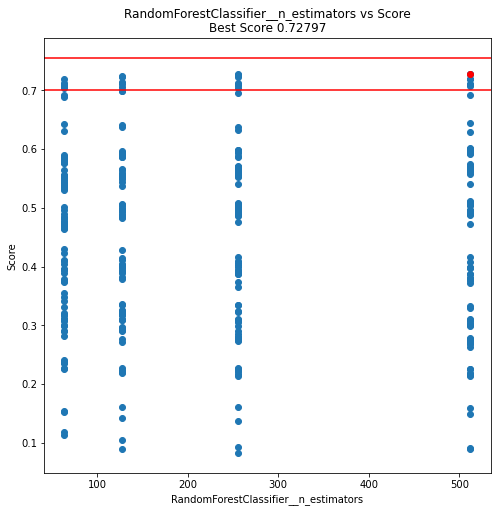

In [55]:
GridSearch_table_plot(grid, param_list=["reduce_dim__n_components","RandomForestClassifier__criterion","RandomForestClassifier__max_depth","RandomForestClassifier__n_estimators"],negative=False)

In [56]:
print(grid.best_params_)
model=grid.best_estimator_
model.fit(train_x,train_y)
y_pred = model.predict(test_x)
test_valutation=valutate_test(test_y,y_pred)
dict_valutazioni['RandomForestClassifier']={"test":test_valutation,}
print("Random Forest Classifier")
print( f"Accuracy: {test_valutation['Accuracy']}")
print( f"Macro f1: {test_valutation['f1']}")
print(f"Confusion Matrix:\n {test_valutation['Confusion Matrix']}")

{'RandomForestClassifier__criterion': 'gini', 'RandomForestClassifier__max_depth': 128, 'RandomForestClassifier__n_estimators': 512, 'reduce_dim': 'passthrough'}
Random Forest Classifier
Accuracy: 0.7504621072088724
Macro f1: 0.7299276515177127
Confusion Matrix:
 [[140   0   0   4  10   3   2]
 [ 10  24   0   2   4   2   4]
 [  8   0  27   4   1   3   1]
 [ 17   0   0  66   3   2   5]
 [ 10   2   1   3  44   2   3]
 [  7   0   2   0   2  70   2]
 [  6   0   0   1   9   0  35]]


# Support Vector Machines

Le support vector machines sono un modello di classificazione che ci permettono di definire degli iperpiani di separazione tra le classi.
L'idea di fondo delle SVMs infatti è quella di cercare l'iperpiano "migliore" che separa le classi nello spazio delle features rispetto ad una misura di separazione.

## SVM kernel linear 

In [29]:



pipe = Pipeline([("reduce_dim", "passthrough"),
                 ('svm',svm.SVC(kernel='linear'))])

parametri=  [
                {  
                    "reduce_dim": [PCA()],
                    "reduce_dim__n_components":[64,128,256,512,1024],
                    "svm__decision_function_shape":['ovo', 'ovr'],
                    "svm__C": [0.1,0.5,1,10,50,100],
                    

                },
                {
                    "reduce_dim": ["passthrough"],
                    "svm__decision_function_shape":['ovo', 'ovr'],
                    "svm__C": [0.1,0.5,1,10,50,100],
                    
                }
            ]
        

grid = GridSearchCV(pipe, n_jobs=-1, param_grid=parametri,cv=5,scoring='f1_macro',return_train_score=True)
grid.fit(train_x,train_y)

print("tuned hpyerparameters :(best parameters) ",grid.best_params_)



tuned hpyerparameters :(best parameters)  {'reduce_dim': 'passthrough', 'svm__C': 0.1, 'svm__decision_function_shape': 'ovo'}


best parameters: {'reduce_dim': 'passthrough', 'svm__C': 0.1, 'svm__decision_function_shape': 'ovo'}
best score:      0.71005 (+/-0.02686)


param_reduce_dim__n_components param_svm__C  \
60                            NaN          0.1   
61                            NaN          0.1   
48                           1024          0.1   
49                           1024          0.1   
36                            512          0.1   
24                            256          0.1   
62                            NaN          0.5   
63                            NaN          0.5   
37                            512          0.1   
51                           1024          0.5   
25                            256          0.1   
50                           1024          0.5   
38                            512          0.5   
39                            512          0.5   
27                            256          0.5   
14                            128          0.5   
29                            256            1   
13                            128          0.1   
12                            128          0.1   
26                            256          0.5   
28                            256            1   
53                           1024            1   
52                           1024            1   
15                            128          0.5   
64                            NaN            1   
65                            NaN            1   
17                            128            1   
41                            512            1   
16                            128            1   
40                            512            1   
5                              64            1   
54                           1024           10   
57                           1024           50   
58                           1024          100   
59                           1024          100   
56                           1024           50   
55                           1024           10   
3                              64          0.5   
70                            NaN          100   
66                            NaN           10   

   param_svm__decision_function_shape  mean_test_score  std_test_score  \
60                                ovo         0.710045        0.026860   
61                                ovr         0.710045        0.026860   
48                                ovo         0.709142        0.025473   
49                                ovr         0.707173        0.027379   
36                                ovo         0.706777        0.027774   
24                                ovo         0.705782        0.028565   
62                                ovo         0.705080        0.030109   
63                                ovr         0.705080        0.030109   
37                                ovr         0.703866        0.030213   
51                                ovr         0.702361        0.033277   
25                                ovr         0.701579        0.027548   
50                                ovo         0.700611        0.028925   
38                                ovo         0.697378        0.038552   
39                                ovr         0.695697        0.034098   
27                                ovr         0.691179        0.034234   
14                                ovo         0.691088        0.040526   
29                                ovr         0.690523        0.039381   
13                                ovr         0.688463        0.031094   
12                                ovo         0.687653        0.031108   
26                                ovo         0.686840        0.039807   
28                                ovo         0.685936        0.029354   
53                                ovr         0.685783        0.030940   
52                                ovo         0.685216        0.026507   
15                                ovr         0.683565        0.041389   
64                                ovo         0.683067        0.029057   
65                          

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_reduce_dim', 'param_reduce_dim__n_components', 'param_svm__C',
       'param_svm__decision_function_shape', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'split0_train_score', 'split1_train_score',
       'split2_train_score', 'split3_train_score', 'split4_train_score',
       'mean_train_score', 'std_train_score'],
      dtype='object')


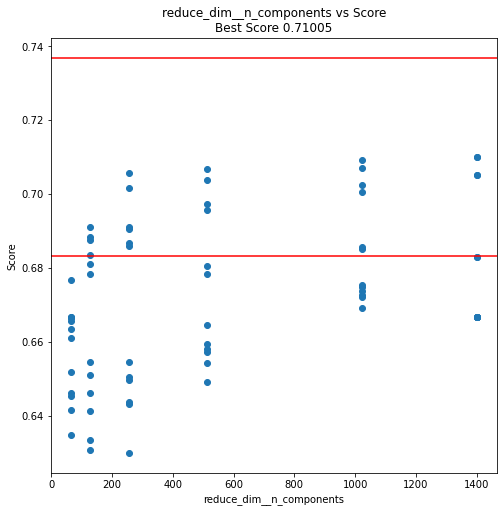

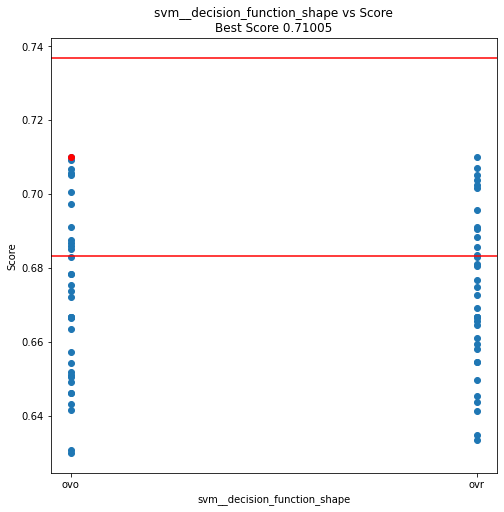

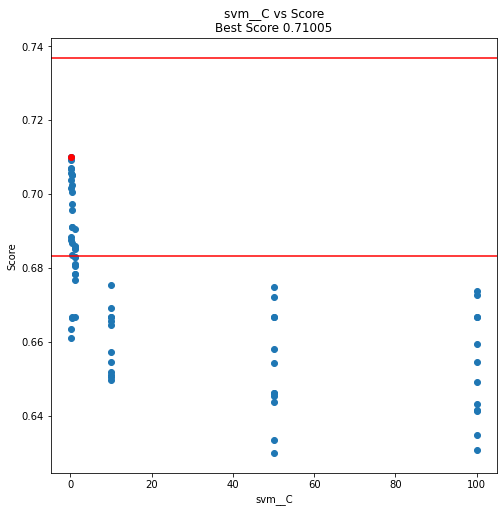

In [38]:
GridSearch_table_plot(grid, param_list=["reduce_dim__n_components","svm__decision_function_shape","svm__C"],negative=False)

In [31]:
print(grid.best_params_)
model=grid.best_estimator_
model.fit(train_x,train_y)
y_pred = model.predict(test_x)
test_valutation=valutate_test(test_y,y_pred)
dict_valutazioni['svm']={"test":test_valutation}
print("SVM linear")
print( f"Accuracy: {test_valutation['Accuracy']}")
print( f"Macro f1: {test_valutation['f1']}")
print(f"Confusion Matrix:\n {test_valutation['Confusion Matrix']}")

{'reduce_dim': 'passthrough', 'svm__C': 0.1, 'svm__decision_function_shape': 'ovo'}
SVM linear
Accuracy: 0.7301293900184843
Macro f1: 0.7109704416758619
Confusion Matrix:
 [[135   1   0   6  12   2   3]
 [  8  24   0   0  10   0   4]
 [  6   0  30   3   3   2   0]
 [ 15   1   2  67   3   2   3]
 [ 10   1   0   4  44   2   4]
 [ 13   0   1   0   2  66   1]
 [  6   2   1   4   7   2  29]]


## SVM kernel poly

fromula polinomial kernel

$K\_poly(x,x')=(x^tx'+c)^d $

nel nostro caso il parametro d è 3

In [57]:
pipe = Pipeline([("reduce_dim", "passthrough"),
                 ('svm', svm.SVC(kernel='poly'))])

parametri=  [
                {  
                    "reduce_dim": [PCA()],
                    "reduce_dim__n_components":[64,128,256,512,1024],
                    "svm__degree":[2,3,4,5,6,7],
                    "svm__decision_function_shape":['ovo', 'ovr'],
                    "svm__C": [0.1,0.5,1,10,50,100],



                },
                {
                    "reduce_dim": ["passthrough"],
                    "svm__degree":[2,3,4,5,6,7],
                    "svm__decision_function_shape":['ovo', 'ovr'],
                    "svm__C": [0.1,0.5,1,10,50,100],
                    
                }
            ]
grid = GridSearchCV(pipe, n_jobs=-1, param_grid=parametri,cv=5,scoring='f1_macro',return_train_score=True)
grid.fit(train_x,train_y)

print("tuned hpyerparameters :(best parameters) ",grid.best_params_)

tuned hpyerparameters :(best parameters)  {'reduce_dim': 'passthrough', 'svm__C': 50, 'svm__decision_function_shape': 'ovo', 'svm__degree': 2}


best parameters: {'reduce_dim': 'passthrough', 'svm__C': 50, 'svm__decision_function_shape': 'ovo', 'svm__degree': 2}
best score:      0.65257 (+/-0.02019)


param_reduce_dim__n_components param_svm__C  \
414                            NaN           50   
408                            NaN           50   
426                            NaN          100   
420                            NaN          100   
396                            NaN           10   
402                            NaN           10   
114                            128           10   
108                            128           10   
186                            256           10   
36                              64           10   
264                            512           50   
270                            512           50   
276                            512          100   
198                            256           50   
55                              64           50   
192                            256           50   
180                            256           10   
126                            128           50   
336                           1024           50   
342                           1024           50   
348                           1024          100   
282                            512          100   
354                           1024          100   
120                            128           50   
67                              64          100   
61                              64          100   
49                              64           50   
210                            256          100   
204                            256          100   
390                            NaN            1   
384                            NaN            1   
42                              64           10   
252                            512           10   
37                              64           10   
258                            512           10   
330                           1024           10   
43                              64           10   
324                           1024           10   
132                            128          100   
138                            128          100   

    param_svm__decision_function_shape param_svm__degree  mean_test_score  \
414                                ovr                 2         0.652566   
408                                ovo                 2         0.652566   
426                                ovr                 2         0.651340   
420                                ovo                 2         0.651340   
396                                ovo                 2         0.637546   
402                                ovr                 2         0.637546   
114                                ovr                 2         0.596952   
108                                ovo                 2         0.592751   
186                                ovr                 2         0.590545   
36                                 ovo                 2         0.590518   
264                                ovo                 2         0.590256   
270                                ovr                 2         0.587491   
276                                ovo                 2         0.587316   
198                                ovr                 2         0.586844   
55                                 ovr                 3         0.586741   
192                                ovo                 2         0.586347   
180                                ovo                 2         0.586011   
126                                ovr                 2         0.585299   
336                                ovo                 2         0.584884   
342                                ovr                 2         0.584300   
348                                ovo                 2         0.582485   
282                                ovr                 2         0.581416   
354                                ovr                 2         0.580376   
120                                ovo                 2        

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_reduce_dim', 'param_reduce_dim__n_components', 'param_svm__C',
       'param_svm__decision_function_shape', 'param_svm__degree', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'split3_train_score',
       'split4_train_score', 'mean_train_score', 'std_train_score'],
      dtype='object')


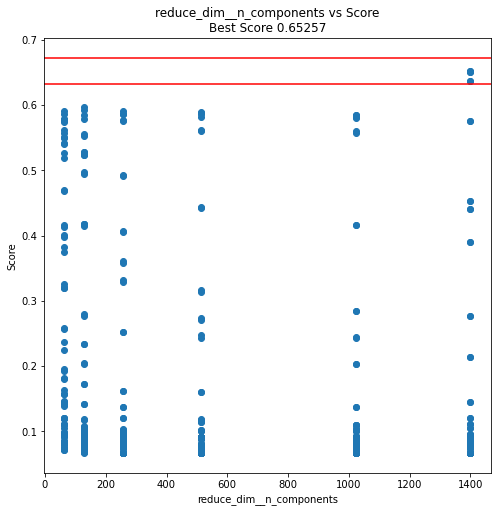

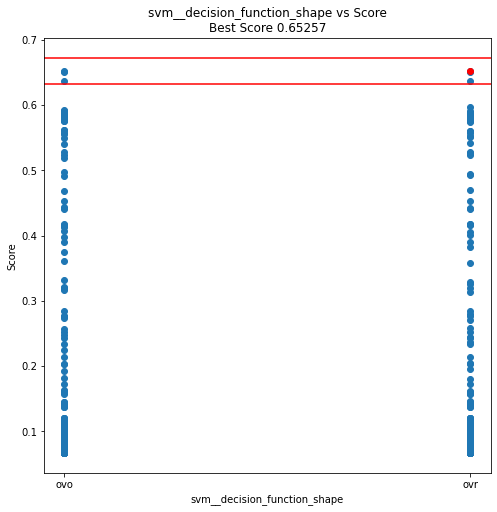

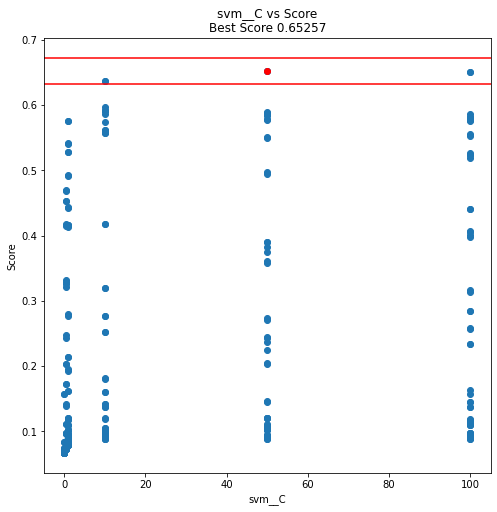

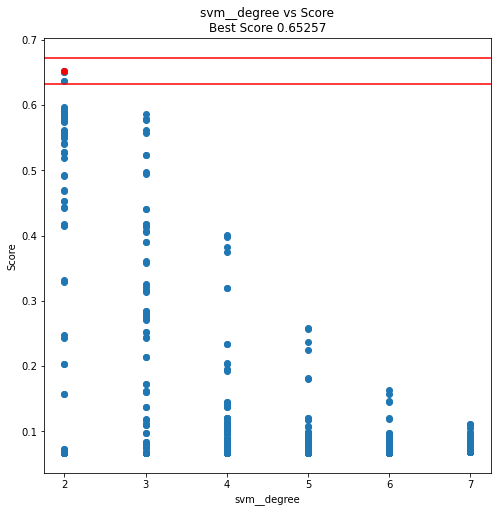

In [58]:
GridSearch_table_plot(grid, param_list=["reduce_dim__n_components","svm__decision_function_shape","svm__C","svm__degree"],negative=False)

In [59]:
print(grid.best_params_)
model=grid.best_estimator_
model.fit(train_x,train_y)
y_pred = model.predict(test_x)
test_valutation=valutate_test(test_y,y_pred)
dict_valutazioni['svm']={"test":test_valutation}
print("SVM polinear")
print( f"Accuracy: {test_valutation['Accuracy']}")
print( f"Macro f1: {test_valutation['f1']}")
print(f"Confusion Matrix:\n {test_valutation['Confusion Matrix']}")





{'reduce_dim': 'passthrough', 'svm__C': 50, 'svm__decision_function_shape': 'ovo', 'svm__degree': 2}
SVM polinear
Accuracy: 0.6839186691312384
Macro f1: 0.6537748704497472
Confusion Matrix:
 [[138   0   1   8   9   2   1]
 [ 21  13   0   0   6   1   5]
 [  9   0  27   2   2   4   0]
 [ 20   0   1  67   2   0   3]
 [ 17   1   2   4  40   1   0]
 [ 21   0   0   0   2  59   1]
 [ 15   0   2   2   6   0  26]]


## SVM kernel rbf

formula kernerl Radial basis function (rbf)

$K\_rbf(x,x')= exp(-\frac{|| x-x' ||^2}{2\sigma^2} ) $

In [60]:
pipe = Pipeline([("reduce_dim", "passthrough"),
                 ('svm', svm.SVC(kernel='rbf'))])

parametri=  [
                {  
                    "reduce_dim": [PCA()],
                    "reduce_dim__n_components":[64,128,256,512,1024],
                    "svm__decision_function_shape":['ovo', 'ovr'],
                    "svm__C": [0.1,0.5,1,10,50,100],
                    "svm__gamma": [0.001, 0.01 , 0.1 , 1 ,10, 100]


                },
                {
                    "reduce_dim": ["passthrough"],
                    "svm__decision_function_shape":['ovo', 'ovr'],
                    "svm__C": [0.1,0.5,1,10,50,100],
                    "svm__gamma": [0.001, 0.01 , 0.1 , 1 ,10, 100]
                    
                }
            ]
        

grid = GridSearchCV(pipe, n_jobs=-1, param_grid=parametri,cv=5,scoring='f1_macro',return_train_score=True)
grid.fit(train_x,train_y)

print("tuned hpyerparameters :(best parameters) ",grid.best_params_)

tuned hpyerparameters :(best parameters)  {'reduce_dim': PCA(n_components=256), 'reduce_dim__n_components': 256, 'svm__C': 1, 'svm__decision_function_shape': 'ovo', 'svm__gamma': 0.1}


best parameters: {'reduce_dim': PCA(n_components=256), 'reduce_dim__n_components': 256, 'svm__C': 1, 'svm__decision_function_shape': 'ovo', 'svm__gamma': 0.1}
best score:      0.72072 (+/-0.02424)


param_reduce_dim__n_components param_svm__C  \
170                            256            1   
325                           1024           10   
331                           1024           10   
176                            256            1   
182                            256           10   
397                            NaN           10   
403                            NaN           10   
187                            256           10   
116                            128           10   
354                           1024          100   
188                            256           10   
426                            NaN          100   
420                            NaN          100   
348                           1024          100   
110                            128           10   
259                            512           10   
408                            NaN           50   
414                            NaN           50   
253                            512           10   
270                            512           50   
342                           1024           50   
336                           1024           50   
198                            256           50   
192                            256           50   
260                            512           10   
200                            256           50   
181                            256           10   
194                            256           50   
204                            256          100   
266                            512           50   
254                            512           10   
282                            512          100   
337                           1024           50   
264                            512           50   
272                            512           50   
212                            256          100   
210                            256          100   
98                             128            1   
104                            128            1   
276                            512          100   

    param_svm__decision_function_shape param_svm__gamma  mean_test_score  \
170                                ovo              0.1         0.720716   
325                                ovo             0.01         0.718241   
331                                ovr             0.01         0.717799   
176                                ovr              0.1         0.717345   
182                                ovo              0.1         0.716556   
397                                ovo             0.01         0.716073   
403                                ovr             0.01         0.716073   
187                                ovr             0.01         0.711881   
116                                ovr              0.1         0.711617   
354                                ovr            0.001         0.711519   
188                                ovr              0.1         0.710997   
426                                ovr            0.001         0.710805   
420                                ovo            0.001         0.710805   
348                                ovo            0.001         0.710622   
110                                ovo              0.1         0.709332   
259                                ovr             0.01         0.709188   
408                                ovo            0.001         0.708861   
414                                ovr            0.001         0.708861   
253                                ovo             0.01         0.708593   
270                                ovr            0.001         0.708291   
342                                ovr            0.001         0.707382   
336                                ovo            0.001         0.706100   
198                                ovr            0.001         0.706083   
192                                ovo            0.001         0.705910   
260         

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_reduce_dim', 'param_reduce_dim__n_components', 'param_svm__C',
       'param_svm__decision_function_shape', 'param_svm__gamma', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'split3_train_score',
       'split4_train_score', 'mean_train_score', 'std_train_score'],
      dtype='object')


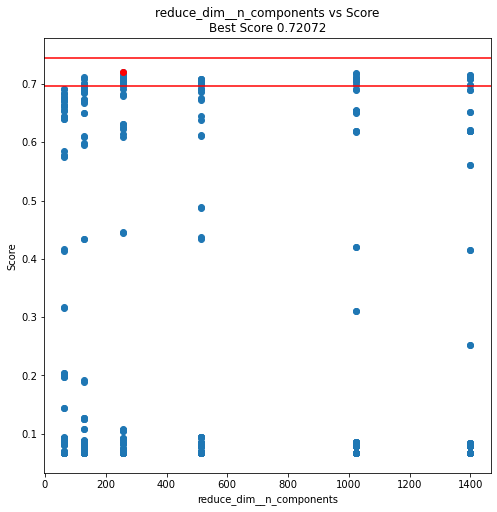

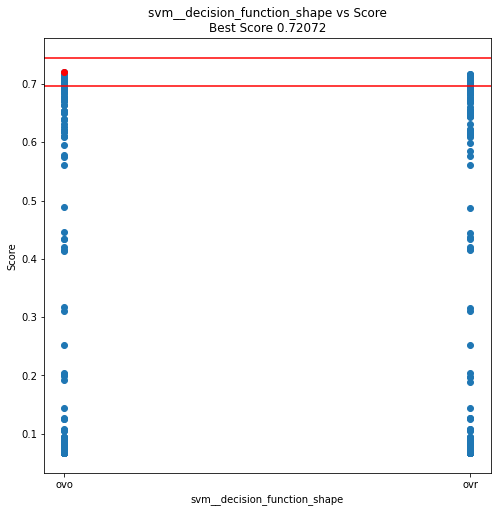

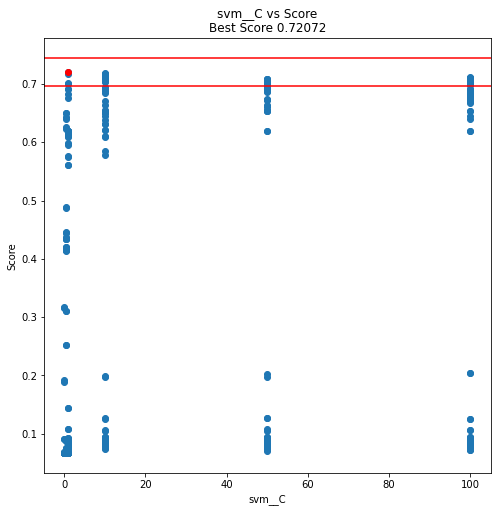

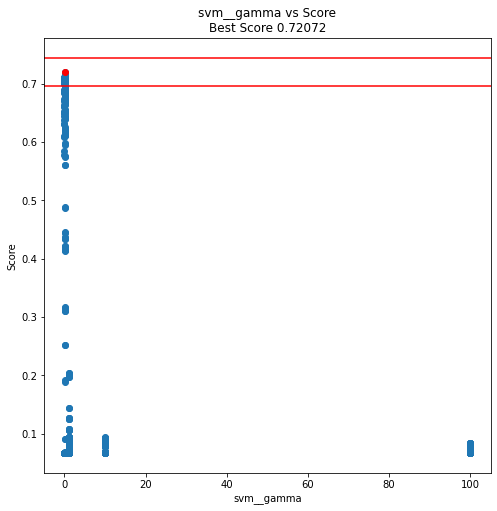

In [61]:
GridSearch_table_plot(grid, param_list=["reduce_dim__n_components","svm__decision_function_shape","svm__C","svm__gamma"],negative=False)

In [62]:
print(grid.best_params_)
model=grid.best_estimator_
model.fit(train_x,train_y)
y_pred = model.predict(test_x)
test_valutation=valutate_test(test_y,y_pred)
dict_valutazioni['svm']={"test":test_valutation}
print("SVM rbf")
print( f"Accuracy: {test_valutation['Accuracy']}")
print( f"Macro f1: {test_valutation['f1']}")
print(f"Confusion Matrix:\n {test_valutation['Confusion Matrix']}")



{'reduce_dim': PCA(n_components=256), 'reduce_dim__n_components': 256, 'svm__C': 1, 'svm__decision_function_shape': 'ovo', 'svm__gamma': 0.1}
SVM rbf
Accuracy: 0.7319778188539742
Macro f1: 0.7086521649472152
Confusion Matrix:
 [[140   1   0   6  10   1   1]
 [ 11  19   0   1  12   0   3]
 [ 10   0  28   2   3   1   0]
 [ 20   1   0  67   1   1   3]
 [ 10   1   1   6  43   1   3]
 [ 11   0   1   0   1  68   2]
 [ 10   1   0   1   7   1  31]]


# Neural Networks

In [9]:


class modello(torch.nn.Module):
    def __init__(self,n_feature=1433,n_layers=0,dim_hidden_layers=300,activation=F.relu,dropout=0.2):
        super().__init__()
        
        self.dropout = torch.nn.Dropout(dropout)
        self.dense_layers=torch.nn.ModuleList([torch.nn.Linear(dim_hidden_layers, dim_hidden_layers) for i in range(n_layers)])
        self.activation=activation
        self.n_layers=n_layers
        self.lin_in = torch.nn.Linear(n_feature, dim_hidden_layers)
        self.lin_out = torch.nn.Linear(dim_hidden_layers, 7)
    
    def forward(self, data):
        x = data.x
        x = self.lin_in(x)
        x = self.activation(x)
        x=  self.dropout(x)
        for i in range(self.n_layers):
            x = self.dense_layers[i](x)
            x = self.activation(x)
            x=  self.dropout(x)
        x = self.lin_out(x)
        return F.log_softmax(x, dim=1)


import pandas as pd
from sklearn.model_selection import ParameterGrid

preprocessing=[{"reduce_dim":[PCA],
                "n_components":[64,128,256,512,1024]},
                
                {"reduce_dim": ["passthrough"]}]

parametri_modello = {
    'n_layers':[0,1,2,4,5],
    'dim_hidden_layers':[50,150,300,1000],
    'activation':[ torch.relu ,torch.sigmoid,torch.tanh],
    'dropout':[0,0.2,0.3,0.5]
}

parametri_training={
    "epochs":[10,20,30,50,100],
    "optimizer":[torch.optim.Adam],
    "loss":[F.nll_loss]
}

data=dataset[0].clone()

param=gridSearch( cv=5,dataset=data,
            modello=modello,
            preprocessing=preprocessing,
            parametri_training=parametri_training,
            parametri_modello=parametri_modello)
param.to_pickle("neuralnet.pkl")


64
128
256
512
1024
1433


epochs                                       loss  \
6555      30  <function nll_loss at 0x0000022A3D0A9E50>   
6765      50  <function nll_loss at 0x0000022A3D0A9E50>   
6715      30  <function nll_loss at 0x0000022A3D0A9E50>   
6476      20  <function nll_loss at 0x0000022A3D0A9E50>   
6556      30  <function nll_loss at 0x0000022A3D0A9E50>   
...      ...                                        ...   
2236     100  <function nll_loss at 0x0000022A3D0A9E50>   
6237      10  <function nll_loss at 0x0000022A3D0A9E50>   
7031     100  <function nll_loss at 0x0000022A3D0A9E50>   
6901      50  <function nll_loss at 0x0000022A3D0A9E50>   
6915      50  <function nll_loss at 0x0000022A3D0A9E50>   

                            optimizer  \
6555  <class 'torch.optim.adam.Adam'>   
6765  <class 'torch.optim.adam.Adam'>   
6715  <class 'torch.optim.adam.Adam'>   
6476  <class 'torch.optim.adam.Adam'>   
6556  <class 'torch.optim.adam.Adam'>   
...                               ...   
2236  <class 'torch.optim.adam.Adam'>   
6237  <class 'torch.optim.adam.Adam'>   
7031  <class 'torch.optim.adam.Adam'>   
6901  <class 'torch.optim.adam.Adam'>   
6915  <class 'torch.optim.adam.Adam'>   

                                             activation  dim_hidden_layers  \
6555  <built-in method relu of type object at 0x0000...               1000   
6765  <built-in method relu of type object at 0x0000...                300   
6715  <built-in method tanh of type object at 0x0000...               1000   
6476  <built-in method tanh of type object at 0x0000...               1000   
6556  <built-in method relu of type object at 0x0000...               1000   
...                                                 ...                ...   
2236  <built-in method relu of type object at 0x0000...               1000   
6237  <built-in method tanh of type object at 0x0000...               1000   
7031  <built-in method relu of type object at 0x0000...               1000   
6901  <built-in method tanh of type object at 0x0000...                150   
6915  <built-in method tanh of type object at 0x0000...                150   

      dropout  n_layers  n_feature  z_mean_test_score  z_std_test_score  \
6555      0.5         0       1433           0.741582          0.026806   
6765      0.2         0       1433           0.740343          0.025495   
6715      0.5         0       1433           0.738742          0.027897   
6476      0.5         1       1433           0.738497          0.022716   
6556      0.5         1       1433           0.737882          0.021881   
...       ...       ...        ...                ...               ...   
2236      0.5         1        128           0.716354          0.033178   
6237      0.5         2       1433           0.716132          0.022843   
7031      0.3         1       1433           0.716008          0.018625   
6901      0.0         1       1433           0.715798          0.023488   
6915      0.5         0       1433           0.715496          0.032613   

      z_mean_train_score  z_std_train_score  
6555            0.940309           0.001783  
6765            0.962692           0.002849  
6715            0.945868           0.002086  
6476            0.975336           0.003274  
6556            0.985667           0.001707  
...                  ...                ...  
2236            0.997389           0.000715  
6237            0.869936           0.009786  
7031            1.000000           0.000000  
6901            0.983030           0.002755  
6915            0.908502           0.004177  

[100 rows x 12 columns]

30
<built-in method relu of type object at 0x00007FF81ECBA590>
1000
0.5
0
1433


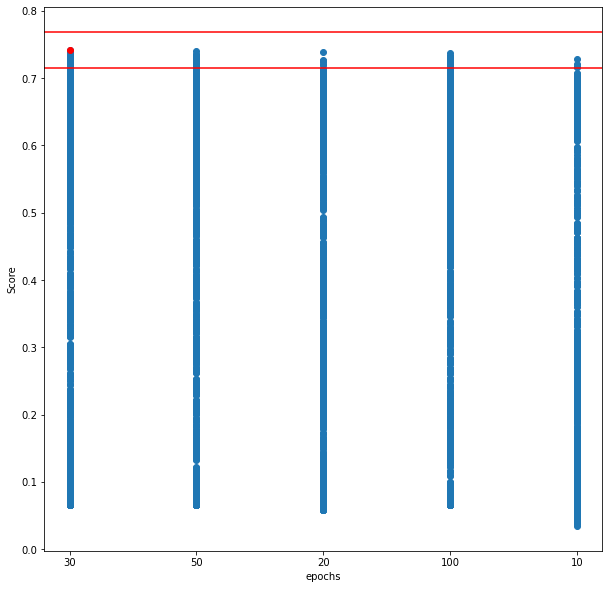

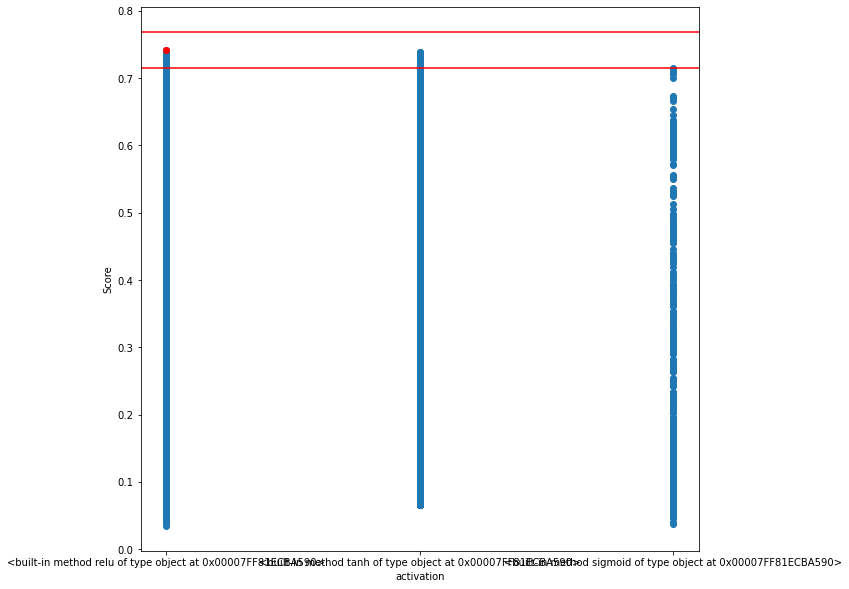

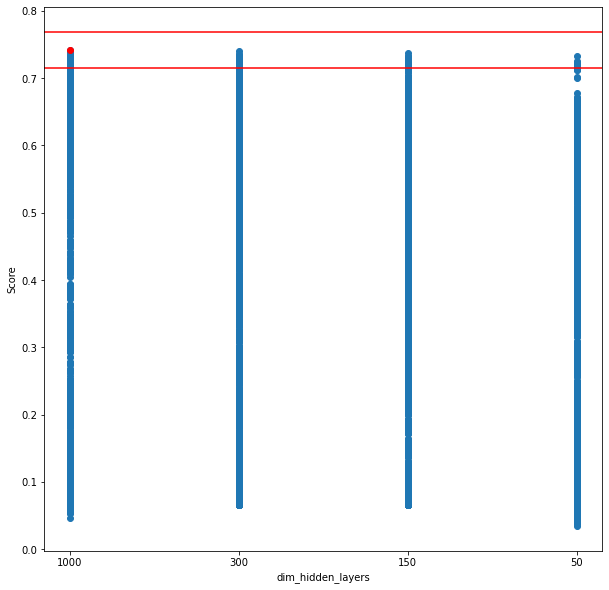

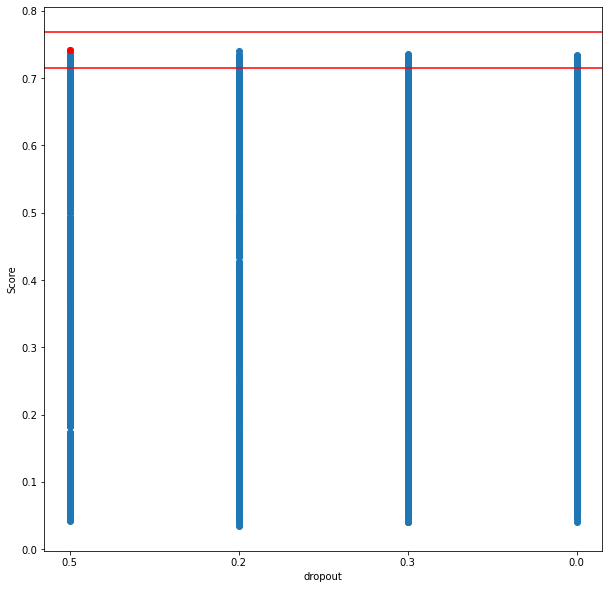

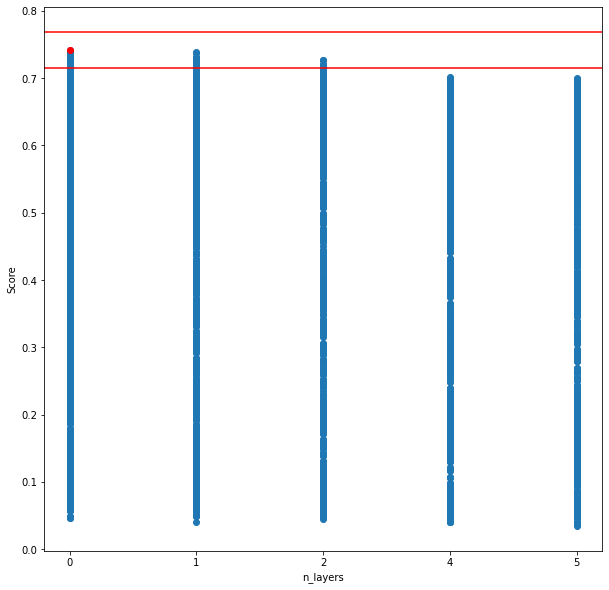

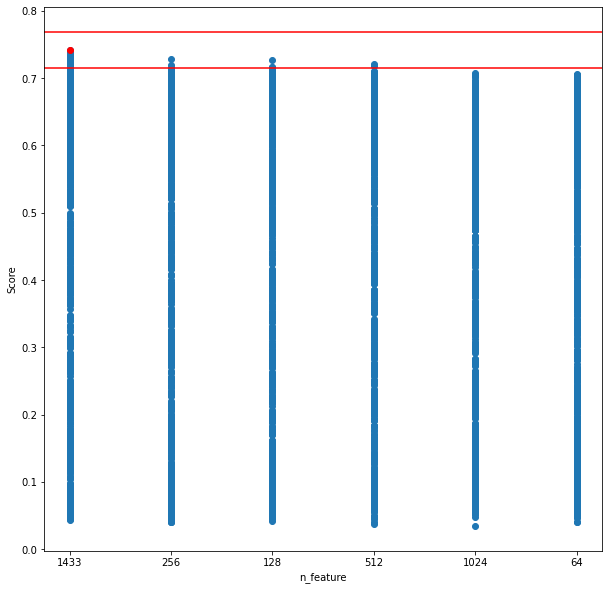

In [14]:
#unpickled_df = pd.read_pickle("./file.pkl")
pa=param.sort_values(by=['z_mean_test_score'],ascending=False)

param_list=[	"epochs","activation"	,"dim_hidden_layers",	"dropout",	"n_layers"	,"n_feature"]
scores_df=pa
display(pa.head(100))
best_row = scores_df.iloc[0, :]
best_mean = best_row['z_mean_test_score']
best_stdev = best_row['z_std_test_score']
for param_name in param_list:
    best_param =str( best_row[param_name])
    print(best_param)
    means = scores_df['z_mean_test_score']
    stds = scores_df['z_std_test_score']
    params = scores_df[param_name].astype(str)
    
    plt.figure(figsize=(10, 10))
    plt.plot(params, means,"o")

    plt.axhline(y=best_mean + best_stdev, color='red')
    plt.axhline(y=best_mean - best_stdev, color='red')
    plt.plot(best_param, best_mean, 'or')

    plt.xlabel(param_name)
    plt.ylabel('Score')
plt.show()


In [17]:
modello_migliore = {
    'n_layers':0,
    'dim_hidden_layers':1000,
    'activation': torch.relu ,
    'dropout':0.5
}

training_migliore={
    "epochs":30,
    "optimizer":torch.optim.Adam,
    "loss":F.nll_loss
}


data=dataset[0]
model=modello(**modello_migliore).to("cuda")
data.to('cuda')

optimizer=training_migliore['optimizer'](model.parameters())
model.train()
for _ in range(training_migliore['epochs']):
    optimizer.zero_grad()
    out = model(data)
    loss=training_migliore['loss'](out[data.train_mask],data.y[data.train_mask])
    loss.backward()
    optimizer.step()

model.eval()
pred = model(data)
pred=pred.argmax(dim=1)

f_test=metrics.f1_score(data.y[data.test_mask].cpu(), pred[data.test_mask].cpu() ,average='macro')
f_train=metrics.f1_score(data.y[data.train_mask].cpu(), pred[data.train_mask].cpu() ,average='macro')

accuracy_test=metrics.accuracy_score(data.y[data.test_mask].cpu(), pred[data.test_mask].cpu())
accuracy_train=metrics.accuracy_score(data.y[data.train_mask].cpu(), pred[data.train_mask].cpu() )
matr=metrics.confusion_matrix(data.y[data.test_mask].cpu(), pred[data.test_mask].cpu())

print(f"accuracy test: {accuracy_test}")

print(f"accuracy train: {accuracy_train}")
print(f"f1 test: {f_test}")
print(f"f1 train: {f_train}")

print(matr)




accuracy test: 0.744916820702403
accuracy train: 0.928011075219197
f1 test: 0.7140371483734123
f1 train: 0.9234491308237859
[[138   1   1   6   9   3   1]
 [  9  22   1   1   7   1   5]
 [  8   0  27   3   3   2   1]
 [ 17   1   1  66   3   1   4]
 [  5   4   2   3  44   4   3]
 [  7   0   1   0   0  73   2]
 [  6   0   1   3   6   2  33]]


# Graph neural network 


le graph neural network sono state progettate per lavorare su grafi, struttura che presenta le seguenti caratteristiche la rede inapplicabile con le tecniche di learning classiche:

1. Dimensione arbitraria e struttura topologica complessa
2. Ordine dei nodi non fissato
3. Nodi e archi con più feature

le graph neural network possono risolvere i task di classificazione di nodi di un grafo, di link prediction e possono essere utilizzate per avere una rappresentazione in uno spazio vettoriale dei nodi del grafo (dove la similarietà tra i nodi viene matentenuta).

## Contex diffusion 

1. **Inizializzazione**: gli stati iniziali dei nodi corrispondono al vettore delle feature o comunque sono in funzione di esso.

2. **message dispatching**: Un messaggio viene calcolato per ogni nodo usando il suo stato corrente e l’informazione dell’arco. Successivamente il messaggio viene inviato ai nodi vicini 

3. **state update**: i messaggi in arrivo da i vicini insieme al proprio stato corrente vengono usati per aggiornare lo stato del nodo

 
## Formulazione generale aggrecazione dei vicini

Aggregazione del vicinato per un nodo i al layer $l+1$

$x_i^{l+1} =   \phi^{l+1}(\Delta( \{ \delta^{l+1} (x_u^{l}) | u \in N_i \cup i  \}   ) ) $

1. $x_i^l$  è lo stato del nodo i al layer l 

2. $\phi , \delta  $  implementano trasformazioni dei dati di input (trasformazioni lineari i attraverso multi layare percentron)
3. $\Delta$ è la funzione di aggrecazione dei nodi vicini, in questo caso una funzione di aggreccazione valida deve essere permutation invariant inquanto  l'ordinamento dei nodi del vicinato non è definito. Alcuni esempi di funzioni di aggrecazione sono la somma o la media 
4. $N_i$ insieme dei vicini del nodo i 

 

In [75]:
#from torch_geometric.nn import GCNConv
#from torch_geometric.nn import GATConv
import torch.nn.functional as F

from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
import torch_geometric.nn as pyg_nn
import torch_geometric
import torch_geometric.utils as pyg_utils

## Implementazione del layer Graph Convolution Network 
    
Il layer GCN è cosi definito 
- $x_i^{(k)} = \sum \limits _{j \in N(i) \cup{i} } \frac{1} {\sqrt{deg(i)} \sqrt{deg(j)}}(\Theta^T x_j^{(k-1)} ) $

dove le caratteristiche dei nodi vicini vengono prima trasformate dala matrice dei pesi $\Theta$ , normalizzate per il loro grado e infine sommate. \
Questa formula può essere suddivisa nei seguenti passaggi:

1. Aggiungere gli archi a se stessi nella matrice di adiacenza 
2. Trasformare linearmente la matrice delle feature dei nodi $(\Theta^T x_j^{(k-1)} )$
3. Calcolare i coefficienti di normalizzazione $\frac{1} {\sqrt{deg(i)} \sqrt{deg(j)}}$
4. Normalizzare le feature dei nodi 
5. sommare le fature dei vicini ("add" aggregation)

adesso vediamo dove ognuno di questi passaggi viene eseguito nel codice

In [76]:


class MyGCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')  # "Add" aggregation (Step 5).
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Aggiungere gli archi a se stessi.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Trasformare linearmente la matrice delle feature dei nodi.
        x = self.lin(x)

        # Step 3: Calcolare la normalizzazione.
        i, j = edge_index
        deg = degree(j, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[i] * deg_inv_sqrt[j]

        # Step 4-5: Propagazione della feature del nodo ai vicini.
        return self.propagate(edge_index, x=x, norm=norm)

    def message(self, x_j, norm):
        # x_j has shape [E, out_channels]

        # Step 4:normazia le feature dei nodi.
        return norm.view(-1, 1) * x_j

In [21]:
class modello(torch.nn.Module):
    def __init__(self,n_feature=1433,n_layers=0,dim_hidden_layers=300,activation=F.relu,dropout=0.2):
        super().__init__()
        
        self.dropout = torch.nn.Dropout(dropout)
        self.dense_layers=torch.nn.ModuleList([MyGCNConv(dim_hidden_layers, dim_hidden_layers) for i in range(n_layers)])
        self.activation=activation
        self.n_layers=n_layers
        self.conv1 = MyGCNConv(n_feature, dim_hidden_layers)
        self.conv2 = MyGCNConv(dim_hidden_layers, 7)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = self.activation(x)
        x=  self.dropout(x)
        for i in range(self.n_layers):
            x = self.dense_layers[i](x,edge_index)
            x = self.activation(x)
            x=  self.dropout(x)

        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

## Tuning dei Parametri

In [60]:

import pandas as pd
from sklearn.model_selection import ParameterGrid
preprocessing=[{"reduce_dim":[PCA],
                "n_components":[64,128,256,512,1024]},
                
                {"reduce_dim": ["passthrough"]}]

parametri_modello = {
    'n_layers':[0,1,2,4,5],
    'dim_hidden_layers':[50,150,300,1000],
    'activation':[ torch.relu ,torch.sigmoid,torch.tanh],
    'dropout':[0,0.2,0.3,0.5]
}

parametri_training={
    "epochs":[10,20,30,50,100],
    "optimizer":[torch.optim.Adam],
    "loss":[F.nll_loss]
}

data=dataset[0].clone()

param=gridSearch( cv=5,dataset=data,
            modello=modello,
            preprocessing=preprocessing,
            parametri_training=parametri_training,
            parametri_modello=parametri_modello)



64
128
256
512
1024
1433


epochs                                       loss  \
1036     100  <function nll_loss at 0x0000022A3D0A9E50>   
7150     100  <function nll_loss at 0x0000022A3D0A9E50>   
6985     100  <function nll_loss at 0x0000022A3D0A9E50>   
7145     100  <function nll_loss at 0x0000022A3D0A9E50>   
3181      50  <function nll_loss at 0x0000022A3D0A9E50>   
6990     100  <function nll_loss at 0x0000022A3D0A9E50>   
7175     100  <function nll_loss at 0x0000022A3D0A9E50>   
6795      50  <function nll_loss at 0x0000022A3D0A9E50>   
1031     100  <function nll_loss at 0x0000022A3D0A9E50>   
786       50  <function nll_loss at 0x0000022A3D0A9E50>   
2207     100  <function nll_loss at 0x0000022A3D0A9E50>   
6770      50  <function nll_loss at 0x0000022A3D0A9E50>   
6785      50  <function nll_loss at 0x0000022A3D0A9E50>   
791       50  <function nll_loss at 0x0000022A3D0A9E50>   
6995     100  <function nll_loss at 0x0000022A3D0A9E50>   

                            optimizer  \
1036  <class 'torch.optim.adam.Adam'>   
7150  <class 'torch.optim.adam.Adam'>   
6985  <class 'torch.optim.adam.Adam'>   
7145  <class 'torch.optim.adam.Adam'>   
3181  <class 'torch.optim.adam.Adam'>   
6990  <class 'torch.optim.adam.Adam'>   
7175  <class 'torch.optim.adam.Adam'>   
6795  <class 'torch.optim.adam.Adam'>   
1031  <class 'torch.optim.adam.Adam'>   
786   <class 'torch.optim.adam.Adam'>   
2207  <class 'torch.optim.adam.Adam'>   
6770  <class 'torch.optim.adam.Adam'>   
6785  <class 'torch.optim.adam.Adam'>   
791   <class 'torch.optim.adam.Adam'>   
6995  <class 'torch.optim.adam.Adam'>   

                                             activation  dim_hidden_layers  \
1036  <built-in method relu of type object at 0x0000...               1000   
7150  <built-in method tanh of type object at 0x0000...                150   
6985  <built-in method relu of type object at 0x0000...                150   
7145  <built-in method tanh of type object at 0x0000...                150   
3181  <built-in method relu of type object at 0x0000...               1000   
6990  <built-in method relu of type object at 0x0000...                150   
7175  <built-in method tanh of type object at 0x0000...                300   
6795  <built-in method relu of type object at 0x0000...               1000   
1031  <built-in method relu of type object at 0x0000...               1000   
786   <built-in method relu of type object at 0x0000...               1000   
2207  <built-in method relu of type object at 0x0000...                300   
6770  <built-in method relu of type object at 0x0000...                300   
6785  <built-in method relu of type object at 0x0000...               1000   
791   <built-in method relu of type object at 0x0000...               1000   
6995  <built-in method relu of type object at 0x0000...                150   

      dropout  n_layers  n_feature  z_mean_test_score  z_std_test_score  \
1036      0.5         1         64           0.882353          0.006034   
7150      0.3         0       1433           0.881968          0.029602   
6985      0.2         0       1433           0.881727          0.025372   
7145      0.2         0       1433           0.881416          0.026338   
3181      0.0         1        256           0.881327          0.018137   
6990      0.3         0       1433           0.881074          0.025034   
7175      0.5         0       1433           0.880999          0.024536   
6795      0.5         0       1433           0.880815          0.023903   
1031      0.3         1         64           0.880714          0.010233   
786       0.2         1         64           0.880572          0.016465   
2207      0.2         2        128           0.880268          0.016566   
6770      0.3         0       1433           0.880109          0.023788   
6785      0.2         0       1433           0.880100          0.025958   
791       0.3         1         64           0.879945          0.016748   
6995      0.5         0       

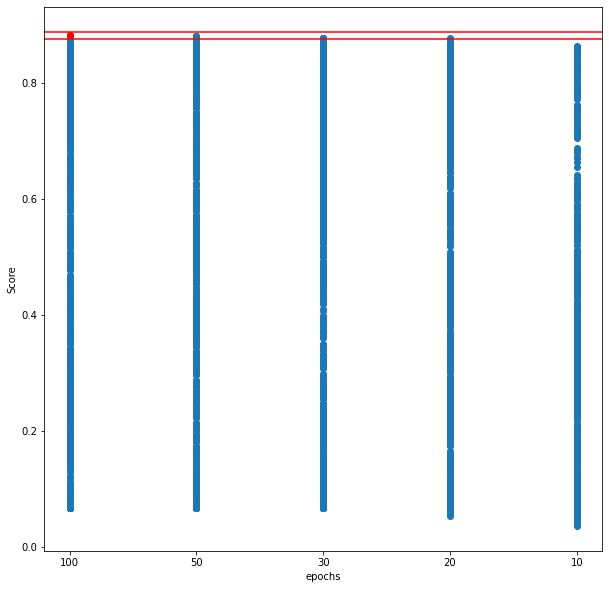

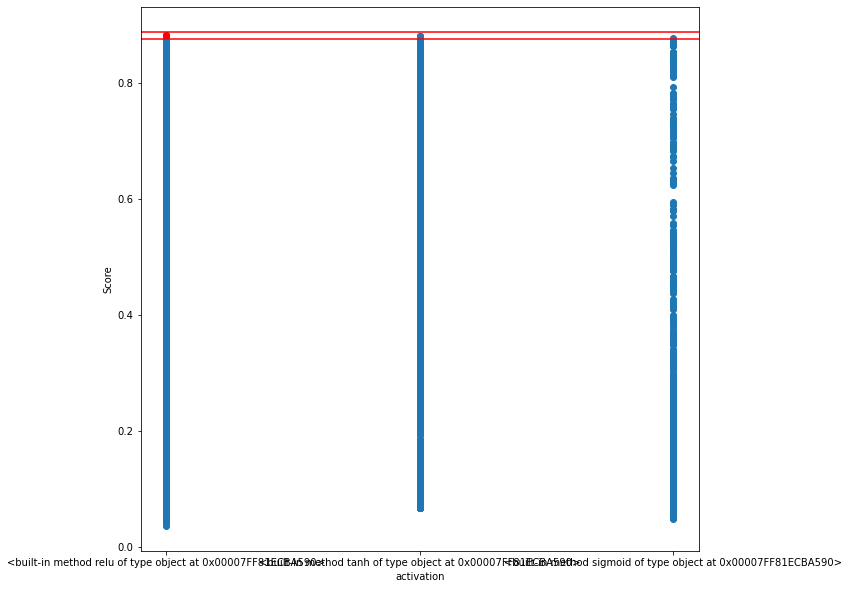

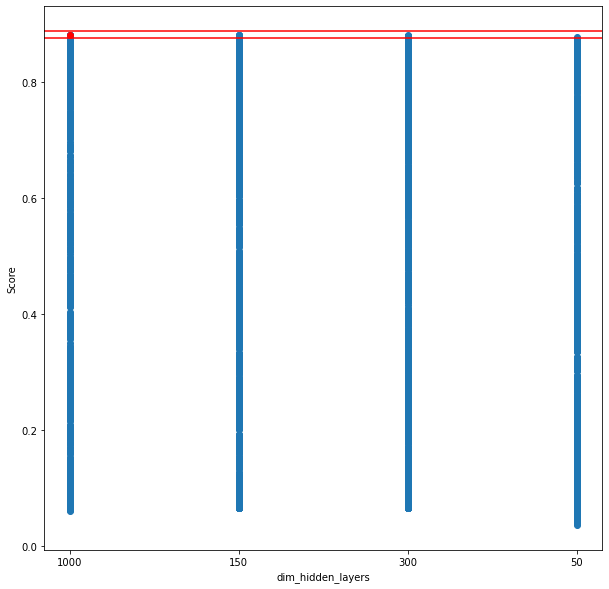

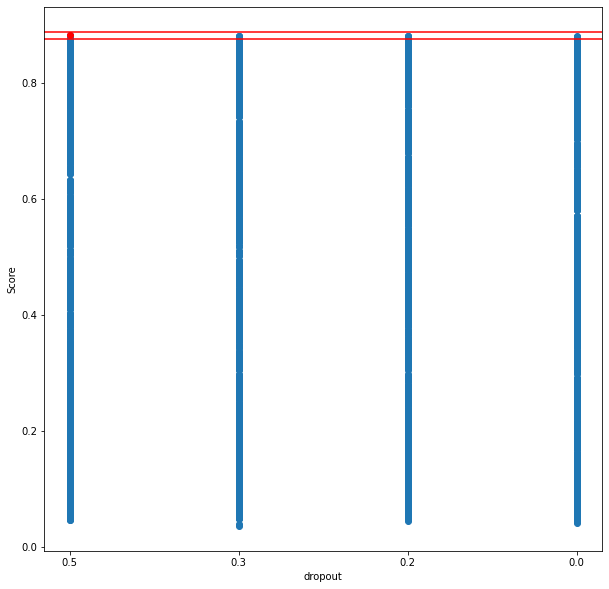

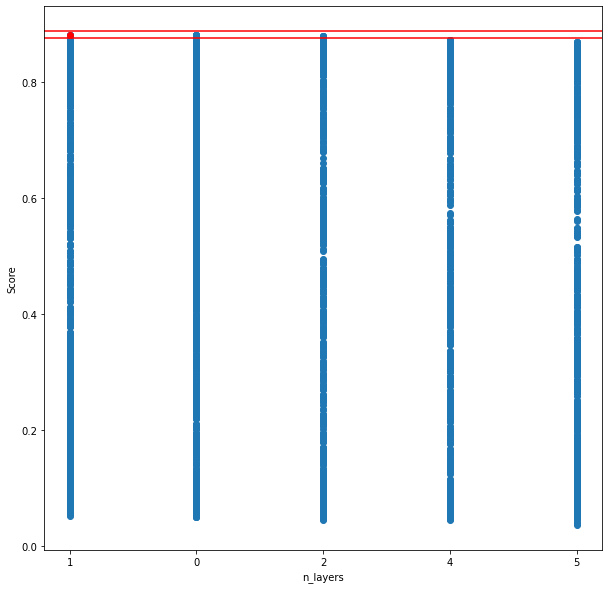

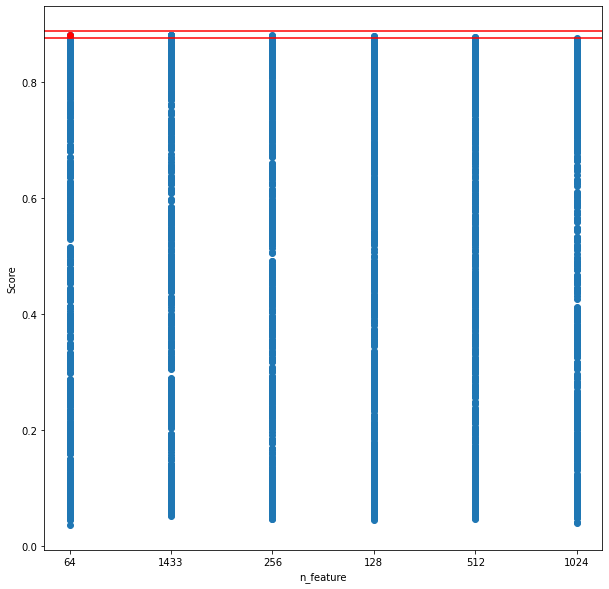

In [19]:
param = pd.read_pickle("./gnn.pkl")
pa=param.sort_values(by=['z_mean_test_score'],ascending=False)

param_list=[	"epochs","activation"	,"dim_hidden_layers",	"dropout",	"n_layers"	,"n_feature"]
scores_df=pa
display(pa.head(15))
best_row = scores_df.iloc[0, :]
best_mean = best_row['z_mean_test_score']
best_stdev = best_row['z_std_test_score']
for param_name in param_list:
    best_param =str( best_row[param_name]) 
    means = scores_df['z_mean_test_score']
    stds = scores_df['z_std_test_score']
    params = scores_df[param_name].astype(str)
    
    plt.figure(figsize=(10, 10))
    plt.plot(params, means,"o")

    plt.axhline(y=best_mean + best_stdev, color='red')
    plt.axhline(y=best_mean - best_stdev, color='red')
    plt.plot(best_param, best_mean, 'or')

    plt.xlabel(param_name)
    plt.ylabel('Score')
plt.show()






In [5]:
class modello(torch.nn.Module):
    def __init__(self,n_feature=1433,n_layers=0,dim_hidden_layers=300,activation=F.relu,dropout=0.2):
        super().__init__()
        
        self.dropout = torch.nn.Dropout(dropout)
        self.dense_layers=torch.nn.ModuleList([MyGCNConv(dim_hidden_layers, dim_hidden_layers) for i in range(n_layers)])
        self.activation=activation
        self.n_layers=n_layers
        self.conv1 = MyGCNConv(n_feature, dim_hidden_layers)
        self.conv2 = MyGCNConv(dim_hidden_layers, 7)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = self.activation(x)
        x=  self.dropout(x)
        for i in range(self.n_layers):
            x = self.dense_layers[i](x,edge_index)
            x = self.activation(x)
            x=  self.dropout(x)
        emb=x
        x = self.conv2(x, edge_index)
        return emb,F.log_softmax(x, dim=1)

## Risultati sul test set

In [8]:
preprocessing={"reduce_dim":PCA,
                "n_components":64}
                

modello_gnn = {
    'n_layers':1,
    'dim_hidden_layers':1000,
    'activation':torch.relu,
    'dropout':0.5,
    'n_feature':64
}

training_migliore={
    "epochs":100,
    "optimizer":torch.optim.Adam,
    "loss":F.nll_loss
}


data=dataset[0].clone()

transform=PCA(n_components=64)
k= transform.fit_transform(data.x.to('cpu'))
data.x =torch.tensor(k,dtype=torch.float32)

model=modello(**modello_gnn).to("cuda")
data.to('cuda')


optimizer=training_migliore['optimizer'](model.parameters())
model.train()
for _ in range(training_migliore['epochs']):
    optimizer.zero_grad()
    _,out = model(data)
    loss=training_migliore['loss'](out[data.train_mask],data.y[data.train_mask])
    loss.backward()
    optimizer.step()

model.eval()
emb,pred = model(data)
pred=pred.argmax(dim=1)

f_test=metrics.f1_score(data.y[data.test_mask].cpu(), pred[data.test_mask].cpu() ,average='macro')
f_train=metrics.f1_score(data.y[data.train_mask].cpu(), pred[data.train_mask].cpu() ,average='macro')

accuracy_test=metrics.accuracy_score(data.y[data.test_mask].cpu(), pred[data.test_mask].cpu())
accuracy_train=metrics.accuracy_score(data.y[data.train_mask].cpu(), pred[data.train_mask].cpu() )
matr=metrics.confusion_matrix(data.y[data.test_mask].cpu(), pred[data.test_mask].cpu())

print(f"accuracy test: {accuracy_test}")

print(f"accuracy train: {accuracy_train}")
print(f"f1 test: {f_test}")
print(f"f1 train: {f_train}")

print(matr)


accuracy test: 0.8872458410351202
accuracy train: 0.9377018920166128
f1 test: 0.8802804527299811
f1 train: 0.931954971292064
[[140   0   1   5   7   0   6]
 [  1  38   0   0   5   0   2]
 [  1   0  40   0   1   2   0]
 [  3   0   1  85   4   0   0]
 [  6   1   2   0  55   0   1]
 [  3   0   0   0   0  79   1]
 [  0   1   2   2   2   1  43]]


## Visualizzazioni delle embeddings calcolate

### Plot delle embeddings nel traning set

C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


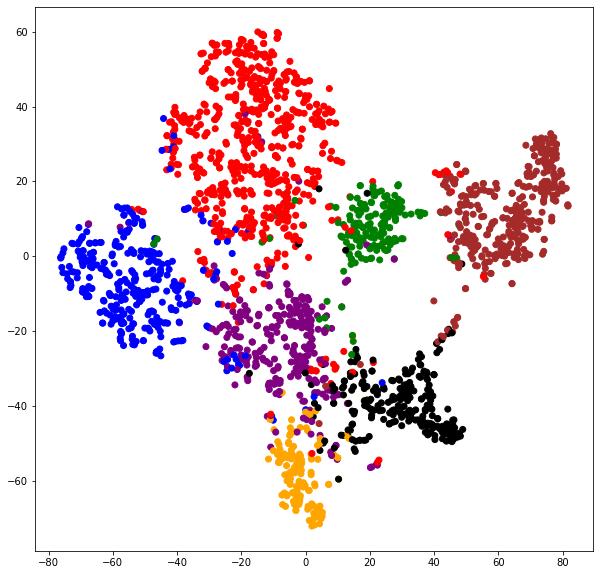

In [28]:
xs, ys = compute_TSNE(emb.cpu())

plot_embeddings(xs[data.train_mask],ys[data.train_mask],data.y[data.train_mask].cpu())

### Plot delle embeddings nel test set

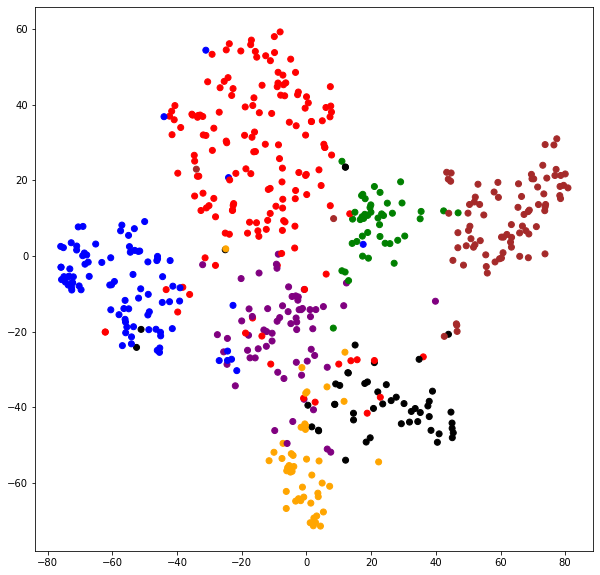

In [29]:
plot_embeddings(xs[data.test_mask],ys[data.test_mask],data.y[data.test_mask].cpu())

### Plot delle embeddings calcolate in ogni epoca

In [ ]:
#plot delle embeddings per ogni epoca
def plot_all_epoch_embeddings(): 
    color_list = ["red", "orange", "green", "blue", "purple", "brown","black","gray","yellow"]
    i=0
    for emb in embeddings:
        embs = []
        colors = []
        embs.append(emb.cpu())
        yl=data.y
        colors += [color_list[y] for y in yl]
        embs = torch.cat(embs, dim=0)
        xs, ys = zip(*TSNE(init='pca',random_state=33).fit_transform(embs.detach().numpy()))
        plt.scatter(xs, ys, color=colors)
        plt.savefig(f'./embeddings_scatter/epoch{i}.png')
        plt.close()
        i=i+1

from IPython.display import Image, display
for x in range(0,10):
    display(Image( f'./embeddings_scatter/epoch{x}.png'))


# Graph auto encoders 
Con i grpah auto encoder possiamo apprendere le rappresentazioni dei nodi in modo non supervisionato (usiamo esclusivamente gli archi).
Contrariamente all'esempio precedente, non utilizziamo le labels dei nodi fornite durante l'addestramento. Invece, codifichiamo i nodi del grafo  in modo tale che le embedding dei nodi possono essere decodificate come ricostrizione del grafo originale. 
Usiamo usimo lo stesso layer del metodo precedente.

In [36]:


dataset=MyDatasetLoader(root='./cora')
data=dataset[0]


class Encoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
        self.conv1 = MyGCNConv(in_channels,  out_channels*2)
        self.conv2 = MyGCNConv(out_channels*2, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)




dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
channels = 30
model = pyg_nn.GAE(Encoder(dataset.num_features, channels)).to(dev)
labels = data.y
data.train_mask = data.val_mask = data.test_mask = data.y = None
#il metodo train_test_split_edges()
#divide gli archi del grafo in positivi e nagativi nei rispettivi train/val/test. 
randomSplit_links =  pyg_utils.train_test_split_edges(data)


Processing...
Done!
C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\torch_geometric\deprecation.py:13: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


## Training  Graph auto encoders 

in traing è simile al precedente ma cambia la funzione di loss recon_loss() che calcola
la binary cross entropy loss per gli archi positivi e nagetivi estratti mediante sampling (gli archi negativi a.k.a inesitenti vengono estratti allinterno di recon_loss(),  comunque possibile passaglierli in input) 

In [82]:
def accuracy_f1_confusion_link_prediction(model,X, train_pos_edge_index,pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(X, train_pos_edge_index)
        pos_y = z.new_ones(pos_edge_index.size(1))
        neg_y = z.new_zeros(neg_edge_index.size(1))
        y = torch.cat([pos_y, neg_y], dim=0)
        pos_pred = model.decoder(z, pos_edge_index, sigmoid=True)
        neg_pred = model.decoder(z, neg_edge_index, sigmoid=True)

        pred = torch.cat([pos_pred, neg_pred], dim=0)
        pred = torch.as_tensor((pred - 0.70) > 0, dtype=torch.int32) 

        y, pred = y.detach().cpu().numpy(), pred.detach().cpu().numpy()
        
        acc=metrics.accuracy_score(y, pred)
        f=metrics.f1_score(y, pred)
        confmatr=metrics.confusion_matrix(y, pred)
        return acc,f,confmatr

def train_gae(dataset,train_args,model_args,model,device):    
    model=pyg_nn.GAE(model(**model_args)).to(device)
    #dataset.train_pos_edge_index.to(device)
    optimizer=train_args['optimizer'](model.parameters())
    model.train()
    for _ in range(train_args['epochs']):
        optimizer.zero_grad()
        out = model.encode(dataset.x,dataset.train_pos_edge_index)
        loss = model.recon_loss(out,dataset.train_pos_edge_index)
        loss.backward()
        optimizer.step()

    _,f1,_=accuracy_f1_confusion_link_prediction(model,dataset.x,dataset.train_pos_edge_index, dataset.test_pos_edge_index, dataset.test_neg_edge_index)

    return f1

def gridSearch_gae(dataset,preprocessing,parametri_training,parametri_modello,modello):
    
    results=[]
    for pre in ParameterGrid(preprocessing):
        data=dataset.clone()
        if pre['reduce_dim']=='passthrough':
            pass
        else:
            
            reduction=pre['reduce_dim']
            del pre['reduce_dim']
            red=reduction(**pre)
            k= red.fit_transform(data.x.to('cpu'))
            data.x =torch.tensor(k,dtype=torch.float32)

        feature_len=len(data.x[0])
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        #device='cpu'
        
        print(feature_len)
        data = data.to(device)
        for tra in ParameterGrid(parametri_training):
            for mod in ParameterGrid(parametri_modello):
                mod['n_feature']=feature_len
                f1_test=train_gae(
                        dataset=data,
                        train_args=tra,
                        model_args=mod,
                        model=modello,
                        device=device)

                dic_score={'z_test_score':f1_test }
                rec=dict(**tra,**mod, **dic_score)
            
                results.append(rec)
    dataframe=pd.DataFrame(results)
    
    return  dataframe




In [79]:

class Encoder(torch.nn.Module):
    def __init__(self, n_feature=1433,n_layers=0,dim_hidden_layers=300,activation=F.relu,dropout=0.2):
        super(Encoder, self).__init__()
        self.dropout = torch.nn.Dropout(dropout)
        self.dense_layers=torch.nn.ModuleList([MyGCNConv(dim_hidden_layers, dim_hidden_layers) for i in range(n_layers)])
        self.activation=activation
        self.n_layers=n_layers
        self.conv1 = MyGCNConv(n_feature, dim_hidden_layers)
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        for i in range(self.n_layers):
            x = self.activation(x)
            x=  self.dropout(x)
            x = self.dense_layers[i](x,edge_index)

        return x


In [43]:



preprocessing=[{"reduce_dim":[PCA],
                "n_components":[64,128,256,512,1024]},
                
                {"reduce_dim": ["passthrough"]}]

parametri_modello = {
    'n_layers':[0,1,2,4,5],
    'dim_hidden_layers':[50,150,300,1000],
    'activation':[ torch.relu ,torch.sigmoid,torch.tanh],
    'dropout':[0,0.2,0.3,0.5]
}

parametri_training={
    "epochs":[10,20,30,50,100],
    "optimizer":[torch.optim.Adam],
    "loss":[F.nll_loss]
}


data =randomSplit_links =  pyg_utils.train_test_split_edges(dataset[0].clone())
data.train_mask = data.val_mask = data.test_mask = data.y = None

param=gridSearch_gae(dataset=data,
        modello=Encoder,
        preprocessing=preprocessing,
        parametri_training=parametri_training,
        parametri_modello=parametri_modello)

param.to_pickle("gae.pkl")

C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\torch_geometric\deprecation.py:13: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


64
128
256
512
1024
1433


epochs                                       loss  \
5435      30  <function nll_loss at 0x0000024E9E572040>   
5340      30  <function nll_loss at 0x0000024E9E572040>   
6715      30  <function nll_loss at 0x0000024E9E572040>   
5500      30  <function nll_loss at 0x0000024E9E572040>   
4450      50  <function nll_loss at 0x0000024E9E572040>   
5185      20  <function nll_loss at 0x0000024E9E572040>   
6635      30  <function nll_loss at 0x0000024E9E572040>   
5570      50  <function nll_loss at 0x0000024E9E572040>   
5180      20  <function nll_loss at 0x0000024E9E572040>   
6990     100  <function nll_loss at 0x0000024E9E572040>   
1421      10  <function nll_loss at 0x0000024E9E572040>   
5720      50  <function nll_loss at 0x0000024E9E572040>   
5430      30  <function nll_loss at 0x0000024E9E572040>   
5260      20  <function nll_loss at 0x0000024E9E572040>   
3411     100  <function nll_loss at 0x0000024E9E572040>   

                            optimizer  \
5435  <class 'torch.optim.adam.Adam'>   
5340  <class 'torch.optim.adam.Adam'>   
6715  <class 'torch.optim.adam.Adam'>   
5500  <class 'torch.optim.adam.Adam'>   
4450  <class 'torch.optim.adam.Adam'>   
5185  <class 'torch.optim.adam.Adam'>   
6635  <class 'torch.optim.adam.Adam'>   
5570  <class 'torch.optim.adam.Adam'>   
5180  <class 'torch.optim.adam.Adam'>   
6990  <class 'torch.optim.adam.Adam'>   
1421  <class 'torch.optim.adam.Adam'>   
5720  <class 'torch.optim.adam.Adam'>   
5430  <class 'torch.optim.adam.Adam'>   
5260  <class 'torch.optim.adam.Adam'>   
3411  <class 'torch.optim.adam.Adam'>   

                                             activation  dim_hidden_layers  \
5435  <built-in method sigmoid of type object at 0x0...               1000   
5340  <built-in method relu of type object at 0x0000...               1000   
6715  <built-in method tanh of type object at 0x0000...               1000   
5500  <built-in method tanh of type object at 0x0000...               1000   
4450  <built-in method sigmoid of type object at 0x0...                300   
5185  <built-in method sigmoid of type object at 0x0...               1000   
6635  <built-in method sigmoid of type object at 0x0...               1000   
5570  <built-in method relu of type object at 0x0000...                300   
5180  <built-in method sigmoid of type object at 0x0...               1000   
6990  <built-in method relu of type object at 0x0000...                150   
1421  <built-in method tanh of type object at 0x0000...               1000   
5720  <built-in method tanh of type object at 0x0000...                300   
5430  <built-in method sigmoid of type object at 0x0...               1000   
5260  <built-in method tanh of type object at 0x0000...               1000   
3411  <built-in method relu of type object at 0x0000...                300   

      dropout  n_layers  n_feature  z_test_score  
5435      0.5         0       1024      0.891892  
5340      0.0         0       1024      0.890595  
6715      0.5         0       1433      0.884393  
5500      0.0         0       1024      0.884170  
4450      0.3         0        512      0.883988  
5185      0.2         0       1024      0.883988  
6635      0.5         0       1433      0.883946  
5570      0.3         0       1024      0.883317  
5180      0.0         0       1024      0.883142  
6990      0.3         0       1433      0.882865  
1421      0.0         1        128      0.882722  
5720      0.0         0       1024      0.882466  
5430      0.3         0       1024      0.882012  
5260      0.0         0       1024      0.881226  
3411      0.3         1        256      0.880998

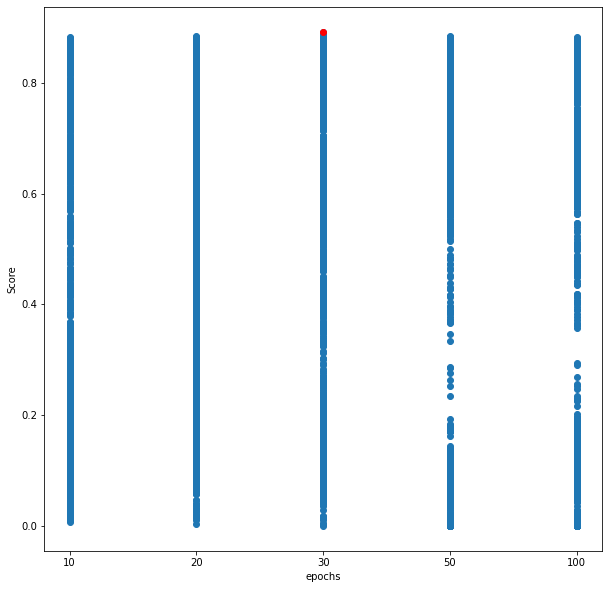

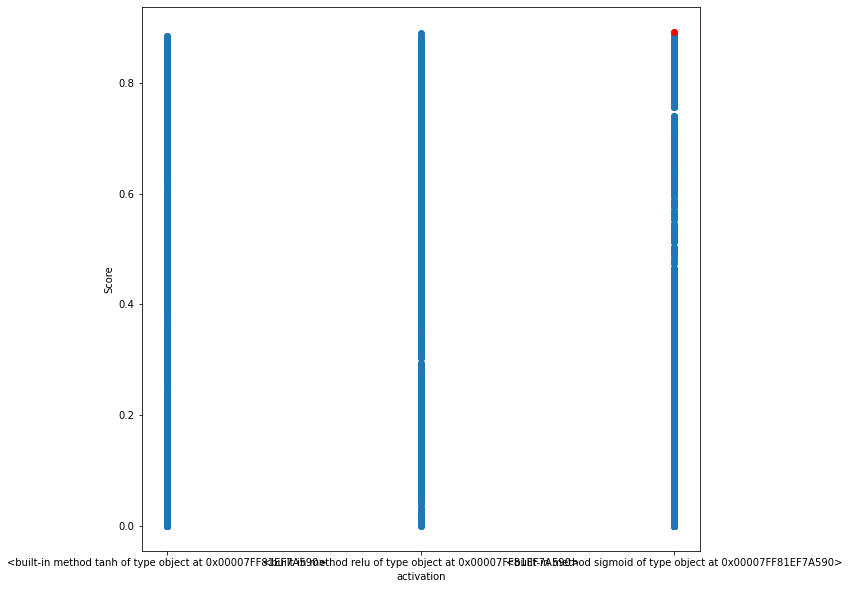

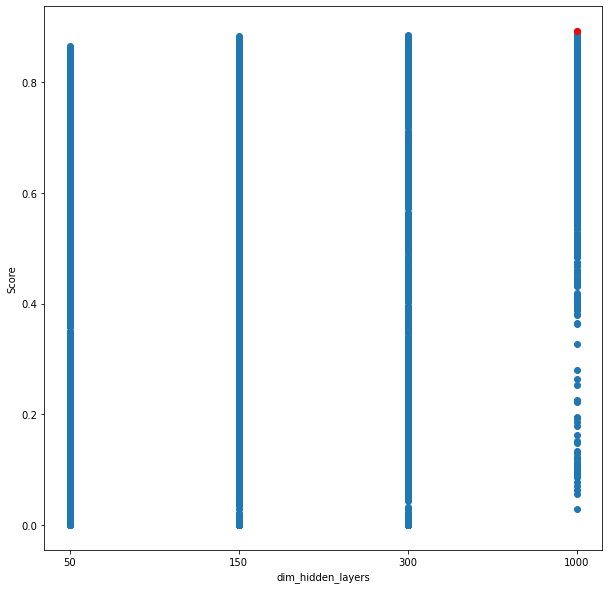

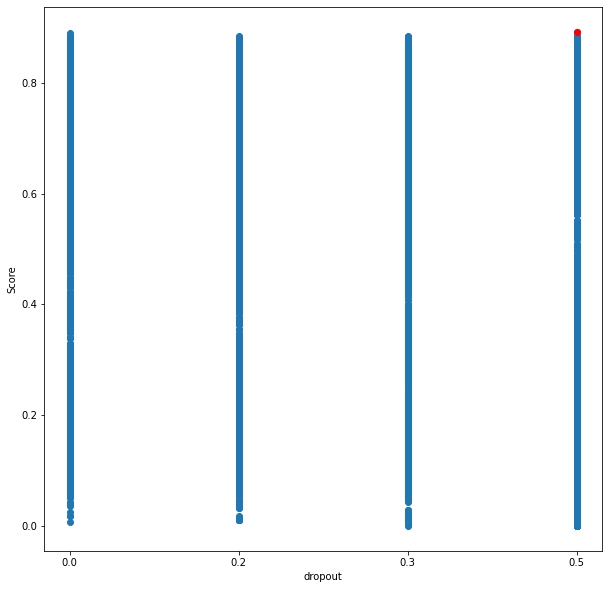

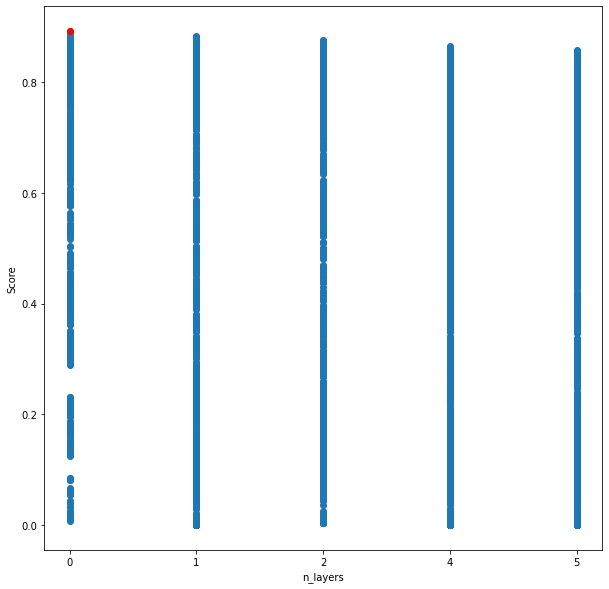

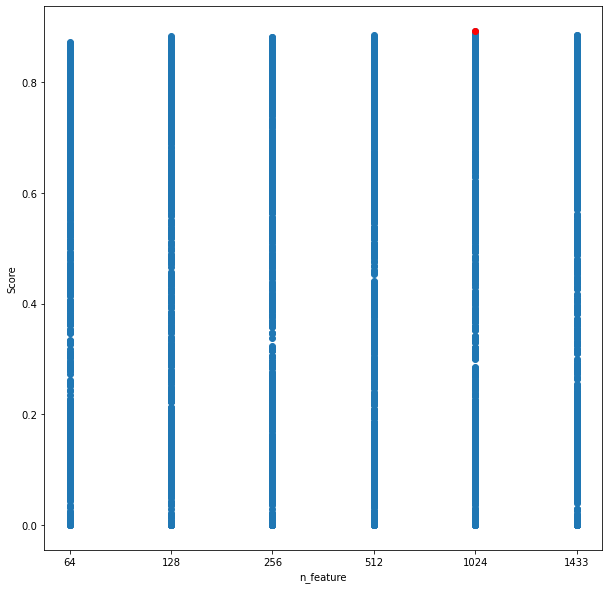

In [56]:
pa=param.sort_values(by=['z_test_score'],ascending=False)


param_list=[	"epochs","activation"	,"dim_hidden_layers",	"dropout",	"n_layers"	,"n_feature"]
scores_df=pa
display(pa.head(15))
best_row = scores_df.iloc[0, :]
best_mean = best_row['z_test_score']

for param_name in param_list:
    try:
        scores_df = scores_df.sort_values(param_name)
    except:
        pass
    best_param =str( best_row[param_name]) 
    means = scores_df['z_test_score']
    params = scores_df[param_name].astype(str)
    
    plt.figure(figsize=(10, 10))
    plt.plot(params, means,"o")
    plt.plot(best_param, best_mean, 'or')

    plt.xlabel(param_name)
    plt.ylabel('Score')
plt.show()



In [83]:
preprocessing=[{"reduce_dim":PCA,
                "n_components":1024},
                
                {"reduce_dim": ["passthrough"]}]

modello_gae = {
    'n_layers':0,
    'dim_hidden_layers':1000,
    'activation':torch.sigmoid,
    'dropout':0.5,
    "n_feature":1024
}

training_gae={
    "epochs":30,
    "optimizer":torch.optim.Adam,
    "loss":F.nll_loss
}


data = randomSplit_links =  pyg_utils.train_test_split_edges(dataset[0].clone())

red=PCA(n_components=1024)
k= red.fit_transform(data.x.to('cpu'))
data.x =torch.tensor(k,dtype=torch.float32)

data.to('cuda')
model=pyg_nn.GAE(Encoder(**modello_gae)).to('cuda')
#dataset.train_pos_edge_index.to(device)
optimizer=training_gae['optimizer'](model.parameters())
model.train()
for _ in range(training_gae['epochs']):
    optimizer.zero_grad()
    out = model.encode(data.x,data.train_pos_edge_index)
    loss = model.recon_loss(out,data.train_pos_edge_index)
    loss.backward()
    optimizer.step()

accuracy,f1,matr=accuracy_f1_confusion_link_prediction(model,data.x,data.train_pos_edge_index, data.test_pos_edge_index, data.test_neg_edge_index)
print(f"accuracy: { accuracy}")
print(f"f1: {f1}")
print(matr)

C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\torch_geometric\deprecation.py:13: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


accuracy: 0.8911439114391144
f1: 0.8874045801526718
[[501  41]
 [ 77 465]]


## Plot delle embedding ricalcolate con GAE

C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


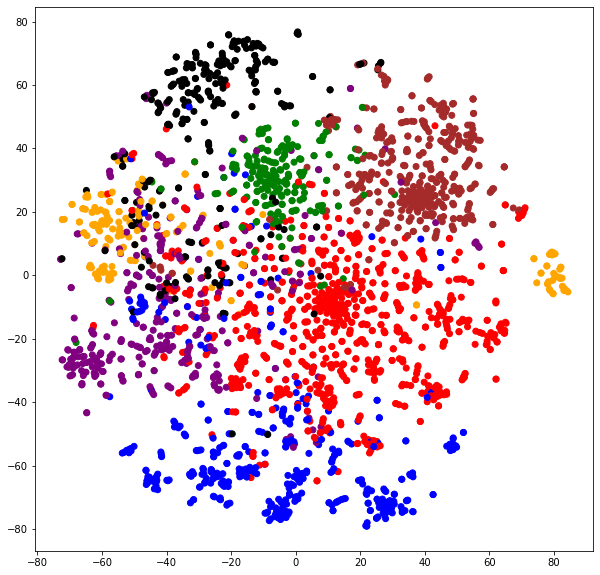

In [84]:
model.eval()
embeddings_auto_encoders = model.encode(data.x, data.train_pos_edge_index)
xs,ys=compute_TSNE(embeddings_auto_encoders.cpu())
plot_embeddings(xs,ys,dataset[0].y)

# Prova dei vai modelli con le  con embeddings ricalcolate con GNN nel task di predizione della label del nodo

In [48]:
#eseguire questa cella per usare le embedding calcolate con GCN neli modelli successivi

train_x=emb[data.train_mask].cpu().detach().numpy()
train_y=data.y[data.train_mask].cpu().detach().numpy()
test_x=emb[data.test_mask].cpu().detach().numpy()
test_y=data.y[data.test_mask].cpu().detach().numpy()
dict_valutazioni={}

data=dataset[0]
data.x=emb

## Logistic regression con embeddings ricalcolate da GNN

In [14]:
pipe = Pipeline([("reduce_dim", "passthrough"),
                 ('logisticregression', LogisticRegression())])

parametri=       {
                    "reduce_dim": ["passthrough"],
                    "logisticregression__penalty":['l1', 'l2', 'elasticnet', 'none'],
                    "logisticregression__solver":['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                    "logisticregression__C": [0.1,0.5,1,10,50,100]
                }
            
        

grid = GridSearchCV(pipe, n_jobs=-1, param_grid=parametri,cv=5,scoring='f1_macro',return_train_score=True)
grid.fit(train_x,train_y)

print("tuned hpyerparameters :(best parameters) ",grid.best_params_)

C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
270 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit


tuned hpyerparameters :(best parameters)  {'logisticregression__C': 0.5, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'saga', 'reduce_dim': 'passthrough'}


C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


best parameters: {'logisticregression__C': 0.5, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'saga', 'reduce_dim': 'passthrough'}
best score:      0.92932 (+/-0.01300)


param_logisticregression__C param_logisticregression__penalty  \
24                          0.5                                l1   
7                           0.1                                l2   
2                           0.1                                l1   
22                          0.5                                l1   
44                            1                                l1   
4                           0.1                                l1   
27                          0.5                                l2   
29                          0.5                                l2   
64                           10                                l1   
119                         100                              none   
9                           0.1                                l2   
42                            1                                l1   
69                           10                                l2   
84                           50                                l1   
49                            1                                l2   
89                           50                                l2   
99                           50                              none   
109                         100                                l2   
79                           10                              none   
59                            1                              none   
19                          0.1                              none   
104                         100                                l1   
39                          0.5                              none   
18                          0.1                              none   
118                         100                              none   
88                           50                                l2   
68                           10                                l2   
8                           0.1                                l2   
38                          0.5                              none   
28                          0.5                                l2   
48                            1                                l2   
58                            1                              none   
98                           50                              none   
78                           10                              none   
108                         100                                l2   
47                            1                                l2   
6                           0.1                                l2   
5                           0.1                                l2   
25                          0.5                                l2   
26                          0.5                                l2   

    param_logisticregression__solver  mean_test_score  std_test_score  \
24                              saga         0.929318        0.012998   
7                          liblinear         0.928886        0.013686   
2                          liblinear         0.928385        0.012424   
22                         liblinear         0.926893        0.014484   
44                              saga         0.926542        0.012030   
4                               saga         0.925764        0.014056   
27                         liblinear         0.924221        0.018292   
29                              saga         0.923733        0.013051   
64                              saga         0.923733        0.013051   
119                             saga         0.923733        0.013051   
9                               saga         0.923733        0.013051   
42                         liblinear         0.923556        0.015173   
69                              saga         0.922944        0.014193   
84                              saga         0.922944        0.014193   
49                              saga         0.922944        0.014193   
89    

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_logisticregression__C', 'param_logisticregression__penalty',
       'param_logisticregression__solver', 'param_reduce_dim', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'split3_train_score',
       'split4_train_score', 'mean_train_score', 'std_train_score'],
      dtype='object')


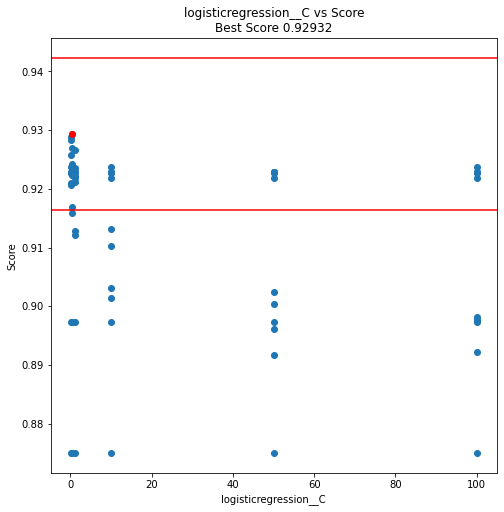

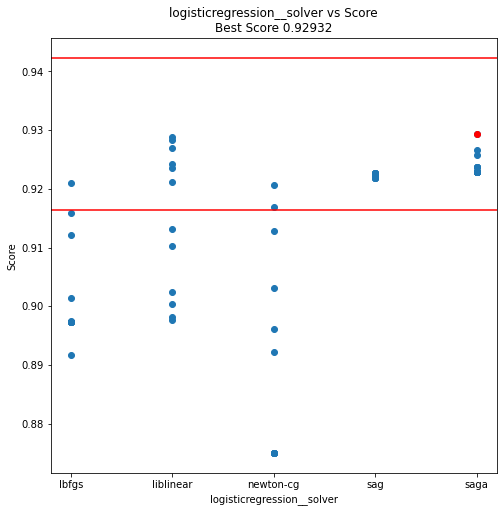

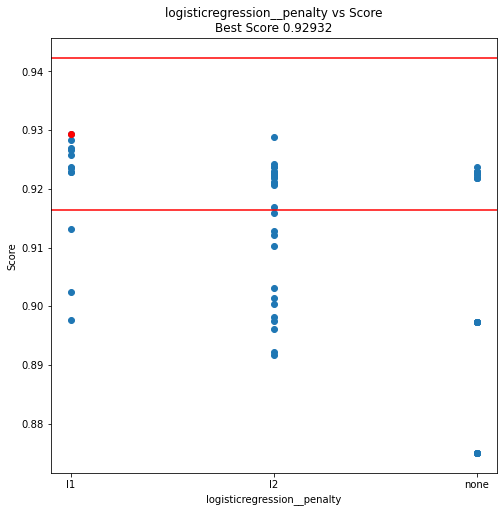

In [17]:
GridSearch_table_plot(grid, param_list=['logisticregression__C','logisticregression__solver',"logisticregression__penalty"],negative=False)


In [18]:
print(grid.best_params_)
model=grid.best_estimator_
model.fit(train_x,train_y)
model = model.fit(train_x,train_y)
y_pred = model.predict(test_x)
test_valutation=valutate_test(test_y,y_pred)
dict_valutazioni['LogisticRegression']={"test":test_valutation}
print("Logostic Regression")
print( f"Accuracy: {test_valutation['Accuracy']}")
print( f"Macro f1: {test_valutation['f1']}")
print(f"Confusion Matrix:\n {test_valutation['Confusion Matrix']}")

{'logisticregression__C': 0.5, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'saga', 'reduce_dim': 'passthrough'}


C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logostic Regression
Accuracy: 0.878003696857671
Macro f1: 0.8667236737703478
Confusion Matrix:
 [[140   0   1   5   7   0   6]
 [  2  35   0   0   6   1   2]
 [  1   0  40   0   1   2   0]
 [  2   0   1  87   3   0   0]
 [  6   2   1   0  55   1   0]
 [  4   0   0   0   0  78   1]
 [  1   1   3   2   3   1  40]]


C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## Linear Discriminant Analysis con embeddings ricalcolate da GNN

In [19]:
pipe = Pipeline([("reduce_dim", "passthrough"),
                 ('LinearDiscriminantAnalysis',LinearDiscriminantAnalysis(store_covariance=True))])

parametri=  [

                {
                    "reduce_dim": ["passthrough"],
                    "LinearDiscriminantAnalysis__solver":['svd', 'lsqr', 'eigen'],
                }
            ]
        

grid = GridSearchCV(pipe, n_jobs=-1, param_grid=parametri,cv=5,scoring='f1_macro',return_train_score=True)
grid.fit(train_x,train_y)

print("tuned hpyerparameters :(best parameters) ",grid.best_params_)

C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\discriminant_analysis.py", line 599, in fit
    se

tuned hpyerparameters :(best parameters)  {'LinearDiscriminantAnalysis__solver': 'svd', 'reduce_dim': 'passthrough'}


best parameters: {'LinearDiscriminantAnalysis__solver': 'svd', 'reduce_dim': 'passthrough'}
best score:      0.82503 (+/-0.03396)


param_LinearDiscriminantAnalysis__solver  mean_test_score  std_test_score  \
0                                      svd         0.825029        0.033957   
1                                     lsqr         0.825029        0.033957   
2                                    eigen              NaN             NaN   

   rank_test_score  mean_train_score  std_train_score  
0                1          0.982789         0.001669  
1                1          0.982789         0.001669  
2                3               NaN              NaN

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_LinearDiscriminantAnalysis__solver', 'param_reduce_dim',
       'params', 'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'split3_train_score',
       'split4_train_score', 'mean_train_score', 'std_train_score'],
      dtype='object')


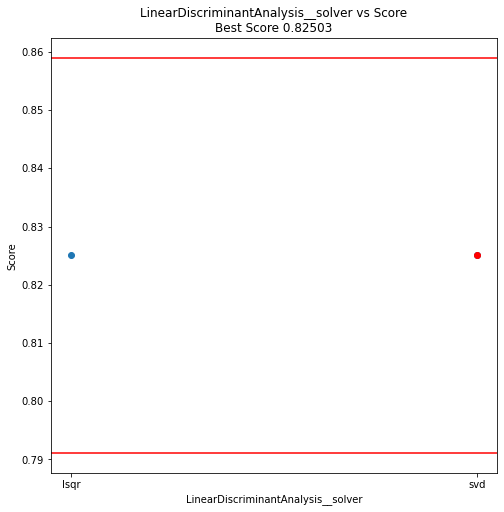

In [20]:
GridSearch_table_plot(grid, param_list=['LinearDiscriminantAnalysis__solver'],negative=False)


In [21]:
print(grid.best_params_)
model=grid.best_estimator_
model.fit(train_x,train_y)
model = model.fit(train_x,train_y)
y_pred = model.predict(test_x)
test_valutation=valutate_test(test_y,y_pred)
dict_valutazioni['LinearDiscriminantAnalysis']={"test":test_valutation}
print("Linear Discriminant Analysis")
print( f"Accuracy: {test_valutation['Accuracy']}")
print( f"Macro f1: {test_valutation['f1']}")
print(f"Confusion Matrix:\n {test_valutation['Confusion Matrix']}")

{'LinearDiscriminantAnalysis__solver': 'svd', 'reduce_dim': 'passthrough'}
Linear Discriminant Analysis
Accuracy: 0.8558225508317929
Macro f1: 0.8419045406843971
Confusion Matrix:
 [[139   0   2   5   8   0   5]
 [  2  33   0   0   8   0   3]
 [  1   0  39   1   1   2   0]
 [  3   0   1  86   3   0   0]
 [  5   2   1   1  55   1   0]
 [  6   0   0   0   0  76   1]
 [  5   1   2   3   4   1  35]]


## Quadratic Discriminant Analysis con embeddings ricalcolate da GNN

In [22]:
pipe = Pipeline([("reduce_dim", "passthrough"),
                 ('LinearDiscriminantAnalysis',QuadraticDiscriminantAnalysis(store_covariance=True))])
parametri=  [
                {
                    "reduce_dim": ["passthrough"],  
                }
            ]
        

grid = GridSearchCV(pipe, n_jobs=-1, param_grid=parametri,cv=5,scoring='f1_macro',return_train_score=True)
grid.fit(train_x,train_y)

print("tuned hpyerparameters :(best parameters) ",grid.best_params_)

C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tuned hpyerparameters :(best parameters)  {'reduce_dim': 'passthrough'}


In [24]:
print(grid.best_params_)
model=grid.best_estimator_
model.fit(train_x,train_y)
model = model.fit(train_x,train_y)
y_pred = model.predict(test_x)
test_valutation=valutate_test(test_y,y_pred)
dict_valutazioni['QuadraticDiscriminantAnalysis']={"test":test_valutation}
print("Quadratic Discriminant Analysis")
print( f"Accuracy: {test_valutation['Accuracy']}")
print( f"Macro f1: {test_valutation['f1']}")
print(f"Confusion Matrix:\n {test_valutation['Confusion Matrix']}")

{'reduce_dim': 'passthrough'}


C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Quadratic Discriminant Analysis
Accuracy: 0.36968576709796674
Macro f1: 0.4001317855051426
Confusion Matrix:
 [[ 26   0   2   1 128   0   2]
 [  0  11   0   0  35   0   0]
 [  0   0   9   0  34   1   0]
 [  0   0   0  37  56   0   0]
 [  0   0   4   0  61   0   0]
 [  0   0   7   0  30  46   0]
 [  0   0   0   0  41   0  10]]


## K Neighbors Classifier con embeddings ricalcolate da GNN

In [25]:
pipe = Pipeline([("reduce_dim", "passthrough"),
                 ('KNeighborsClassifier', KNeighborsClassifier())])

parametri=  [
                {
                    "reduce_dim": ["passthrough"],
                    "KNeighborsClassifier__weights":['uniform', 'distance'],
                    "KNeighborsClassifier__n_neighbors":[1,3,5,10,20],
                    "KNeighborsClassifier__p":[0.5, 1,2,4,8,50,100]
                    
                }
            ]
        

grid = GridSearchCV(pipe, n_jobs=-1, param_grid=parametri,cv=5,scoring='f1_macro',return_train_score=True)
grid.fit(train_x,train_y)

print("tuned hpyerparameters :(best parameters) ",grid.best_params_)

tuned hpyerparameters :(best parameters)  {'KNeighborsClassifier__n_neighbors': 20, 'KNeighborsClassifier__p': 2, 'KNeighborsClassifier__weights': 'uniform', 'reduce_dim': 'passthrough'}


C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
50 fits failed out of a total of 350.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\neighbors\_classification.py", line 198, in fit

best parameters: {'KNeighborsClassifier__n_neighbors': 20, 'KNeighborsClassifier__p': 2, 'KNeighborsClassifier__weights': 'uniform', 'reduce_dim': 'passthrough'}
best score:      0.92166 (+/-0.02285)


param_KNeighborsClassifier__n_neighbors param_KNeighborsClassifier__p  \
60                                      20                             2   
58                                      20                             1   
62                                      20                             4   
61                                      20                             2   
64                                      20                             8   
63                                      20                             4   
46                                      10                             2   
59                                      20                             1   
65                                      20                             8   
44                                      10                             1   
67                                      20                            50   
69                                      20                           100   
47                                      10                             2   
68                                      20                           100   
66                                      20                            50   
49                                      10                             4   
48                                      10                             4   
45                                      10                             1   
50                                      10                             8   
37                                       5                             8   
54                                      10                           100   
51                                      10                             8   
34                                       5                             4   
33                                       5                             2   
35                                       5                             4   
31                                       5                             1   
30                                       5                             1   
52                                      10                            50   
32                                       5                             2   
55                                      10                           100   
36                                       5                             8   
53                                      10                            50   
39                                       5                            50   
41                                       5                           100   
38                                       5                            50   
40                                       5                           100   
20                                       3                             4   
17                                       3                             1   
16                                       3                             1   
26                                       3                           100   

   param_KNeighborsClassifier__weights  mean_test_score  std_test_score  \
60                             uniform         0.921663        0.022845   
58                             uniform         0.917998        0.022303   
62                             uniform         0.916892        0.021547   
61                            distance         0.916275        0.021384   
64                             uniform         0.914560        0.023865   
63                            distance         0.914145        0.020109   
46                             uniform         0.913640        0.016674   
59                            distance         0.912983        0.020012   
65                            distance         0.912217        0.022520   
44                             uniform         0.911761        0.017957   
67                            distance         0.910775      

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_KNeighborsClassifier__n_neighbors',
       'param_KNeighborsClassifier__p', 'param_KNeighborsClassifier__weights',
       'param_reduce_dim', 'params', 'split0_test_score', 'split1_test_score',
       'split2_test_score', 'split3_test_score', 'split4_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score',
       'split0_train_score', 'split1_train_score', 'split2_train_score',
       'split3_train_score', 'split4_train_score', 'mean_train_score',
       'std_train_score'],
      dtype='object')


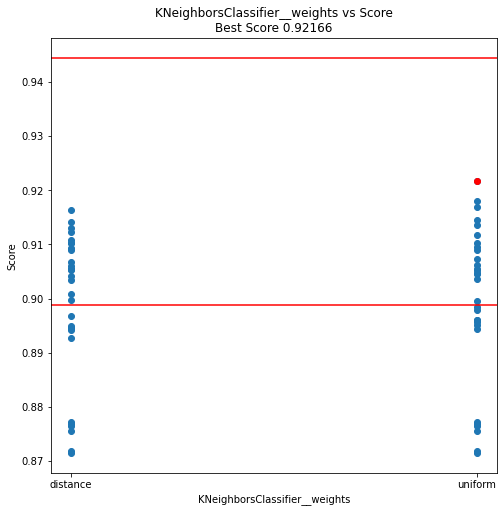

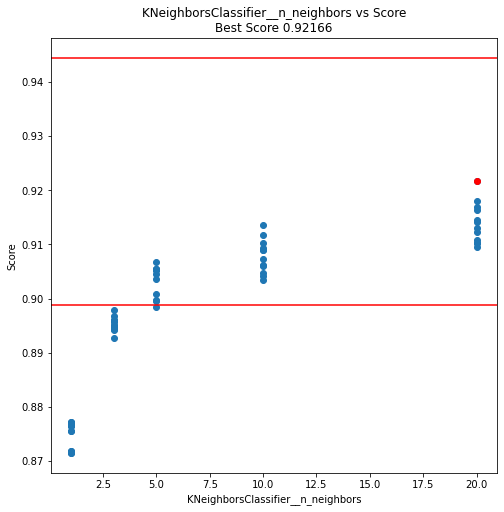

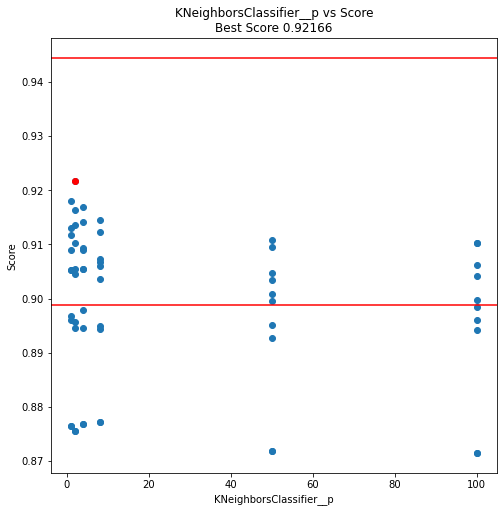

In [26]:
GridSearch_table_plot(grid, param_list=["KNeighborsClassifier__weights","KNeighborsClassifier__n_neighbors","KNeighborsClassifier__p"],negative=False)

In [27]:
print(grid.best_params_)
model=grid.best_estimator_
model.fit(train_x,train_y)
model = model.fit(train_x,train_y)
y_pred = model.predict(test_x)
test_valutation=valutate_test(test_y,y_pred)
dict_valutazioni['KNeighborsClassifier']={"test":test_valutation}
print("K-Neighbors Classifier")
print( f"Accuracy: {test_valutation['Accuracy']}")
print( f"Macro f1: {test_valutation['f1']}")
print(f"Confusion Matrix:\n {test_valutation['Confusion Matrix']}")

{'KNeighborsClassifier__n_neighbors': 20, 'KNeighborsClassifier__p': 2, 'KNeighborsClassifier__weights': 'uniform', 'reduce_dim': 'passthrough'}
K-Neighbors Classifier
Accuracy: 0.8817005545286506
Macro f1: 0.8709492210523759
Confusion Matrix:
 [[142   0   1   5   6   0   5]
 [  2  36   0   0   8   0   0]
 [  1   0  40   0   1   2   0]
 [  2   0   1  85   5   0   0]
 [  4   2   1   0  56   1   1]
 [  2   0   1   0   0  80   0]
 [  3   1   0   2   6   1  38]]


## Decision Tree Classifer con embeddings ricalcolate da GNN

In [28]:
pipe = Pipeline([("reduce_dim", "passthrough"),
                 ('DecisionTreeClassifier', DecisionTreeClassifier())])

parametri=  [
                {
                    "reduce_dim": ["passthrough"],
                    "DecisionTreeClassifier__criterion":['gini','entropy'],
                    "DecisionTreeClassifier__max_depth":[4,8,16,32,64,128,256]
                    
                }
            ]
        

grid = GridSearchCV(pipe, n_jobs=-1, param_grid=parametri,cv=5,scoring='f1_macro',return_train_score=True)
grid.fit(train_x,train_y)

print("tuned hpyerparameters :(best parameters) ",grid.best_params_)

tuned hpyerparameters :(best parameters)  {'DecisionTreeClassifier__criterion': 'entropy', 'DecisionTreeClassifier__max_depth': 32, 'reduce_dim': 'passthrough'}


best parameters: {'DecisionTreeClassifier__criterion': 'entropy', 'DecisionTreeClassifier__max_depth': 32, 'reduce_dim': 'passthrough'}
best score:      0.87445 (+/-0.02527)


param_DecisionTreeClassifier__criterion  \
10                                 entropy   
11                                 entropy   
1                                     gini   
9                                  entropy   
12                                 entropy   
8                                  entropy   
13                                 entropy   
6                                     gini   
3                                     gini   
2                                     gini   
7                                  entropy   
5                                     gini   
4                                     gini   
0                                     gini   

   param_DecisionTreeClassifier__max_depth  mean_test_score  std_test_score  \
10                                      32         0.874447        0.025274   
11                                      64         0.865821        0.023099   
1                                        8         0.863928        0.025513   
9                                       16         0.863466        0.020893   
12                                     128         0.863435        0.026971   
8                                        8         0.862979        0.013831   
13                                     256         0.860337        0.020191   
6                                      256         0.858595        0.017916   
3                                       32         0.858594        0.017369   
2                                       16         0.857369        0.013873   
7                                        4         0.856157        0.026943   
5                                      128         0.855907        0.020451   
4                                       64         0.853732        0.019757   
0                                        4         0.632569        0.041368   

    rank_test_score  mean_train_score  std_train_score  
10                1          0.998143         0.000651  
11                2          0.998143         0.000651  
1                 3          0.955559         0.010111  
9                 4          0.998143         0.000651  
12                5          0.998143         0.000651  
8                 6          0.994962         0.001526  
13                7          0.998143         0.000651  
6                 8          0.998143         0.000651  
3                 9          0.998143         0.000651  
2                10          0.998143         0.000651  
7                11          0.905368         0.009300  
5                12          0.998143         0.000651  
4                13          0.998143         0.000651  
0                14          0.666101         0.048168

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_DecisionTreeClassifier__criterion',
       'param_DecisionTreeClassifier__max_depth', 'param_reduce_dim', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'split3_train_score',
       'split4_train_score', 'mean_train_score', 'std_train_score'],
      dtype='object')


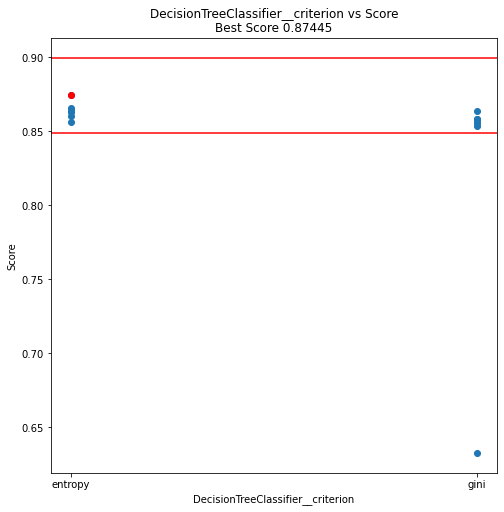

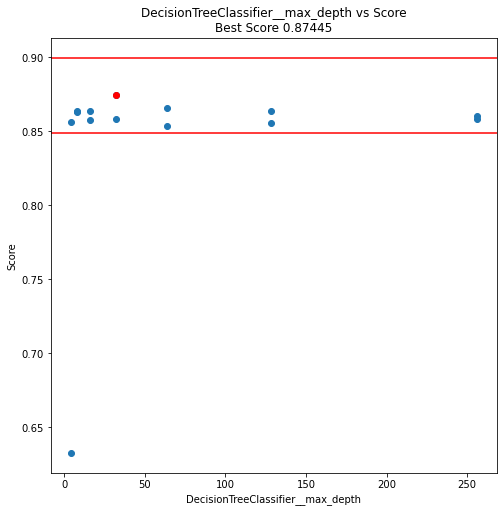

In [30]:
GridSearch_table_plot(grid, param_list=["DecisionTreeClassifier__criterion","DecisionTreeClassifier__max_depth"],negative=False)


In [32]:
print(grid.best_params_)
model=grid.best_estimator_
model.fit(train_x,train_y)
y_pred = model.predict(test_x)
test_valutation=valutate_test(test_y,y_pred)
dict_valutazioni['DecisionTreeClassifier']={"test":test_valutation,"kfold":cros_valutation}


print("DecisionTree Classifier")
print( f"Accuracy: {test_valutation['Accuracy']}")
print( f"Macro f1: {test_valutation['f1']}")
print(f"Confusion Matrix:\n {test_valutation['Confusion Matrix']}")

{'DecisionTreeClassifier__criterion': 'entropy', 'DecisionTreeClassifier__max_depth': 32, 'reduce_dim': 'passthrough'}
DecisionTree Classifier
Accuracy: 0.8743068391866913
Macro f1: 0.866841261400921
Confusion Matrix:
 [[138   0   2   6   8   0   5]
 [  3  37   0   1   3   0   2]
 [  3   0  37   0   2   1   1]
 [  1   0   1  85   6   0   0]
 [  4   2   0   1  57   0   1]
 [  5   0   0   0   0  77   1]
 [  1   1   2   2   3   0  42]]


## Random Forest Classifier  con embeddings ricalcolate da GNN

In [34]:
pipe = Pipeline([("reduce_dim", "passthrough"),
                 ('RandomForestClassifier', RandomForestClassifier())])

parametri=  [

                {
                    "reduce_dim": ["passthrough"],
                    "RandomForestClassifier__criterion":['gini','entropy'],
                    "RandomForestClassifier__max_depth":[4,8,16,32,64,128,256],
                    "RandomForestClassifier__n_estimators":[64,128,256,512],
                    
                }
            ]
        

grid = GridSearchCV(pipe, n_jobs=-1, param_grid=parametri,cv=5,scoring='f1_macro',return_train_score=True)
grid.fit(train_x,train_y)

print("tuned hpyerparameters :(best parameters) ",grid.best_params_)

tuned hpyerparameters :(best parameters)  {'RandomForestClassifier__criterion': 'gini', 'RandomForestClassifier__max_depth': 128, 'RandomForestClassifier__n_estimators': 64, 'reduce_dim': 'passthrough'}


best parameters: {'RandomForestClassifier__criterion': 'gini', 'RandomForestClassifier__max_depth': 128, 'RandomForestClassifier__n_estimators': 64, 'reduce_dim': 'passthrough'}
best score:      0.91688 (+/-0.01079)


param_RandomForestClassifier__criterion  \
20                                    gini   
7                                     gini   
2                                     gini   
5                                     gini   
18                                    gini   
4                                     gini   
36                                 entropy   
3                                     gini   
38                                 entropy   
29                                 entropy   
31                                 entropy   
10                                    gini   
54                                 entropy   
21                                    gini   
11                                    gini   
30                                 entropy   
0                                     gini   
19                                    gini   
6                                     gini   
28                                 entropy   
42                                 entropy   
14                                    gini   
26                                    gini   
25                                    gini   
50                                 entropy   
34                                 entropy   
22                                    gini   
1                                     gini   
45                                 entropy   
27                                    gini   
48                                 entropy   
15                                    gini   
23                                    gini   
13                                    gini   
33                                 entropy   
24                                    gini   
9                                     gini   
46                                 entropy   
55                                 entropy   
47                                 entropy   

   param_RandomForestClassifier__max_depth  \
20                                     128   
7                                        8   
2                                        4   
5                                        8   
18                                      64   
4                                        8   
36                                      16   
3                                        4   
38                                      16   
29                                       4   
31                                       4   
10                                      16   
54                                     256   
21                                     128   
11                                      16   
30                                       4   
0                                        4   
19                                      64   
6                                        8   
28                                       4   
42                                      32   
14                                      32   
26                                     256   
25                                     256   
50                                     128   
34                                       8   
22                                     128   
1                                        4   
45                                      64   
27                                     256   
48                                     128   
15                                      32   
23                                     128   
13                                      32   
33                                       8   
24                                     256   
9                                       16   
46                                      64   
55                                     256   
47                                      64   

   param_RandomForestClassifier__n_estimators  mean_test_score  \
20                                         64         0.916881   
7                                         512         0.916492   
2                              

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_RandomForestClassifier__criterion',
       'param_RandomForestClassifier__max_depth',
       'param_RandomForestClassifier__n_estimators', 'param_reduce_dim',
       'params', 'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'split3_train_score',
       'split4_train_score', 'mean_train_score', 'std_train_score'],
      dtype='object')


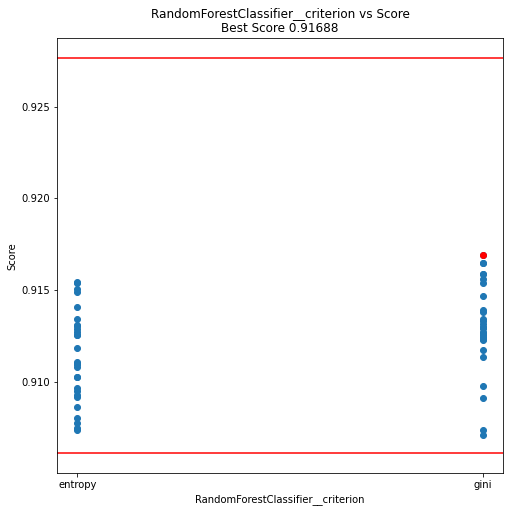

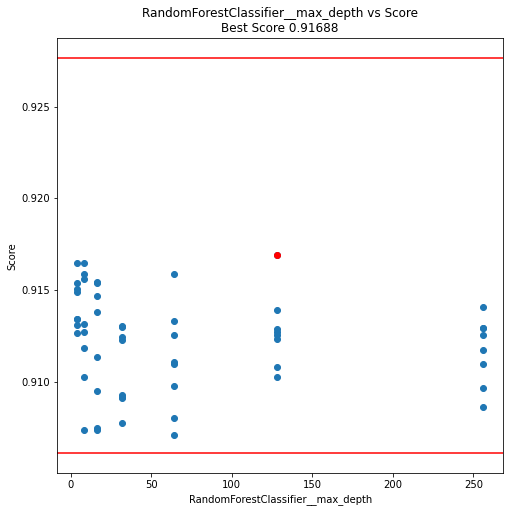

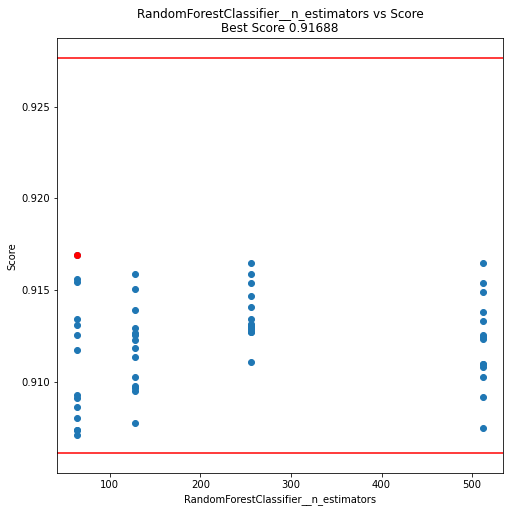

In [35]:
GridSearch_table_plot(grid, param_list=["RandomForestClassifier__criterion","RandomForestClassifier__max_depth","RandomForestClassifier__n_estimators"],negative=False)

In [36]:
print(grid.best_params_)
model=grid.best_estimator_
model.fit(train_x,train_y)
y_pred = model.predict(test_x)
test_valutation=valutate_test(test_y,y_pred)
dict_valutazioni['RandomForestClassifier']={"test":test_valutation,}
print("Random Forest Classifier")
print( f"Accuracy: {test_valutation['Accuracy']}")
print( f"Macro f1: {test_valutation['f1']}")
print(f"Confusion Matrix:\n {test_valutation['Confusion Matrix']}")

{'RandomForestClassifier__criterion': 'gini', 'RandomForestClassifier__max_depth': 128, 'RandomForestClassifier__n_estimators': 64, 'reduce_dim': 'passthrough'}
Random Forest Classifier
Accuracy: 0.8798521256931608
Macro f1: 0.8695879146810841
Confusion Matrix:
 [[139   0   1   7   6   0   6]
 [  2  35   0   0   6   1   2]
 [  1   0  40   0   1   2   0]
 [  2   0   1  87   3   0   0]
 [  5   2   1   0  55   0   2]
 [  2   0   1   0   0  80   0]
 [  3   1   0   2   4   1  40]]


## Support Vector Machines con embeddings ricalcolate da GNN

### SVM kernel linear

In [37]:
pipe = Pipeline([("reduce_dim", "passthrough"),
                 ('svm',svm.SVC(kernel='linear'))])

parametri=  [

                {
                    "reduce_dim": ["passthrough"],
                    "svm__decision_function_shape":['ovo', 'ovr'],
                    "svm__C": [0.1,0.5,1,10,50,100],
                    
                }
            ]
        

grid = GridSearchCV(pipe, n_jobs=-1, param_grid=parametri,cv=5,scoring='f1_macro',return_train_score=True)
grid.fit(train_x,train_y)

print("tuned hpyerparameters :(best parameters) ",grid.best_params_)

tuned hpyerparameters :(best parameters)  {'reduce_dim': 'passthrough', 'svm__C': 0.1, 'svm__decision_function_shape': 'ovo'}


best parameters: {'reduce_dim': 'passthrough', 'svm__C': 0.1, 'svm__decision_function_shape': 'ovo'}
best score:      0.91991 (+/-0.01162)


param_svm__C param_svm__decision_function_shape  mean_test_score  \
0           0.1                                ovo         0.919905   
1           0.1                                ovr         0.919905   
2           0.5                                ovo         0.911222   
3           0.5                                ovr         0.911222   
4             1                                ovo         0.906591   
5             1                                ovr         0.906591   
6            10                                ovo         0.895620   
7            10                                ovr         0.895620   
8            50                                ovo         0.889970   
9            50                                ovr         0.889970   
10          100                                ovo         0.887347   
11          100                                ovr         0.887347   

    std_test_score  rank_test_score  mean_train_score  std_train_score  
0         0.011624                1          0.943871         0.003814  
1         0.011624                1          0.943871         0.003814  
2         0.017599                3          0.952853         0.002792  
3         0.017599                3          0.952853         0.002792  
4         0.019323                5          0.959576         0.002640  
5         0.019323                5          0.959576         0.002640  
6         0.013990                7          0.988566         0.002331  
7         0.013990                7          0.988566         0.002331  
8         0.009625                9          0.996974         0.000646  
9         0.009625                9          0.996974         0.000646  
10        0.010099               11          0.997315         0.000705  
11        0.010099               11          0.997315         0.000705

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_reduce_dim', 'param_svm__C',
       'param_svm__decision_function_shape', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'split0_train_score', 'split1_train_score',
       'split2_train_score', 'split3_train_score', 'split4_train_score',
       'mean_train_score', 'std_train_score'],
      dtype='object')


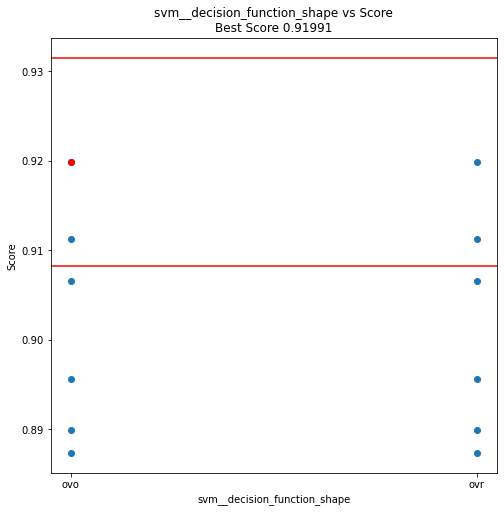

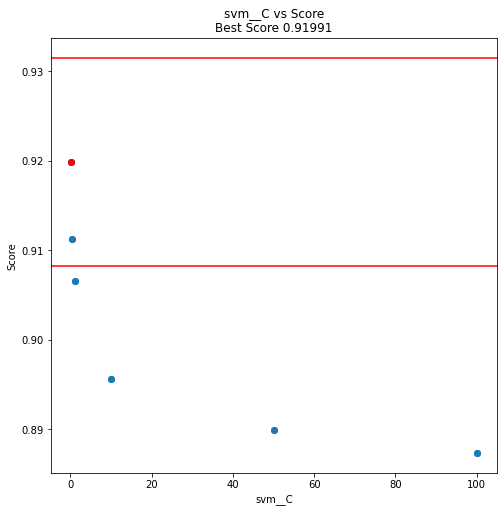

In [39]:
GridSearch_table_plot(grid, param_list=["svm__decision_function_shape","svm__C"],negative=False)

In [40]:
print(grid.best_params_)
model=grid.best_estimator_
model.fit(train_x,train_y)
y_pred = model.predict(test_x)
test_valutation=valutate_test(test_y,y_pred)
dict_valutazioni['svm']={"test":test_valutation}
print("SVM linear")
print( f"Accuracy: {test_valutation['Accuracy']}")
print( f"Macro f1: {test_valutation['f1']}")
print(f"Confusion Matrix:\n {test_valutation['Confusion Matrix']}")

{'reduce_dim': 'passthrough', 'svm__C': 0.1, 'svm__decision_function_shape': 'ovo'}
SVM linear
Accuracy: 0.8817005545286506
Macro f1: 0.872106994696464
Confusion Matrix:
 [[139   0   1   6   7   0   6]
 [  3  36   0   0   4   1   2]
 [  1   0  40   0   1   2   0]
 [  2   0   1  87   3   0   0]
 [  6   2   1   0  55   1   0]
 [  2   0   1   0   0  79   1]
 [  1   1   2   2   3   1  41]]


### SVM kernel poly

In [41]:
pipe = Pipeline([("reduce_dim", "passthrough"),
                 ('svm', svm.SVC(kernel='poly'))])

parametri=  [


                {
                    "reduce_dim": ["passthrough"],
                    "svm__degree":[2,3,4,5,6,7],
                    "svm__decision_function_shape":['ovo', 'ovr'],
                    "svm__C": [0.1,0.5,1,10,50,100],
                    
                }
            ]
grid = GridSearchCV(pipe, n_jobs=-1, param_grid=parametri,cv=5,scoring='f1_macro',return_train_score=True)
grid.fit(train_x,train_y)

print("tuned hpyerparameters :(best parameters) ",grid.best_params_)

tuned hpyerparameters :(best parameters)  {'reduce_dim': 'passthrough', 'svm__C': 0.5, 'svm__decision_function_shape': 'ovo', 'svm__degree': 2}


best parameters: {'reduce_dim': 'passthrough', 'svm__C': 0.5, 'svm__decision_function_shape': 'ovo', 'svm__degree': 2}
best score:      0.92206 (+/-0.01656)


param_svm__C param_svm__decision_function_shape param_svm__degree  \
12          0.5                                ovo                 2   
18          0.5                                ovr                 2   
30            1                                ovr                 2   
24            1                                ovo                 2   
19          0.5                                ovr                 3   
13          0.5                                ovo                 3   
20          0.5                                ovr                 4   
14          0.5                                ovo                 4   
42           10                                ovr                 2   
36           10                                ovo                 2   
31            1                                ovr                 3   
25            1                                ovo                 3   
26            1                                ovo                 4   
32            1                                ovr                 4   
43           10                                ovr                 3   
37           10                                ovo                 3   
0           0.1                                ovo                 2   
6           0.1                                ovr                 2   
44           10                                ovr                 4   
38           10                                ovo                 4   
33            1                                ovr                 5   
27            1                                ovo                 5   
15          0.5                                ovo                 5   
21          0.5                                ovr                 5   
45           10                                ovr                 5   
39           10                                ovo                 5   
54           50                                ovr                 2   
48           50                                ovo                 2   
7           0.1                                ovr                 3   
1           0.1                                ovo                 3   
49           50                                ovo                 3   
55           50                                ovr                 3   
34            1                                ovr                 6   
28            1                                ovo                 6   
60          100                                ovo                 2   
66          100                                ovr                 2   
56           50                                ovr                 4   
50           50                                ovo                 4   
40           10                                ovo                 6   
46           10                                ovr                 6   

    mean_test_score  std_test_score  rank_test_score  mean_train_score  \
12         0.922056        0.016555                1          0.934343   
18         0.922056        0.016555                1          0.934343   
30         0.920715        0.011538                3          0.939330   
24         0.920715        0.011538                3          0.939330   
19         0.919100        0.016322                5          0.933283   
13         0.919100        0.016322                5          0.933283   
20         0.915538        0.014809                7          0.933405   
14         0.915538        0.014809                7          0.933405   
42         0.914897        0.019054                9          0.951143   
36         0.914897        0.019054                9          0.951143   
31         0.913719        0.015280               11          0.937951   
25         0.913719        0.015280               11          0.937951   
26         0.912933        0.013753               13          0.939521   
32         0.9

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_reduce_dim', 'param_svm__C',
       'param_svm__decision_function_shape', 'param_svm__degree', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'split3_train_score',
       'split4_train_score', 'mean_train_score', 'std_train_score'],
      dtype='object')


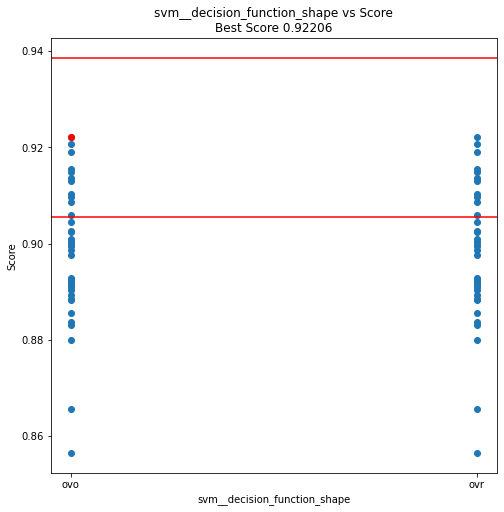

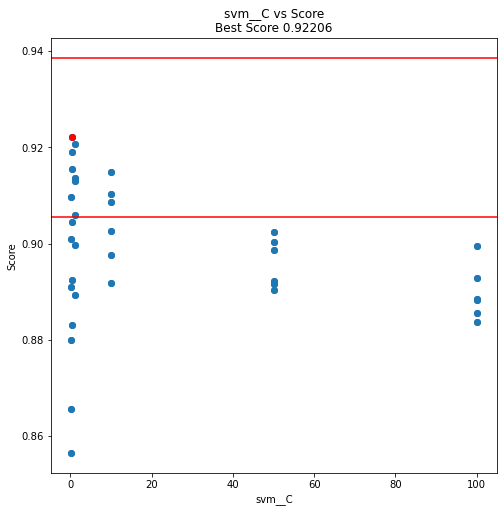

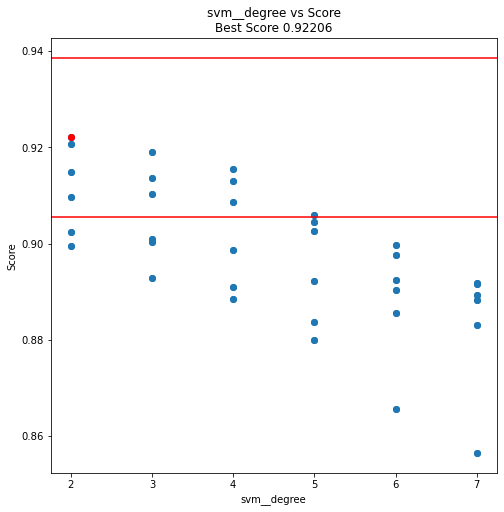

In [42]:
GridSearch_table_plot(grid, param_list=["svm__decision_function_shape","svm__C","svm__degree"],negative=False)

In [43]:
print(grid.best_params_)
model=grid.best_estimator_
model.fit(train_x,train_y)
y_pred = model.predict(test_x)
test_valutation=valutate_test(test_y,y_pred)
dict_valutazioni['svm']={"test":test_valutation}
print("SVM polinear")
print( f"Accuracy: {test_valutation['Accuracy']}")
print( f"Macro f1: {test_valutation['f1']}")
print(f"Confusion Matrix:\n {test_valutation['Confusion Matrix']}")

{'reduce_dim': 'passthrough', 'svm__C': 0.5, 'svm__decision_function_shape': 'ovo', 'svm__degree': 2}
SVM polinear
Accuracy: 0.8798521256931608
Macro f1: 0.8666843711073655
Confusion Matrix:
 [[140   0   1   5   7   0   6]
 [  2  35   0   0   7   0   2]
 [  1   0  40   0   1   2   0]
 [  2   0   1  87   3   0   0]
 [  5   3   1   0  55   1   0]
 [  2   0   1   0   0  79   1]
 [  1   1   2   2   4   1  40]]


### SVM kernel rbf

In [44]:
pipe = Pipeline([("reduce_dim", "passthrough"),
                 ('svm', svm.SVC(kernel='rbf'))])

parametri=  [

                {
                    "reduce_dim": ["passthrough"],
                    "svm__decision_function_shape":['ovo', 'ovr'],
                    "svm__C": [0.1,0.5,1,10,50,100],
                    "svm__gamma": [0.001, 0.01 , 0.1 , 1 ,10, 100]
                    
                }
            ]
        

grid = GridSearchCV(pipe, n_jobs=-1, param_grid=parametri,cv=5,scoring='f1_macro',return_train_score=True)
grid.fit(train_x,train_y)

print("tuned hpyerparameters :(best parameters) ",grid.best_params_)

tuned hpyerparameters :(best parameters)  {'reduce_dim': 'passthrough', 'svm__C': 1, 'svm__decision_function_shape': 'ovo', 'svm__gamma': 0.001}


best parameters: {'reduce_dim': 'passthrough', 'svm__C': 1, 'svm__decision_function_shape': 'ovo', 'svm__gamma': 0.001}
best score:      0.92337 (+/-0.01719)


param_svm__C param_svm__decision_function_shape param_svm__gamma  \
24            1                                ovo            0.001   
30            1                                ovr            0.001   
13          0.5                                ovo             0.01   
19          0.5                                ovr             0.01   
42           10                                ovr            0.001   
36           10                                ovo            0.001   
48           50                                ovo            0.001   
54           50                                ovr            0.001   
1           0.1                                ovo             0.01   
7           0.1                                ovr             0.01   
25            1                                ovo             0.01   
31            1                                ovr             0.01   
18          0.5                                ovr            0.001   
12          0.5                                ovo            0.001   
60          100                                ovo            0.001   
66          100                                ovr            0.001   
37           10                                ovo             0.01   
43           10                                ovr             0.01   
55           50                                ovr             0.01   
49           50                                ovo             0.01   
67          100                                ovr             0.01   
61          100                                ovo             0.01   
26            1                                ovo              0.1   
32            1                                ovr              0.1   
0           0.1                                ovo            0.001   
6           0.1                                ovr            0.001   
44           10                                ovr              0.1   
38           10                                ovo              0.1   
20          0.5                                ovr              0.1   
14          0.5                                ovo              0.1   
56           50                                ovr              0.1   
50           50                                ovo              0.1   
62          100                                ovo              0.1   
68          100                                ovr              0.1   
2           0.1                                ovo              0.1   
8           0.1                                ovr              0.1   
57           50                                ovr                1   
69          100                                ovr                1   
45           10                                ovr                1   
51           50                                ovo                1   

    mean_test_score  std_test_score  rank_test_score  mean_train_score  \
24         0.923366        0.017192                1          0.927638   
30         0.923366        0.017192                1          0.927638   
13         0.920840        0.018019                3          0.935183   
19         0.920840        0.018019                3          0.935183   
42         0.920466        0.016019                5          0.938897   
36         0.920466        0.016019                5          0.938897   
48         0.919254        0.012098                7          0.946688   
54         0.919254        0.012098                7          0.946688   
1          0.918334        0.017944                9          0.924355   
7          0.918334        0.017944                9          0.924355   
25         0.917312        0.017009               11          0.939539   
31         0.917312        0.017009               11          0.939539   
18         0.917156        0.019075               13          0.922299   
12         0.917156        0.019075               13   

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_reduce_dim', 'param_svm__C',
       'param_svm__decision_function_shape', 'param_svm__gamma', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'split3_train_score',
       'split4_train_score', 'mean_train_score', 'std_train_score'],
      dtype='object')


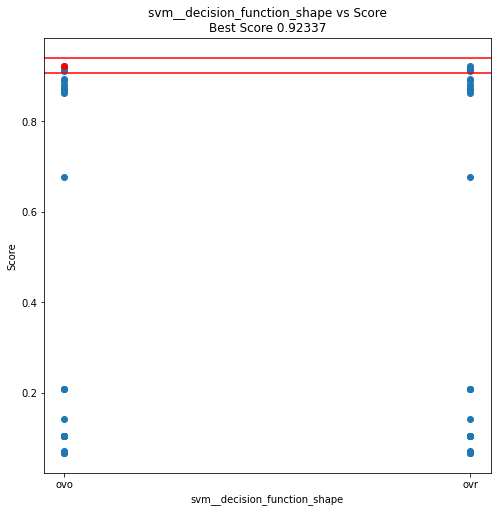

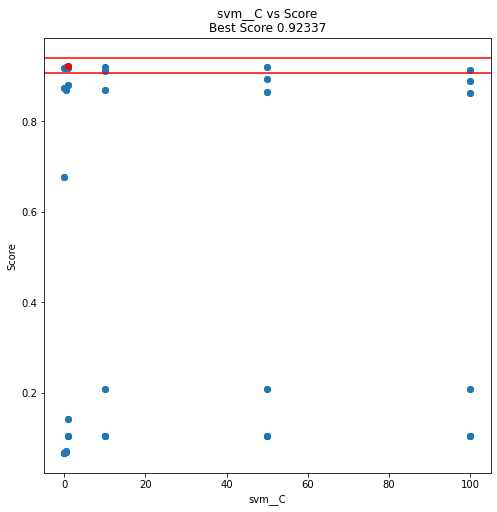

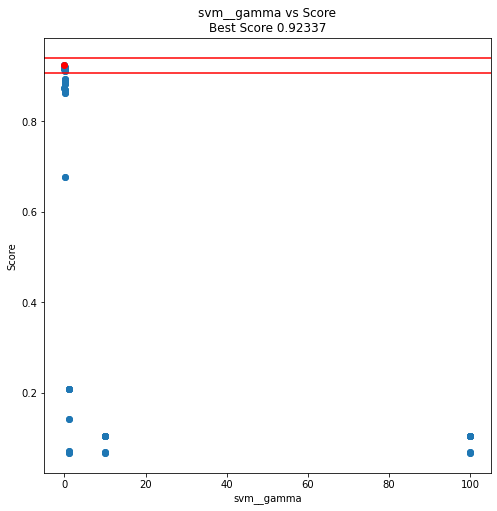

In [45]:
GridSearch_table_plot(grid, param_list=["svm__decision_function_shape","svm__C","svm__gamma"],negative=False)


In [46]:
print(grid.best_params_)
model=grid.best_estimator_
model.fit(train_x,train_y)
y_pred = model.predict(test_x)
test_valutation=valutate_test(test_y,y_pred)
dict_valutazioni['svm']={"test":test_valutation}
print("SVM rbf")
print( f"Accuracy: {test_valutation['Accuracy']}")
print( f"Macro f1: {test_valutation['f1']}")
print(f"Confusion Matrix:\n {test_valutation['Confusion Matrix']}")

{'reduce_dim': 'passthrough', 'svm__C': 1, 'svm__decision_function_shape': 'ovo', 'svm__gamma': 0.001}
SVM rbf
Accuracy: 0.8817005545286506
Macro f1: 0.8691557615394558
Confusion Matrix:
 [[140   0   1   5   7   0   6]
 [  1  35   0   0   8   0   2]
 [  1   0  40   0   1   2   0]
 [  2   0   1  86   4   0   0]
 [  5   2   1   0  56   0   1]
 [  2   0   1   0   0  79   1]
 [  0   1   2   2   4   1  41]]


## neural networks  con embeddings ricalcolate da GNN

In [67]:
class modello(torch.nn.Module):
    def __init__(self,n_feature=1433,n_layers=0,dim_hidden_layers=300,activation=F.relu,dropout=0.2):
        super().__init__()
        
        self.dropout = torch.nn.Dropout(dropout)
        self.dense_layers=torch.nn.ModuleList([torch.nn.Linear(dim_hidden_layers, dim_hidden_layers) for i in range(n_layers)])
        self.activation=activation
        self.n_layers=n_layers
        self.lin_in = torch.nn.Linear(n_feature, dim_hidden_layers)
        self.lin_out = torch.nn.Linear(dim_hidden_layers, 7)
    
    def forward(self, data):
        x = data.x
        x = self.lin_in(x)
        x = self.activation(x)
        x=  self.dropout(x)
        for i in range(self.n_layers):
            x = self.dense_layers[i](x)
            x = self.activation(x)
            x=  self.dropout(x)
        x = self.lin_out(x)
        return F.log_softmax(x, dim=1)


import pandas as pd
from sklearn.model_selection import ParameterGrid

preprocessing=[ 
                {"reduce_dim": ["passthrough"]}]

parametri_modello = {
    'n_layers':[0,1,2,4,5],
    'dim_hidden_layers':[50,150,300,1000],
    'activation':[ torch.relu ,torch.sigmoid,torch.tanh],
    'dropout':[0,0.2,0.3,0.5]
}

parametri_training={
    "epochs":[10,20,30,50,100],
    "optimizer":[torch.optim.Adam],
    "loss":[F.nll_loss]
}

x=data.x.detach().numpy()
data.x=torch.from_numpy(x).type(torch.float32)


param=gridSearch( cv=5,dataset=data,
            modello=modello,
            preprocessing=preprocessing,
            parametri_training=parametri_training,
            parametri_modello=parametri_modello)
param.to_pickle("neuralnet_emb_ricalcolate.pkl")


1000


epochs                                       loss  \
986      100  <function nll_loss at 0x00000271C256E430>   
530       30  <function nll_loss at 0x00000271C256E430>   
1036     100  <function nll_loss at 0x00000271C256E430>   
991      100  <function nll_loss at 0x00000271C256E430>   
987      100  <function nll_loss at 0x00000271C256E430>   
...      ...                                        ...   
1105     100  <function nll_loss at 0x00000271C256E430>   
1141     100  <function nll_loss at 0x00000271C256E430>   
955       50  <function nll_loss at 0x00000271C256E430>   
1190     100  <function nll_loss at 0x00000271C256E430>   
1005     100  <function nll_loss at 0x00000271C256E430>   

                            optimizer  \
986   <class 'torch.optim.adam.Adam'>   
530   <class 'torch.optim.adam.Adam'>   
1036  <class 'torch.optim.adam.Adam'>   
991   <class 'torch.optim.adam.Adam'>   
987   <class 'torch.optim.adam.Adam'>   
...                               ...   
1105  <class 'torch.optim.adam.Adam'>   
1141  <class 'torch.optim.adam.Adam'>   
955   <class 'torch.optim.adam.Adam'>   
1190  <class 'torch.optim.adam.Adam'>   
1005  <class 'torch.optim.adam.Adam'>   

                                             activation  dim_hidden_layers  \
986   <built-in method relu of type object at 0x0000...                150   
530   <built-in method relu of type object at 0x0000...                300   
1036  <built-in method relu of type object at 0x0000...               1000   
991   <built-in method relu of type object at 0x0000...                150   
987   <built-in method relu of type object at 0x0000...                150   
...                                                 ...                ...   
1105  <built-in method sigmoid of type object at 0x0...               1000   
1141  <built-in method tanh of type object at 0x0000...                150   
955   <built-in method tanh of type object at 0x0000...               1000   
1190  <built-in method tanh of type object at 0x0000...               1000   
1005  <built-in method relu of type object at 0x0000...                300   

      dropout  n_layers  n_feature  z_mean_test_score  z_std_test_score  \
986       0.2         1       1000           0.923773          0.008422   
530       0.3         0       1000           0.923156          0.012177   
1036      0.5         1       1000           0.923114          0.008003   
991       0.3         1       1000           0.923064          0.010726   
987       0.2         2       1000           0.922354          0.011084   
...       ...       ...        ...                ...               ...   
1105      0.2         0       1000           0.919111          0.012755   
1141      0.0         1       1000           0.919084          0.006436   
955       0.5         0       1000           0.919054          0.007968   
1190      0.3         0       1000           0.919016          0.008911   
1005      0.2         0       1000           0.919016          0.012997   

      z_mean_train_score  z_std_train_score  
986             0.933349           0.002683  
530             0.923063           0.003908  
1036            0.941352           0.003045  
991             0.933735           0.002290  
987             0.936033           0.003653  
...                  ...                ...  
1105            0.929791           0.004316  
1141            0.938342           0.001969  
955             0.928757           0.002134  
1190            0.931175           0.002953  
1005            0.930378           0.002118  

[100 rows x 12 columns]

100
<built-in method relu of type object at 0x00007FFBD212A590>
150
0.2
1


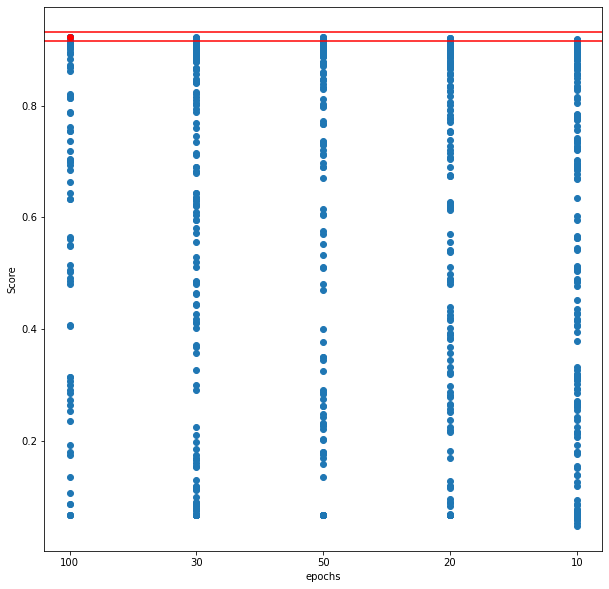

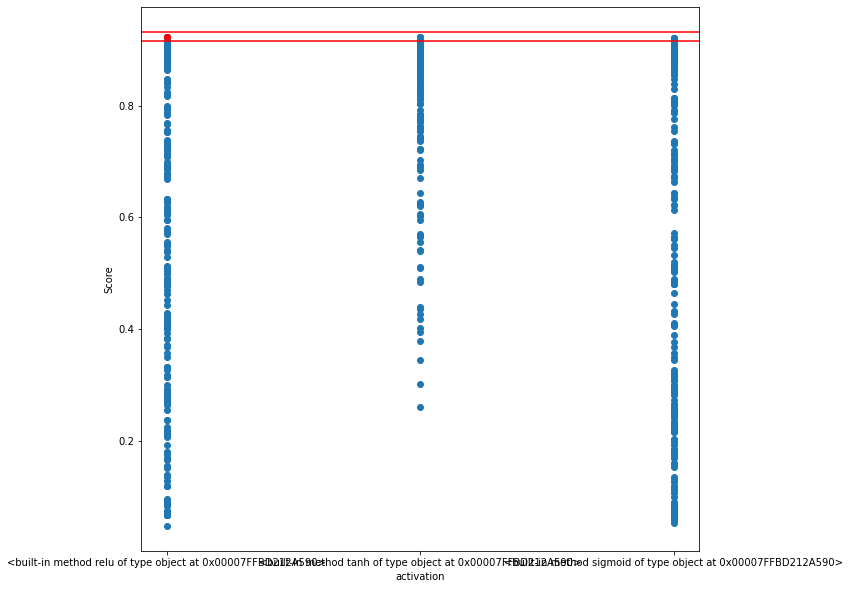

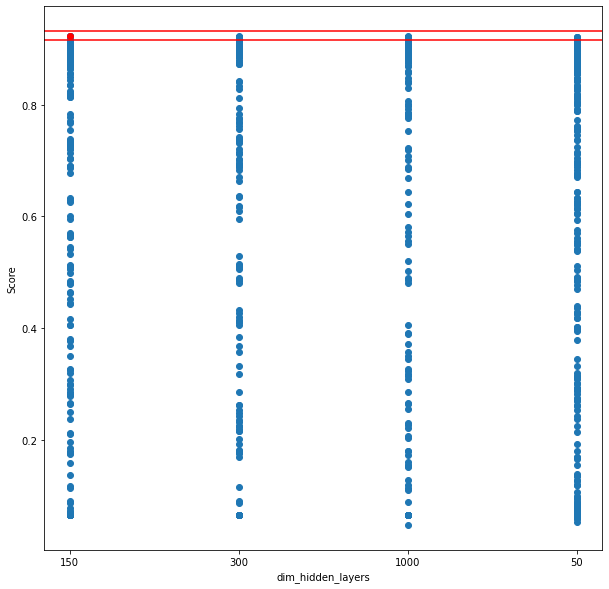

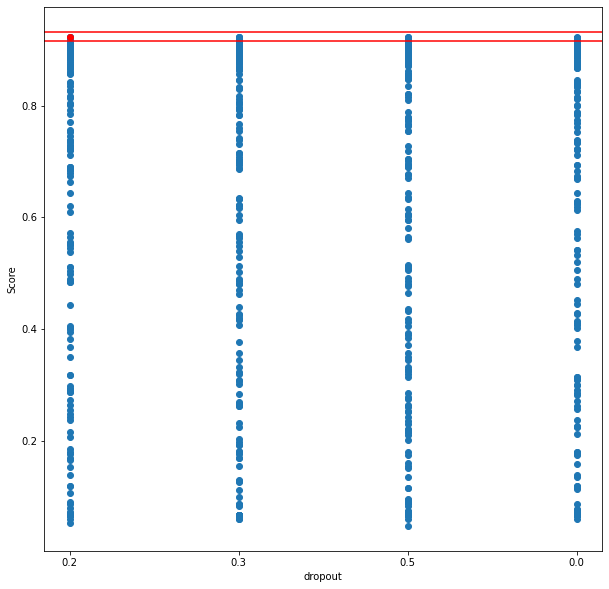

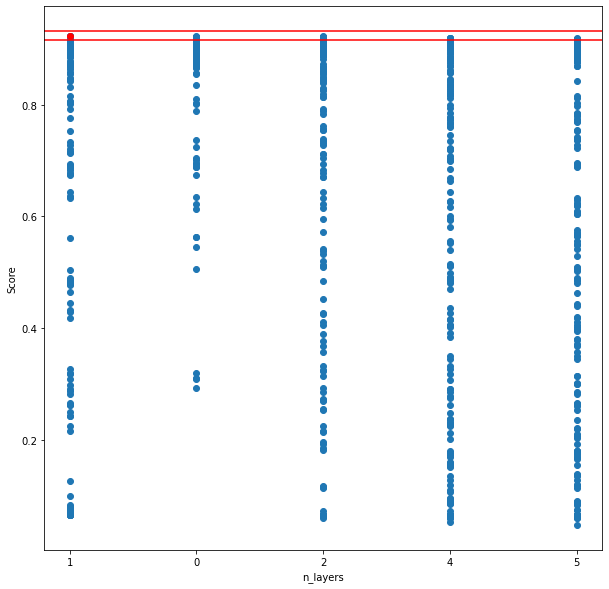

In [69]:
pa=param.sort_values(by=['z_mean_test_score'],ascending=False)

param_list=[	"epochs","activation"	,"dim_hidden_layers",	"dropout",	"n_layers"	]
scores_df=pa
display(pa.head(100))
best_row = scores_df.iloc[0, :]
best_mean = best_row['z_mean_test_score']
best_stdev = best_row['z_std_test_score']
for param_name in param_list:
    best_param =str( best_row[param_name])
    print(best_param)
    means = scores_df['z_mean_test_score']
    stds = scores_df['z_std_test_score']
    params = scores_df[param_name].astype(str)
    
    plt.figure(figsize=(10, 10))
    plt.plot(params, means,"o")

    plt.axhline(y=best_mean + best_stdev, color='red')
    plt.axhline(y=best_mean - best_stdev, color='red')
    plt.plot(best_param, best_mean, 'or')

    plt.xlabel(param_name)
    plt.ylabel('Score')
plt.show()






In [71]:

modello_migliore = {
    'n_layers':1,
    'dim_hidden_layers':150,
    'activation':torch.relu,
    'dropout':0.2,
    'n_feature':1000
}

training_migliore={
    "epochs":100,
    "optimizer":torch.optim.Adam,
    "loss":F.nll_loss
}


model=modello(**modello_migliore).to("cuda")
data.to('cuda')
optimizer=training_migliore['optimizer'](model.parameters())
model.train()
for _ in range(training_migliore['epochs']):
    optimizer.zero_grad()
    out = model(data)
    loss=training_migliore['loss'](out[data.train_mask],data.y[data.train_mask])
    loss.backward()
    optimizer.step()

model.eval()
pred = model(data)
pred=pred.argmax(dim=1)

f_test=metrics.f1_score(data.y[data.test_mask].cpu(), pred[data.test_mask].cpu() ,average='macro')
f_train=metrics.f1_score(data.y[data.train_mask].cpu(), pred[data.train_mask].cpu() ,average='macro')

accuracy_test=metrics.accuracy_score(data.y[data.test_mask].cpu(), pred[data.test_mask].cpu())
accuracy_train=metrics.accuracy_score(data.y[data.train_mask].cpu(), pred[data.train_mask].cpu() )
matr=metrics.confusion_matrix(data.y[data.test_mask].cpu(), pred[data.test_mask].cpu())

print(f"accuracy test: {accuracy_test}")

print(f"accuracy train: {accuracy_train}")
print(f"f1 test: {f_test}")
print(f"f1 train: {f_train}")

print(matr)

accuracy test: 0.8743068391866913
accuracy train: 0.9432395016151361
f1 test: 0.8648243767270578
f1 train: 0.9383610770867251
[[139   0   1   6   7   0   6]
 [  3  35   0   0   5   1   2]
 [  1   0  40   0   1   2   0]
 [  2   0   1  87   3   0   0]
 [  6   1   2   0  55   1   0]
 [  4   0   0   0   0  78   1]
 [  3   1   2   2   3   1  39]]


# Prova dei vai modelli con le con embeddings ricalcolate con GAE nel task di predizione degli archi

In [93]:
#eseguire questa cella per usare le embedding calcolate con GCN neli modelli successivi

train_x=embeddings_auto_encoders[data.train_mask].cpu().detach().numpy()
train_y=data.y[data.train_mask].cpu().detach().numpy()
test_x=embeddings_auto_encoders[data.test_mask].cpu().detach().numpy()
test_y=data.y[data.test_mask].cpu().detach().numpy()

data.x=embeddings_auto_encoders



## Logistic regression con embeddings ricalcolate da GAE

In [94]:
pipe = Pipeline([("reduce_dim", "passthrough"),
                 ('logisticregression', LogisticRegression())])

parametri=       {
                    "reduce_dim": ["passthrough"],
                    "logisticregression__penalty":['l1', 'l2', 'elasticnet', 'none'],
                    "logisticregression__solver":['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                    "logisticregression__C": [0.1,0.5,1,10,50,100]
                }
            
        

grid = GridSearchCV(pipe, n_jobs=-1, param_grid=parametri,cv=5,scoring='f1_macro',return_train_score=True)
grid.fit(train_x,train_y)

print("tuned hpyerparameters :(best parameters) ",grid.best_params_)

C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
270 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit


tuned hpyerparameters :(best parameters)  {'logisticregression__C': 0.5, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear', 'reduce_dim': 'passthrough'}


best parameters: {'logisticregression__C': 0.5, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear', 'reduce_dim': 'passthrough'}
best score:      0.84314 (+/-0.02740)


param_logisticregression__C param_logisticregression__penalty  \
27                          0.5                                l2   
47                            1                                l2   
26                          0.5                                l2   
25                          0.5                                l2   
29                          0.5                                l2   
28                          0.5                                l2   
49                            1                                l2   
48                            1                                l2   
46                            1                                l2   
45                            1                                l2   
7                           0.1                                l2   
67                           10                                l2   
44                            1                                l1   
6                           0.1                                l2   
9                           0.1                                l2   
5                           0.1                                l2   
8                           0.1                                l2   
64                           10                                l1   
42                            1                                l1   
68                           10                                l2   
89                           50                                l2   
99                           50                              none   
69                           10                                l2   
19                          0.1                              none   
59                            1                              none   
109                         100                                l2   
39                          0.5                              none   
79                           10                              none   
66                           10                                l2   
84                           50                                l1   
119                         100                              none   
65                           10                                l2   
104                         100                                l1   
62                           10                                l1   
18                          0.1                              none   
98                           50                              none   
88                           50                                l2   
78                           10                              none   
87                           50                                l2   
38                          0.5                              none   

    param_logisticregression__solver  mean_test_score  std_test_score  \
27                         liblinear         0.843139        0.027402   
47                         liblinear         0.842278        0.026527   
26                             lbfgs         0.839504        0.026739   
25                         newton-cg         0.839504        0.026739   
29                              saga         0.839146        0.026827   
28                               sag         0.839146        0.026827   
49                              saga         0.838879        0.025451   
48                               sag         0.837511        0.025056   
46                             lbfgs         0.837511        0.025056   
45                         newton-cg         0.837511        0.025056   
7                          liblinear         0.837354        0.032558   
67                         liblinear         0.836502        0.028927   
44                              saga         0.836106        0.028381   
6                              lbfgs         0.832689        0.029209   
9                               saga         0.832689        0.029209   
5     

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_logisticregression__C', 'param_logisticregression__penalty',
       'param_logisticregression__solver', 'param_reduce_dim', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'split3_train_score',
       'split4_train_score', 'mean_train_score', 'std_train_score'],
      dtype='object')


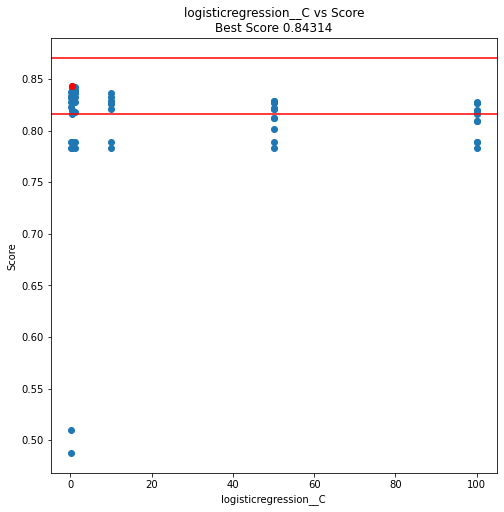

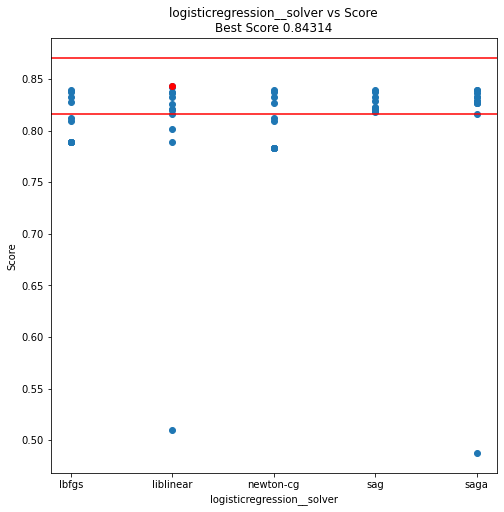

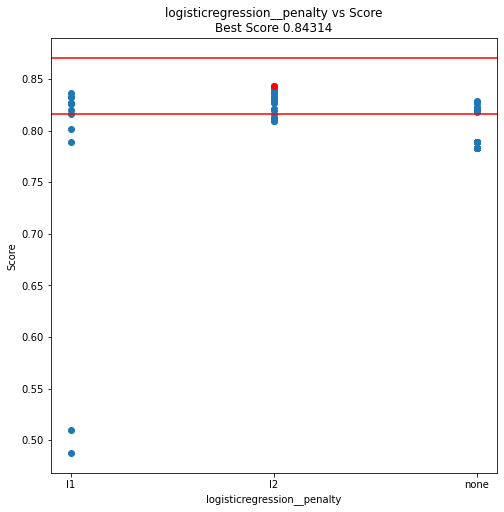

In [95]:
GridSearch_table_plot(grid, param_list=['logisticregression__C','logisticregression__solver',"logisticregression__penalty"],negative=False)


In [96]:
print(grid.best_params_)
model=grid.best_estimator_
model.fit(train_x,train_y)
model = model.fit(train_x,train_y)
y_pred = model.predict(test_x)
test_valutation=valutate_test(test_y,y_pred)
dict_valutazioni['LogisticRegression']={"test":test_valutation}
print("Logostic Regression")
print( f"Accuracy: {test_valutation['Accuracy']}")
print( f"Macro f1: {test_valutation['f1']}")
print(f"Confusion Matrix:\n {test_valutation['Confusion Matrix']}")

{'logisticregression__C': 0.5, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear', 'reduce_dim': 'passthrough'}
Logostic Regression
Accuracy: 0.8558225508317929
Macro f1: 0.8433950739381191
Confusion Matrix:
 [[143   0   1   5   6   1   3]
 [  4  32   0   0   6   1   3]
 [  1   0  39   0   1   2   1]
 [  6   0   1  80   4   0   2]
 [  6   1   1   1  55   0   1]
 [  4   0   0   0   0  77   2]
 [  4   1   1   3   4   1  37]]


## Linear Discriminant Analysis con embeddings ricalcolate da GAE

In [97]:
pipe = Pipeline([("reduce_dim", "passthrough"),
                 ('LinearDiscriminantAnalysis',LinearDiscriminantAnalysis(store_covariance=True))])

parametri=  [

                {
                    "reduce_dim": ["passthrough"],
                    "LinearDiscriminantAnalysis__solver":['svd', 'lsqr', 'eigen'],
                }
            ]
        

grid = GridSearchCV(pipe, n_jobs=-1, param_grid=parametri,cv=5,scoring='f1_macro',return_train_score=True)
grid.fit(train_x,train_y)

print("tuned hpyerparameters :(best parameters) ",grid.best_params_)

tuned hpyerparameters :(best parameters)  {'LinearDiscriminantAnalysis__solver': 'svd', 'reduce_dim': 'passthrough'}


best parameters: {'LinearDiscriminantAnalysis__solver': 'svd', 'reduce_dim': 'passthrough'}
best score:      0.70668 (+/-0.04114)


param_LinearDiscriminantAnalysis__solver  mean_test_score  std_test_score  \
0                                      svd         0.706683        0.041139   
1                                     lsqr         0.706683        0.041139   
2                                    eigen         0.706683        0.041139   

   rank_test_score  mean_train_score  std_train_score  
0                1          0.988407         0.001273  
1                1          0.988407         0.001273  
2                1          0.988407         0.001273

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_LinearDiscriminantAnalysis__solver', 'param_reduce_dim',
       'params', 'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'split3_train_score',
       'split4_train_score', 'mean_train_score', 'std_train_score'],
      dtype='object')


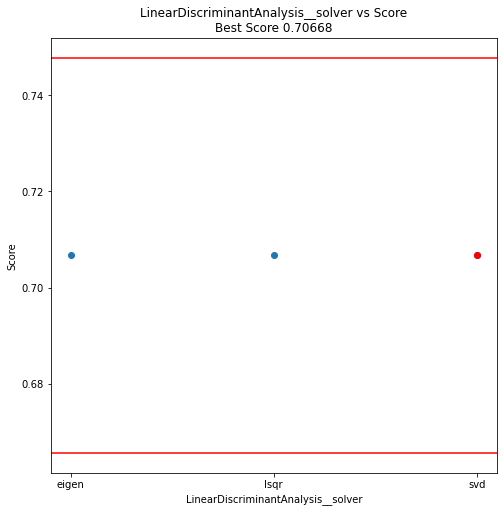

In [98]:
GridSearch_table_plot(grid, param_list=['LinearDiscriminantAnalysis__solver'],negative=False)


In [99]:
print(grid.best_params_)
model=grid.best_estimator_
model.fit(train_x,train_y)
model = model.fit(train_x,train_y)
y_pred = model.predict(test_x)
test_valutation=valutate_test(test_y,y_pred)
dict_valutazioni['LinearDiscriminantAnalysis']={"test":test_valutation}
print("Linear Discriminant Analysis")
print( f"Accuracy: {test_valutation['Accuracy']}")
print( f"Macro f1: {test_valutation['f1']}")
print(f"Confusion Matrix:\n {test_valutation['Confusion Matrix']}")

{'LinearDiscriminantAnalysis__solver': 'svd', 'reduce_dim': 'passthrough'}
Linear Discriminant Analysis
Accuracy: 0.8114602587800369
Macro f1: 0.7923132061569281
Confusion Matrix:
 [[132   0   4   6  12   0   5]
 [  5  28   0   1   5   2   5]
 [  5   0  33   2   1   2   1]
 [  3   1   0  83   2   1   3]
 [  9   1   2   1  52   0   0]
 [  5   0   0   0   0  76   2]
 [  6   1   2   2   2   3  35]]


## Quadratic Discriminant Analysis con embeddings ricalcolate da GAE

In [100]:
pipe = Pipeline([("reduce_dim", "passthrough"),
                 ('LinearDiscriminantAnalysis',QuadraticDiscriminantAnalysis(store_covariance=True))])
parametri=  [
                {
                    "reduce_dim": ["passthrough"],  
                }
            ]
        

grid = GridSearchCV(pipe, n_jobs=-1, param_grid=parametri,cv=5,scoring='f1_macro',return_train_score=True)
grid.fit(train_x,train_y)

print("tuned hpyerparameters :(best parameters) ",grid.best_params_)

C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


tuned hpyerparameters :(best parameters)  {'reduce_dim': 'passthrough'}


In [101]:
print(grid.best_params_)
model=grid.best_estimator_
model.fit(train_x,train_y)
model = model.fit(train_x,train_y)
y_pred = model.predict(test_x)
test_valutation=valutate_test(test_y,y_pred)
dict_valutazioni['QuadraticDiscriminantAnalysis']={"test":test_valutation}
print("Quadratic Discriminant Analysis")
print( f"Accuracy: {test_valutation['Accuracy']}")
print( f"Macro f1: {test_valutation['f1']}")
print(f"Confusion Matrix:\n {test_valutation['Confusion Matrix']}")

{'reduce_dim': 'passthrough'}


C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Quadratic Discriminant Analysis
Accuracy: 0.41035120147874304
Macro f1: 0.42946116177155397
Confusion Matrix:
 [[50 62 39  0  1  2  5]
 [ 0 38  6  0  0  1  1]
 [ 0 12 28  0  1  1  2]
 [ 0 29 32 27  2  1  2]
 [ 0 26 17  0 14  2  6]
 [ 0 26 16  0  0 39  2]
 [ 0 15  9  0  1  0 26]]


## K Neighbors Classifier con embeddings ricalcolate da GAE

In [102]:
pipe = Pipeline([("reduce_dim", "passthrough"),
                 ('KNeighborsClassifier', KNeighborsClassifier())])

parametri=  [
                {
                    "reduce_dim": ["passthrough"],
                    "KNeighborsClassifier__weights":['uniform', 'distance'],
                    "KNeighborsClassifier__n_neighbors":[1,3,5,10,20],
                    "KNeighborsClassifier__p":[0.5, 1,2,4,8,50,100]
                    
                }
            ]
        

grid = GridSearchCV(pipe, n_jobs=-1, param_grid=parametri,cv=5,scoring='f1_macro',return_train_score=True)
grid.fit(train_x,train_y)

print("tuned hpyerparameters :(best parameters) ",grid.best_params_)

tuned hpyerparameters :(best parameters)  {'KNeighborsClassifier__n_neighbors': 3, 'KNeighborsClassifier__p': 1, 'KNeighborsClassifier__weights': 'distance', 'reduce_dim': 'passthrough'}


C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
50 fits failed out of a total of 350.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\neighbors\_classification.py", line 198, in fit

best parameters: {'KNeighborsClassifier__n_neighbors': 3, 'KNeighborsClassifier__p': 1, 'KNeighborsClassifier__weights': 'distance', 'reduce_dim': 'passthrough'}
best score:      0.82430 (+/-0.04020)


param_KNeighborsClassifier__n_neighbors param_KNeighborsClassifier__p  \
17                                       3                             1   
19                                       3                             2   
31                                       5                             1   
33                                       5                             2   
35                                       5                             4   
21                                       3                             4   
47                                      10                             2   
45                                      10                             1   
23                                       3                             8   
37                                       5                             8   
49                                      10                             4   
30                                       5                             1   
5                                        1                             2   
4                                        1                             2   
3                                        1                             1   
2                                        1                             1   
16                                       3                             1   
8                                        1                             8   
9                                        1                             8   
25                                       3                            50   
18                                       3                             2   
32                                       5                             2   
7                                        1                             4   
6                                        1                             4   
27                                       3                           100   
20                                       3                             4   
22                                       3                             8   
39                                       5                            50   
34                                       5                             4   
51                                      10                             8   
41                                       5                           100   
10                                       1                            50   
11                                       1                            50   
44                                      10                             1   
55                                      10                           100   
46                                      10                             2   
13                                       1                           100   
12                                       1                           100   
59                                      20                             1   
36                                       5                             8   

   param_KNeighborsClassifier__weights  mean_test_score  std_test_score  \
17                            distance         0.824299        0.040196   
19                            distance         0.822915        0.038285   
31                            distance         0.821546        0.028659   
33                            distance         0.820751        0.033574   
35                            distance         0.817727        0.031835   
21                            distance         0.817122        0.029955   
47                            distance         0.816111        0.035203   
45                            distance         0.815279        0.032562   
23                            distance         0.814664        0.027615   
37                            distance         0.811768        0.033731   
49                            distance         0.811031      

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_KNeighborsClassifier__n_neighbors',
       'param_KNeighborsClassifier__p', 'param_KNeighborsClassifier__weights',
       'param_reduce_dim', 'params', 'split0_test_score', 'split1_test_score',
       'split2_test_score', 'split3_test_score', 'split4_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score',
       'split0_train_score', 'split1_train_score', 'split2_train_score',
       'split3_train_score', 'split4_train_score', 'mean_train_score',
       'std_train_score'],
      dtype='object')


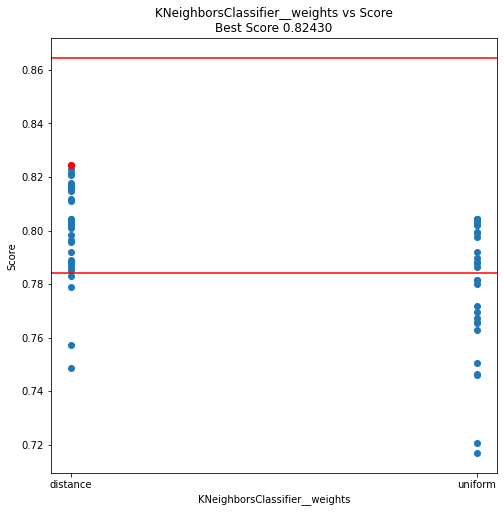

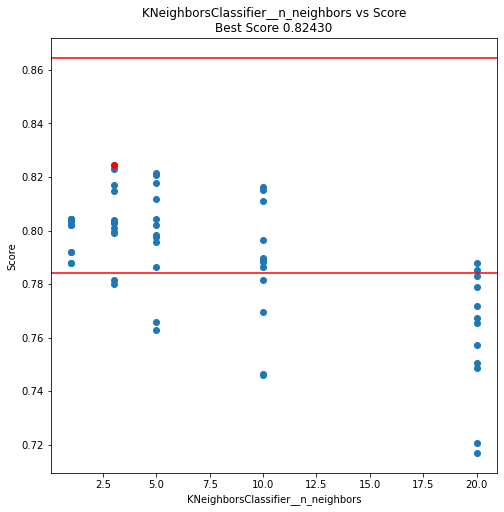

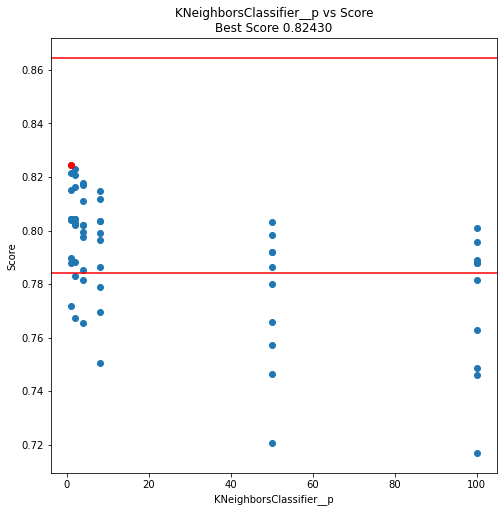

In [103]:
GridSearch_table_plot(grid, param_list=["KNeighborsClassifier__weights","KNeighborsClassifier__n_neighbors","KNeighborsClassifier__p"],negative=False)

In [104]:
print(grid.best_params_)
model=grid.best_estimator_
model.fit(train_x,train_y)
model = model.fit(train_x,train_y)
y_pred = model.predict(test_x)
test_valutation=valutate_test(test_y,y_pred)
dict_valutazioni['KNeighborsClassifier']={"test":test_valutation}
print("K-Neighbors Classifier")
print( f"Accuracy: {test_valutation['Accuracy']}")
print( f"Macro f1: {test_valutation['f1']}")
print(f"Confusion Matrix:\n {test_valutation['Confusion Matrix']}")

{'KNeighborsClassifier__n_neighbors': 3, 'KNeighborsClassifier__p': 1, 'KNeighborsClassifier__weights': 'distance', 'reduce_dim': 'passthrough'}
K-Neighbors Classifier
Accuracy: 0.8465804066543438
Macro f1: 0.8283173272713577
Confusion Matrix:
 [[133   0   4   5  11   2   4]
 [  1  33   1   0   5   3   3]
 [  1   0  38   1   1   2   1]
 [  3   2   1  84   2   0   1]
 [  5   2   2   1  55   0   0]
 [  2   0   1   0   0  80   0]
 [  3   3   0   2   7   1  35]]


## Decision Tree Classifer con embeddings ricalcolate da GAE

In [105]:
pipe = Pipeline([("reduce_dim", "passthrough"),
                 ('DecisionTreeClassifier', DecisionTreeClassifier())])

parametri=  [
                {
                    "reduce_dim": ["passthrough"],
                    "DecisionTreeClassifier__criterion":['gini','entropy'],
                    "DecisionTreeClassifier__max_depth":[4,8,16,32,64,128,256]
                    
                }
            ]
        

grid = GridSearchCV(pipe, n_jobs=-1, param_grid=parametri,cv=5,scoring='f1_macro',return_train_score=True)
grid.fit(train_x,train_y)

print("tuned hpyerparameters :(best parameters) ",grid.best_params_)

tuned hpyerparameters :(best parameters)  {'DecisionTreeClassifier__criterion': 'entropy', 'DecisionTreeClassifier__max_depth': 32, 'reduce_dim': 'passthrough'}


best parameters: {'DecisionTreeClassifier__criterion': 'entropy', 'DecisionTreeClassifier__max_depth': 32, 'reduce_dim': 'passthrough'}
best score:      0.54939 (+/-0.04238)


param_DecisionTreeClassifier__criterion  \
10                                 entropy   
3                                     gini   
9                                  entropy   
11                                 entropy   
2                                     gini   
12                                 entropy   
8                                  entropy   
13                                 entropy   
6                                     gini   
5                                     gini   
4                                     gini   
1                                     gini   
7                                  entropy   
0                                     gini   

   param_DecisionTreeClassifier__max_depth  mean_test_score  std_test_score  \
10                                      32         0.549394        0.042376   
3                                       32         0.544574        0.035554   
9                                       16         0.544188        0.047919   
11                                      64         0.543467        0.060909   
2                                       16         0.539560        0.046090   
12                                     128         0.537170        0.043872   
8                                        8         0.537085        0.056754   
13                                     256         0.535335        0.042045   
6                                      256         0.533538        0.037322   
5                                      128         0.527811        0.030180   
4                                       64         0.522120        0.051824   
1                                        8         0.518215        0.057511   
7                                        4         0.456594        0.012026   
0                                        4         0.380322        0.079199   

    rank_test_score  mean_train_score  std_train_score  
10                1          0.998467         0.000561  
3                 2          0.998467         0.000561  
9                 3          0.998467         0.000561  
11                4          0.998467         0.000561  
2                 5          0.995483         0.002268  
12                6          0.998467         0.000561  
8                 7          0.926444         0.009580  
13                8          0.998467         0.000561  
6                 9          0.998467         0.000561  
5                10          0.998467         0.000561  
4                11          0.998467         0.000561  
1                12          0.822726         0.016657  
7                13          0.548532         0.029851  
0                14          0.490662         0.031999

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_DecisionTreeClassifier__criterion',
       'param_DecisionTreeClassifier__max_depth', 'param_reduce_dim', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'split3_train_score',
       'split4_train_score', 'mean_train_score', 'std_train_score'],
      dtype='object')


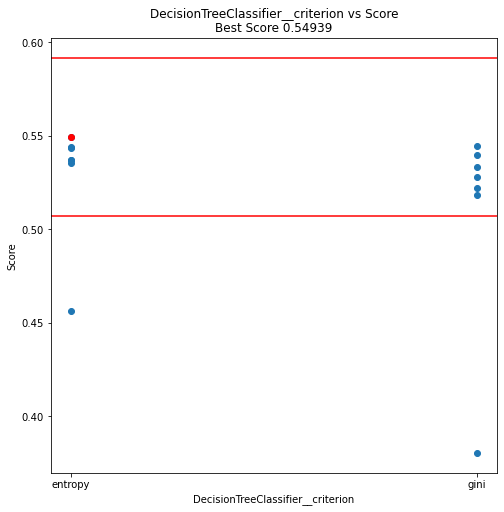

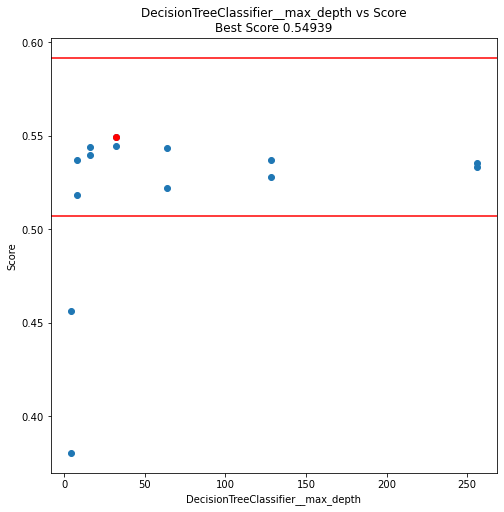

In [106]:
GridSearch_table_plot(grid, param_list=["DecisionTreeClassifier__criterion","DecisionTreeClassifier__max_depth"],negative=False)


In [107]:
print(grid.best_params_)
model=grid.best_estimator_
model.fit(train_x,train_y)
y_pred = model.predict(test_x)
test_valutation=valutate_test(test_y,y_pred)
dict_valutazioni['DecisionTreeClassifier']={"test":test_valutation,"kfold":cros_valutation}


print("DecisionTree Classifier")
print( f"Accuracy: {test_valutation['Accuracy']}")
print( f"Macro f1: {test_valutation['f1']}")
print(f"Confusion Matrix:\n {test_valutation['Confusion Matrix']}")

{'DecisionTreeClassifier__criterion': 'entropy', 'DecisionTreeClassifier__max_depth': 32, 'reduce_dim': 'passthrough'}
DecisionTree Classifier
Accuracy: 0.6451016635859519
Macro f1: 0.627109637491613
Confusion Matrix:
 [[102   5   5  13  13  16   5]
 [  6  21   2   2   9   1   5]
 [  4   2  28   1   2   3   4]
 [ 11   2   3  60   6   3   8]
 [  5   2   2   9  44   2   1]
 [  8   0   2   3   2  63   5]
 [  6   2   1   4   5   2  31]]


## Random Forest Classifier con embeddings ricalcolate da GAE

In [108]:
pipe = Pipeline([("reduce_dim", "passthrough"),
                 ('RandomForestClassifier', RandomForestClassifier())])

parametri=  [

                {
                    "reduce_dim": ["passthrough"],
                    "RandomForestClassifier__criterion":['gini','entropy'],
                    "RandomForestClassifier__max_depth":[4,8,16,32,64,128,256],
                    "RandomForestClassifier__n_estimators":[64,128,256,512],
                    
                }
            ]
        

grid = GridSearchCV(pipe, n_jobs=-1, param_grid=parametri,cv=5,scoring='f1_macro',return_train_score=True)
grid.fit(train_x,train_y)

print("tuned hpyerparameters :(best parameters) ",grid.best_params_)

tuned hpyerparameters :(best parameters)  {'RandomForestClassifier__criterion': 'gini', 'RandomForestClassifier__max_depth': 64, 'RandomForestClassifier__n_estimators': 512, 'reduce_dim': 'passthrough'}


best parameters: {'RandomForestClassifier__criterion': 'gini', 'RandomForestClassifier__max_depth': 64, 'RandomForestClassifier__n_estimators': 512, 'reduce_dim': 'passthrough'}
best score:      0.81973 (+/-0.03162)


param_RandomForestClassifier__criterion  \
19                                    gini   
43                                 entropy   
14                                    gini   
41                                 entropy   
11                                    gini   
26                                    gini   
39                                 entropy   
54                                 entropy   
47                                 entropy   
18                                    gini   
51                                 entropy   
10                                    gini   
27                                    gini   
9                                     gini   
50                                 entropy   
15                                    gini   
46                                 entropy   
55                                 entropy   
23                                    gini   
38                                 entropy   
22                                    gini   
17                                    gini   
21                                    gini   
49                                 entropy   
42                                 entropy   
13                                    gini   
34                                 entropy   
12                                    gini   
45                                 entropy   
37                                 entropy   
48                                 entropy   
25                                    gini   
35                                 entropy   
20                                    gini   
44                                 entropy   
52                                 entropy   
53                                 entropy   
8                                     gini   
36                                 entropy   
40                                 entropy   

   param_RandomForestClassifier__max_depth  \
19                                      64   
43                                      32   
14                                      32   
41                                      32   
11                                      16   
26                                     256   
39                                      16   
54                                     256   
47                                      64   
18                                      64   
51                                     128   
10                                      16   
27                                     256   
9                                       16   
50                                     128   
15                                      32   
46                                      64   
55                                     256   
23                                     128   
38                                      16   
22                                     128   
17                                      64   
21                                     128   
49                                     128   
42                                      32   
13                                      32   
34                                       8   
12                                      32   
45                                      64   
37                                      16   
48                                     128   
25                                     256   
35                                       8   
20                                     128   
44                                      64   
52                                     256   
53                                     256   
8                                       16   
36                                      16   
40                                      32   

   param_RandomForestClassifier__n_estimators  mean_test_score  \
19                                        512         0.819726   
43                                        512         0.819100   
14                             

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_RandomForestClassifier__criterion',
       'param_RandomForestClassifier__max_depth',
       'param_RandomForestClassifier__n_estimators', 'param_reduce_dim',
       'params', 'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'split3_train_score',
       'split4_train_score', 'mean_train_score', 'std_train_score'],
      dtype='object')


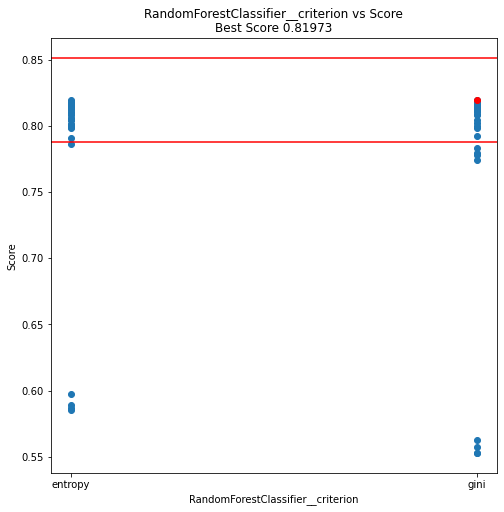

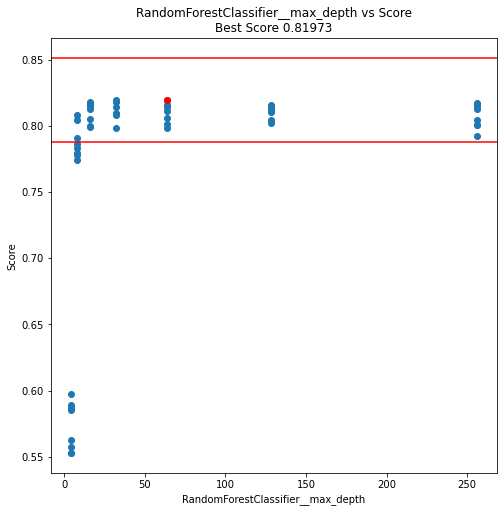

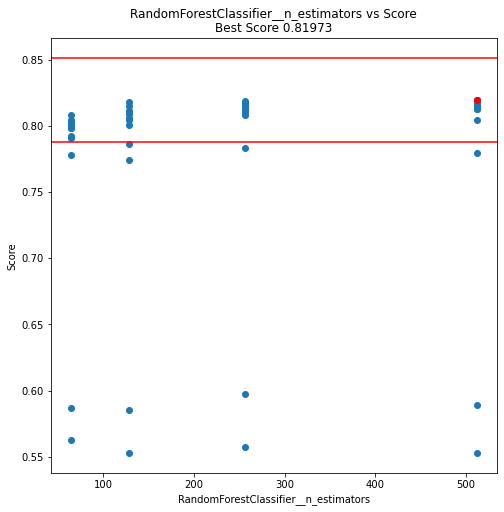

In [109]:
GridSearch_table_plot(grid, param_list=["RandomForestClassifier__criterion","RandomForestClassifier__max_depth","RandomForestClassifier__n_estimators"],negative=False)

In [111]:
print(grid.best_params_)
model=grid.best_estimator_
model.fit(train_x,train_y)
y_pred = model.predict(test_x)
test_valutation=valutate_test(test_y,y_pred)
dict_valutazioni['RandomForestClassifier']={"test":test_valutation,}
print("Random Forest Classifier")
print( f"Accuracy: {test_valutation['Accuracy']}")
print( f"Macro f1: {test_valutation['f1']}")
print(f"Confusion Matrix:\n {test_valutation['Confusion Matrix']}")

{'RandomForestClassifier__criterion': 'gini', 'RandomForestClassifier__max_depth': 64, 'RandomForestClassifier__n_estimators': 512, 'reduce_dim': 'passthrough'}
Random Forest Classifier
Accuracy: 0.844731977818854
Macro f1: 0.8282976074871174
Confusion Matrix:
 [[148   0   0   2   6   0   3]
 [  9  27   0   0   8   0   2]
 [  9   0  32   0   1   2   0]
 [  6   0   0  84   3   0   0]
 [  8   0   1   0  56   0   0]
 [  7   0   0   0   0  76   0]
 [  7   0   0   2   6   2  34]]


## Support Vector Machines con embeddings ricalcolate da GAE

### SVM kernel linear

In [112]:
pipe = Pipeline([("reduce_dim", "passthrough"),
                 ('svm',svm.SVC(kernel='linear'))])

parametri=  [

                {
                    "reduce_dim": ["passthrough"],
                    "svm__decision_function_shape":['ovo', 'ovr'],
                    "svm__C": [0.1,0.5,1,10,50,100],
                    
                }
            ]
        

grid = GridSearchCV(pipe, n_jobs=-1, param_grid=parametri,cv=5,scoring='f1_macro',return_train_score=True)
grid.fit(train_x,train_y)

print("tuned hpyerparameters :(best parameters) ",grid.best_params_)

tuned hpyerparameters :(best parameters)  {'reduce_dim': 'passthrough', 'svm__C': 0.1, 'svm__decision_function_shape': 'ovo'}


best parameters: {'reduce_dim': 'passthrough', 'svm__C': 0.1, 'svm__decision_function_shape': 'ovo'}
best score:      0.84302 (+/-0.02129)


param_svm__C param_svm__decision_function_shape  mean_test_score  \
0           0.1                                ovo         0.843020   
1           0.1                                ovr         0.843020   
2           0.5                                ovo         0.840623   
3           0.5                                ovr         0.840623   
4             1                                ovo         0.832450   
5             1                                ovr         0.832450   
6            10                                ovo         0.809578   
7            10                                ovr         0.809578   
8            50                                ovo         0.804551   
9            50                                ovr         0.804551   
10          100                                ovo         0.800129   
11          100                                ovr         0.800129   

    std_test_score  rank_test_score  mean_train_score  std_train_score  
0         0.021287                1          0.904526         0.006389  
1         0.021287                1          0.904526         0.006389  
2         0.030392                3          0.948272         0.003604  
3         0.030392                3          0.948272         0.003604  
4         0.031256                5          0.967249         0.002948  
5         0.031256                5          0.967249         0.002948  
6         0.029190                7          0.995646         0.001124  
7         0.029190                7          0.995646         0.001124  
8         0.030550                9          0.997702         0.001022  
9         0.030550                9          0.997702         0.001022  
10        0.029825               11          0.998466         0.000560  
11        0.029825               11          0.998466         0.000560

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_reduce_dim', 'param_svm__C',
       'param_svm__decision_function_shape', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'split0_train_score', 'split1_train_score',
       'split2_train_score', 'split3_train_score', 'split4_train_score',
       'mean_train_score', 'std_train_score'],
      dtype='object')


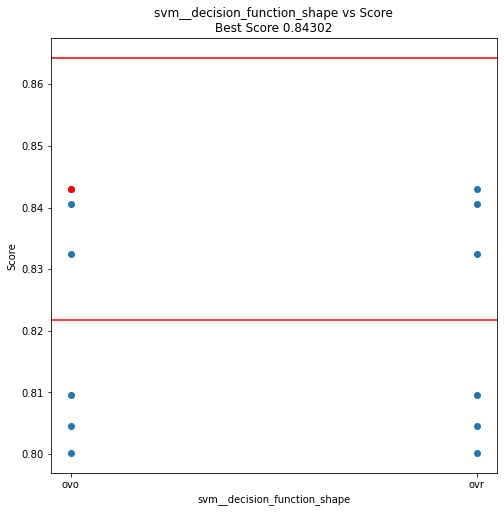

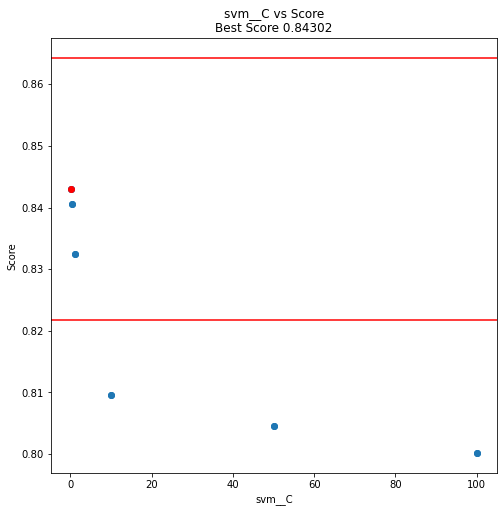

In [113]:
GridSearch_table_plot(grid, param_list=["svm__decision_function_shape","svm__C"],negative=False)

In [114]:
print(grid.best_params_)
model=grid.best_estimator_
model.fit(train_x,train_y)
y_pred = model.predict(test_x)
test_valutation=valutate_test(test_y,y_pred)
dict_valutazioni['svm']={"test":test_valutation}
print("SVM linear")
print( f"Accuracy: {test_valutation['Accuracy']}")
print( f"Macro f1: {test_valutation['f1']}")
print(f"Confusion Matrix:\n {test_valutation['Confusion Matrix']}")

{'reduce_dim': 'passthrough', 'svm__C': 0.1, 'svm__decision_function_shape': 'ovo'}
SVM linear
Accuracy: 0.844731977818854
Macro f1: 0.832480864233154
Confusion Matrix:
 [[139   1   1   4   9   0   5]
 [  4  30   0   0   9   0   3]
 [  1   0  39   0   1   2   1]
 [  5   0   1  80   5   0   2]
 [  6   3   1   0  54   0   1]
 [  5   0   0   0   0  77   1]
 [  6   1   0   2   4   0  38]]


### SVM kernel poly

In [115]:
pipe = Pipeline([("reduce_dim", "passthrough"),
                 ('svm', svm.SVC(kernel='poly'))])

parametri=  [


                {
                    "reduce_dim": ["passthrough"],
                    "svm__degree":[2,3,4,5,6,7],
                    "svm__decision_function_shape":['ovo', 'ovr'],
                    "svm__C": [0.1,0.5,1,10,50,100],
                    
                }
            ]
grid = GridSearchCV(pipe, n_jobs=-1, param_grid=parametri,cv=5,scoring='f1_macro',return_train_score=True)
grid.fit(train_x,train_y)

print("tuned hpyerparameters :(best parameters) ",grid.best_params_)

tuned hpyerparameters :(best parameters)  {'reduce_dim': 'passthrough', 'svm__C': 10, 'svm__decision_function_shape': 'ovo', 'svm__degree': 2}


best parameters: {'reduce_dim': 'passthrough', 'svm__C': 10, 'svm__decision_function_shape': 'ovo', 'svm__degree': 2}
best score:      0.82443 (+/-0.02992)


param_svm__C param_svm__decision_function_shape param_svm__degree  \
42           10                                ovr                 2   
36           10                                ovo                 2   
66          100                                ovr                 2   
60          100                                ovo                 2   
48           50                                ovo                 2   
54           50                                ovr                 2   
24            1                                ovo                 2   
30            1                                ovr                 2   
67          100                                ovr                 3   
61          100                                ovo                 3   
55           50                                ovr                 3   
49           50                                ovo                 3   
37           10                                ovo                 3   
43           10                                ovr                 3   
18          0.5                                ovr                 2   
12          0.5                                ovo                 2   
62          100                                ovo                 4   
68          100                                ovr                 4   
56           50                                ovr                 4   
50           50                                ovo                 4   
25            1                                ovo                 3   
31            1                                ovr                 3   
44           10                                ovr                 4   
38           10                                ovo                 4   
63          100                                ovo                 5   
69          100                                ovr                 5   
57           50                                ovr                 5   
51           50                                ovo                 5   
45           10                                ovr                 5   
39           10                                ovo                 5   
70          100                                ovr                 6   
64          100                                ovo                 6   
13          0.5                                ovo                 3   
19          0.5                                ovr                 3   
58           50                                ovr                 6   
52           50                                ovo                 6   
32            1                                ovr                 4   
26            1                                ovo                 4   
65          100                                ovo                 7   
71          100                                ovr                 7   

    mean_test_score  std_test_score  rank_test_score  mean_train_score  \
42         0.824427        0.029923                1          0.994108   
36         0.824427        0.029923                1          0.994108   
66         0.819988        0.030601                3          0.998467   
60         0.819988        0.030601                3          0.998467   
48         0.819679        0.030754                5          0.997277   
54         0.819679        0.030754                5          0.997277   
24         0.790872        0.033130                7          0.927130   
30         0.790872        0.033130                7          0.927130   
67         0.786387        0.042001                9          0.998467   
61         0.786387        0.042001                9          0.998467   
55         0.783592        0.039013               11          0.997534   
49         0.783592        0.039013               11          0.997534   
37         0.778629        0.036995               13          0.990070   
43         0.7

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_reduce_dim', 'param_svm__C',
       'param_svm__decision_function_shape', 'param_svm__degree', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'split3_train_score',
       'split4_train_score', 'mean_train_score', 'std_train_score'],
      dtype='object')


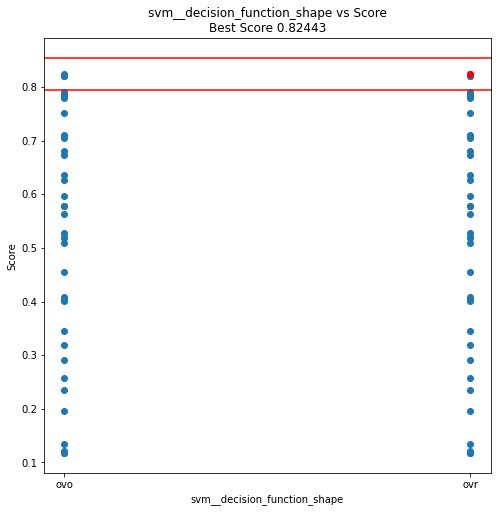

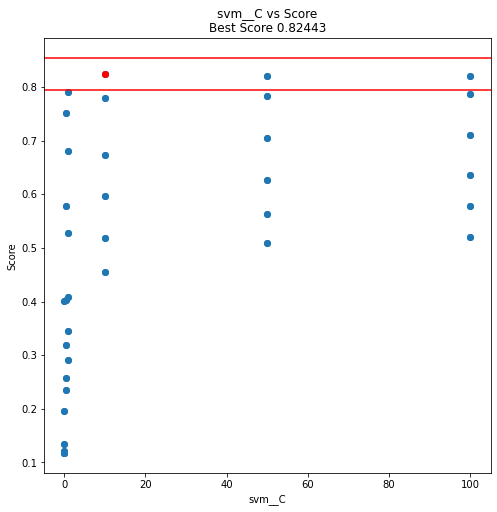

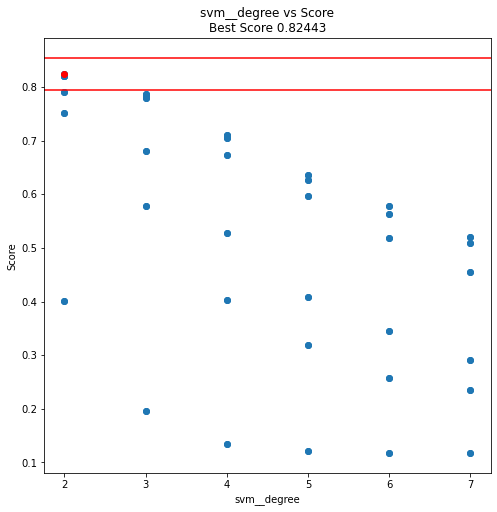

In [116]:
GridSearch_table_plot(grid, param_list=["svm__decision_function_shape","svm__C","svm__degree"],negative=False)

In [117]:
print(grid.best_params_)
model=grid.best_estimator_
model.fit(train_x,train_y)
y_pred = model.predict(test_x)
test_valutation=valutate_test(test_y,y_pred)
dict_valutazioni['svm']={"test":test_valutation}
print("SVM polinear")
print( f"Accuracy: {test_valutation['Accuracy']}")
print( f"Macro f1: {test_valutation['f1']}")
print(f"Confusion Matrix:\n {test_valutation['Confusion Matrix']}")

{'reduce_dim': 'passthrough', 'svm__C': 10, 'svm__decision_function_shape': 'ovo', 'svm__degree': 2}
SVM polinear
Accuracy: 0.8539741219963032
Macro f1: 0.8436180282543848
Confusion Matrix:
 [[138   0   5   4   8   1   3]
 [  6  33   0   0   5   0   2]
 [  3   0  37   0   2   2   0]
 [  2   0   1  84   5   0   1]
 [  9   1   2   0  53   0   0]
 [  3   0   1   0   0  78   1]
 [  5   1   0   2   2   2  39]]


### SVM kernel rbf

In [118]:
pipe = Pipeline([("reduce_dim", "passthrough"),
                 ('svm', svm.SVC(kernel='rbf'))])

parametri=  [

                {
                    "reduce_dim": ["passthrough"],
                    "svm__decision_function_shape":['ovo', 'ovr'],
                    "svm__C": [0.1,0.5,1,10,50,100],
                    "svm__gamma": [0.001, 0.01 , 0.1 , 1 ,10, 100]
                    
                }
            ]
        

grid = GridSearchCV(pipe, n_jobs=-1, param_grid=parametri,cv=5,scoring='f1_macro',return_train_score=True)
grid.fit(train_x,train_y)

print("tuned hpyerparameters :(best parameters) ",grid.best_params_)

tuned hpyerparameters :(best parameters)  {'reduce_dim': 'passthrough', 'svm__C': 1, 'svm__decision_function_shape': 'ovo', 'svm__gamma': 0.1}


best parameters: {'reduce_dim': 'passthrough', 'svm__C': 1, 'svm__decision_function_shape': 'ovo', 'svm__gamma': 0.1}
best score:      0.85456 (+/-0.02723)


param_svm__C param_svm__decision_function_shape param_svm__gamma  \
32            1                                ovr              0.1   
26            1                                ovo              0.1   
43           10                                ovr             0.01   
37           10                                ovo             0.01   
66          100                                ovr            0.001   
60          100                                ovo            0.001   
48           50                                ovo            0.001   
54           50                                ovr            0.001   
44           10                                ovr              0.1   
38           10                                ovo              0.1   
20          0.5                                ovr              0.1   
14          0.5                                ovo              0.1   
50           50                                ovo              0.1   
56           50                                ovr              0.1   
49           50                                ovo             0.01   
55           50                                ovr             0.01   
68          100                                ovr              0.1   
62          100                                ovo              0.1   
67          100                                ovr             0.01   
61          100                                ovo             0.01   
36           10                                ovo            0.001   
42           10                                ovr            0.001   
31            1                                ovr             0.01   
25            1                                ovo             0.01   
19          0.5                                ovr             0.01   
13          0.5                                ovo             0.01   
8           0.1                                ovr              0.1   
2           0.1                                ovo              0.1   
45           10                                ovr                1   
63          100                                ovo                1   
51           50                                ovo                1   
69          100                                ovr                1   
57           50                                ovr                1   
39           10                                ovo                1   
33            1                                ovr                1   
27            1                                ovo                1   
15          0.5                                ovo                1   
21          0.5                                ovr                1   
46           10                                ovr               10   
64          100                                ovo               10   

    mean_test_score  std_test_score  rank_test_score  mean_train_score  \
32         0.854563        0.027234                1          0.934939   
26         0.854563        0.027234                1          0.934939   
43         0.848566        0.021550                3          0.926184   
37         0.848566        0.021550                3          0.926184   
66         0.845776        0.022022                5          0.924565   
60         0.845776        0.022022                5          0.924565   
48         0.843215        0.021703                7          0.904928   
54         0.843215        0.021703                7          0.904928   
44         0.840293        0.031790                9          0.991271   
38         0.840293        0.031790                9          0.991271   
20         0.838767        0.023465               11          0.900979   
14         0.838767        0.023465               11          0.900979   
50         0.838045        0.030614               13          0.997279   
56         0.838045        0.030614               13   

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_reduce_dim', 'param_svm__C',
       'param_svm__decision_function_shape', 'param_svm__gamma', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'split3_train_score',
       'split4_train_score', 'mean_train_score', 'std_train_score'],
      dtype='object')


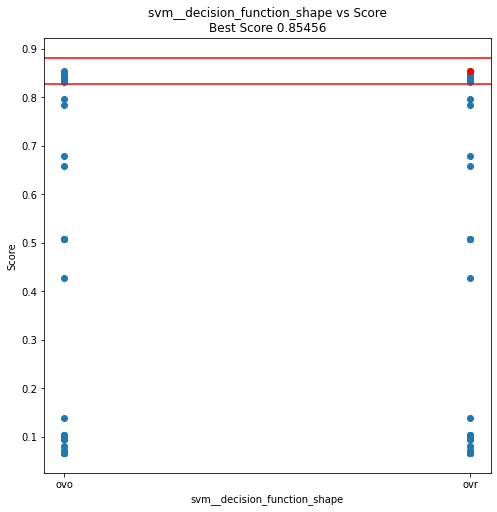

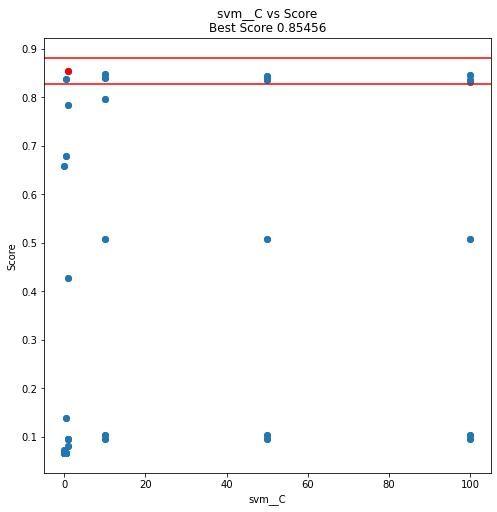

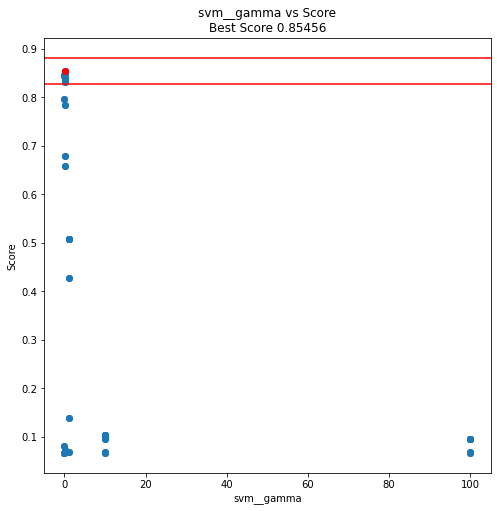

In [119]:
GridSearch_table_plot(grid, param_list=["svm__decision_function_shape","svm__C","svm__gamma"],negative=False)


In [120]:
print(grid.best_params_)
model=grid.best_estimator_
model.fit(train_x,train_y)
y_pred = model.predict(test_x)
test_valutation=valutate_test(test_y,y_pred)
dict_valutazioni['svm']={"test":test_valutation}
print("SVM rbf")
print( f"Accuracy: {test_valutation['Accuracy']}")
print( f"Macro f1: {test_valutation['f1']}")
print(f"Confusion Matrix:\n {test_valutation['Confusion Matrix']}")

{'reduce_dim': 'passthrough', 'svm__C': 1, 'svm__decision_function_shape': 'ovo', 'svm__gamma': 0.1}
SVM rbf
Accuracy: 0.8724584103512015
Macro f1: 0.8571797468412724
Confusion Matrix:
 [[143   0   1   3   8   0   4]
 [  2  31   0   0   9   0   4]
 [  0   0  40   0   1   2   1]
 [  4   0   1  85   2   0   1]
 [  6   3   1   0  54   0   1]
 [  3   0   0   0   0  79   1]
 [  4   1   0   2   4   0  40]]


## neural networks con embeddings ricalcolate da GAE

In [123]:
class modello(torch.nn.Module):
    def __init__(self,n_feature=1433,n_layers=0,dim_hidden_layers=300,activation=F.relu,dropout=0.2):
        super().__init__()
        
        self.dropout = torch.nn.Dropout(dropout)
        self.dense_layers=torch.nn.ModuleList([torch.nn.Linear(dim_hidden_layers, dim_hidden_layers) for i in range(n_layers)])
        self.activation=activation
        self.n_layers=n_layers
        self.lin_in = torch.nn.Linear(n_feature, dim_hidden_layers)
        self.lin_out = torch.nn.Linear(dim_hidden_layers, 7)
    
    def forward(self, data):
        x = data.x
        x = self.lin_in(x)
        x = self.activation(x)
        x=  self.dropout(x)
        for i in range(self.n_layers):
            x = self.dense_layers[i](x)
            x = self.activation(x)
            x=  self.dropout(x)
        x = self.lin_out(x)
        return F.log_softmax(x, dim=1)


import pandas as pd
from sklearn.model_selection import ParameterGrid

preprocessing=[ 
                {"reduce_dim": ["passthrough"]}]

parametri_modello = {
    'n_layers':[0,1,2,4,5],
    'dim_hidden_layers':[50,150,300,1000],
    'activation':[ torch.relu ,torch.sigmoid,torch.tanh],
    'dropout':[0,0.2,0.3,0.5]
}

parametri_training={
    "epochs":[10,20,30,50,100],
    "optimizer":[torch.optim.Adam],
    "loss":[F.nll_loss]
}

x=embeddings_auto_encoders.cpu().detach().numpy()
data.x=torch.from_numpy(x).type(torch.float32)


param=gridSearch( cv=5,dataset=data,
            modello=modello,
            preprocessing=preprocessing,
            parametri_training=parametri_training,
            parametri_modello=parametri_modello)
param.to_pickle("neuralnet_emb_ricalcolate.pkl")


1000


epochs                                       loss  \
1146     100  <function nll_loss at 0x00000271C256E430>   
1156     100  <function nll_loss at 0x00000271C256E430>   
937       50  <function nll_loss at 0x00000271C256E430>   
921       50  <function nll_loss at 0x00000271C256E430>   
1015     100  <function nll_loss at 0x00000271C256E430>   
...      ...                                        ...   
467       20  <function nll_loss at 0x00000271C256E430>   
1131     100  <function nll_loss at 0x00000271C256E430>   
1145     100  <function nll_loss at 0x00000271C256E430>   
712       30  <function nll_loss at 0x00000271C256E430>   
928       50  <function nll_loss at 0x00000271C256E430>   

                            optimizer  \
1146  <class 'torch.optim.adam.Adam'>   
1156  <class 'torch.optim.adam.Adam'>   
937   <class 'torch.optim.adam.Adam'>   
921   <class 'torch.optim.adam.Adam'>   
1015  <class 'torch.optim.adam.Adam'>   
...                               ...   
467   <class 'torch.optim.adam.Adam'>   
1131  <class 'torch.optim.adam.Adam'>   
1145  <class 'torch.optim.adam.Adam'>   
712   <class 'torch.optim.adam.Adam'>   
928   <class 'torch.optim.adam.Adam'>   

                                             activation  dim_hidden_layers  \
1146  <built-in method tanh of type object at 0x0000...                150   
1156  <built-in method tanh of type object at 0x0000...                150   
937   <built-in method tanh of type object at 0x0000...                300   
921   <built-in method tanh of type object at 0x0000...                300   
1015  <built-in method relu of type object at 0x0000...                300   
...                                                 ...                ...   
467   <built-in method tanh of type object at 0x0000...               1000   
1131  <built-in method tanh of type object at 0x0000...                 50   
1145  <built-in method tanh of type object at 0x0000...                150   
712   <built-in method tanh of type object at 0x0000...               1000   
928   <built-in method tanh of type object at 0x0000...                300   

      dropout  n_layers  n_feature  z_mean_test_score  z_std_test_score  \
1146      0.2         1       1000           0.855717          0.019260   
1156      0.5         1       1000           0.855066          0.019028   
937       0.5         2       1000           0.854958          0.026378   
921       0.0         1       1000           0.853836          0.021429   
1015      0.5         0       1000           0.851651          0.021300   
...       ...       ...        ...                ...               ...   
467       0.2         2       1000           0.843023          0.022222   
1131      0.3         1       1000           0.843016          0.018476   
1145      0.2         0       1000           0.842618          0.024756   
712       0.3         2       1000           0.842570          0.012947   
928       0.2         4       1000           0.842284          0.029366   

      z_mean_train_score  z_std_train_score  
1146            0.960116           0.004731  
1156            0.950524           0.005299  
937             0.941195           0.004618  
921             0.934151           0.005473  
1015            0.938962           0.005354  
...                  ...                ...  
467             0.931676           0.006291  
1131            0.905928           0.006623  
1145            0.922477           0.003022  
712             0.964657           0.005038  
928             0.957892           0.007568  

[100 rows x 12 columns]

100
<built-in method tanh of type object at 0x00007FFBD212A590>
150
0.2
1


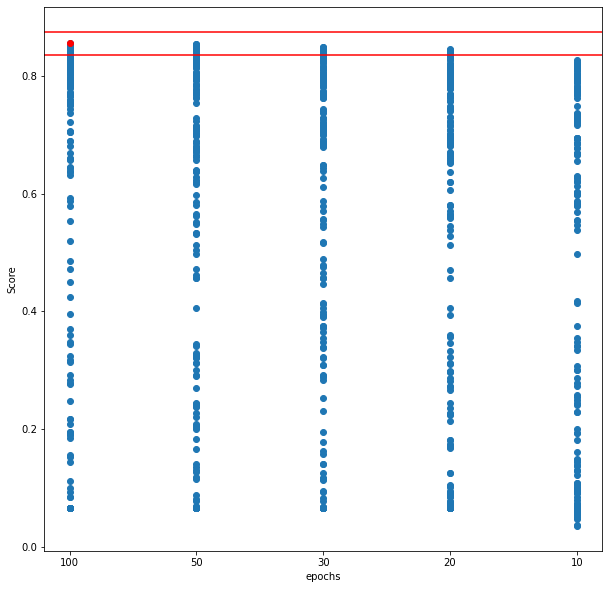

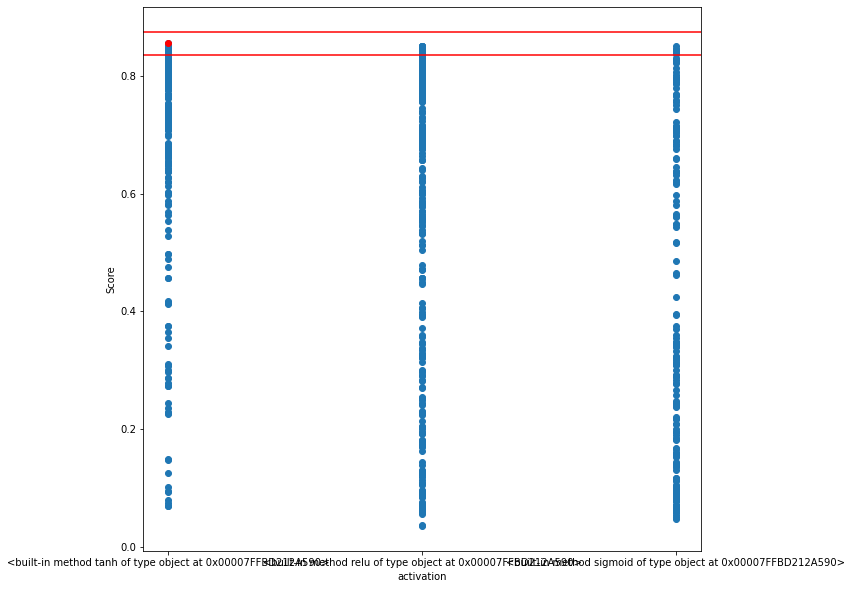

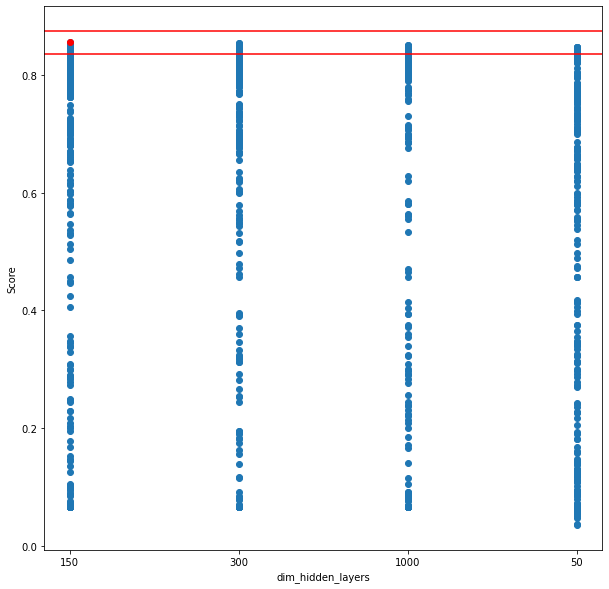

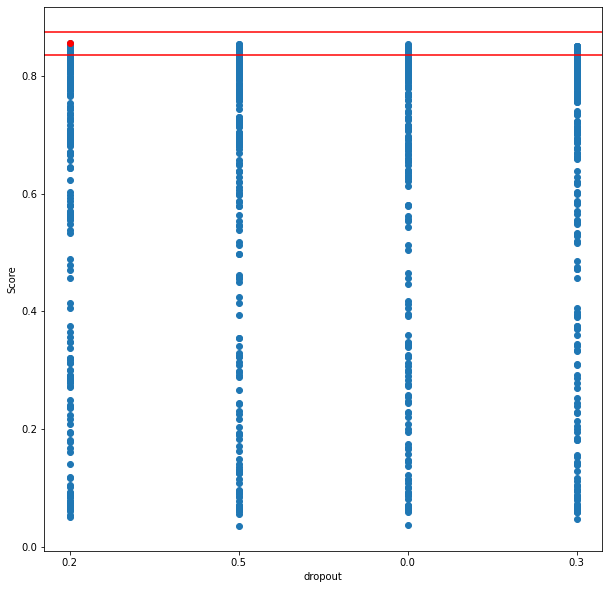

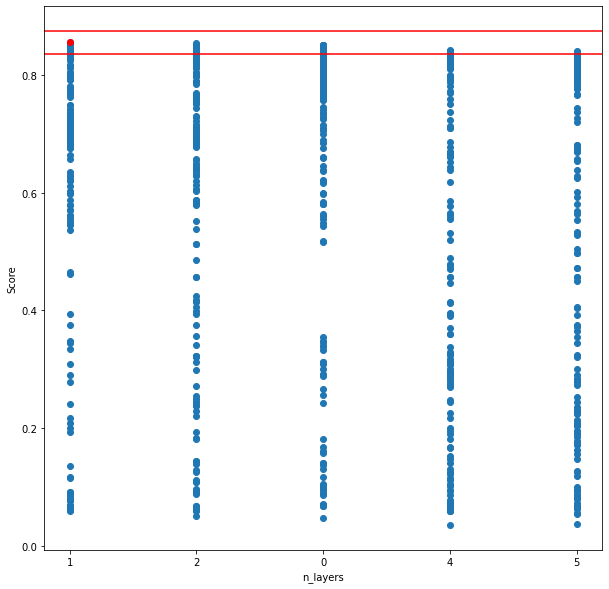

In [124]:
pa=param.sort_values(by=['z_mean_test_score'],ascending=False)

param_list=[	"epochs","activation"	,"dim_hidden_layers",	"dropout",	"n_layers"	]
scores_df=pa
display(pa.head(100))
best_row = scores_df.iloc[0, :]
best_mean = best_row['z_mean_test_score']
best_stdev = best_row['z_std_test_score']
for param_name in param_list:
    best_param =str( best_row[param_name])
    print(best_param)
    means = scores_df['z_mean_test_score']
    stds = scores_df['z_std_test_score']
    params = scores_df[param_name].astype(str)
    
    plt.figure(figsize=(10, 10))
    plt.plot(params, means,"o")

    plt.axhline(y=best_mean + best_stdev, color='red')
    plt.axhline(y=best_mean - best_stdev, color='red')
    plt.plot(best_param, best_mean, 'or')

    plt.xlabel(param_name)
    plt.ylabel('Score')
plt.show()






In [125]:

modello_migliore = {
    'n_layers':1,
    'dim_hidden_layers':150,
    'activation':torch.relu,
    'dropout':0.2,
    'n_feature':1000
}

training_migliore={
    "epochs":100,
    "optimizer":torch.optim.Adam,
    "loss":F.nll_loss
}


model=modello(**modello_migliore).to("cuda")
data.to('cuda')
optimizer=training_migliore['optimizer'](model.parameters())
model.train()
for _ in range(training_migliore['epochs']):
    optimizer.zero_grad()
    out = model(data)
    loss=training_migliore['loss'](out[data.train_mask],data.y[data.train_mask])
    loss.backward()
    optimizer.step()

model.eval()
pred = model(data)
pred=pred.argmax(dim=1)

f_test=metrics.f1_score(data.y[data.test_mask].cpu(), pred[data.test_mask].cpu() ,average='macro')
f_train=metrics.f1_score(data.y[data.train_mask].cpu(), pred[data.train_mask].cpu() ,average='macro')

accuracy_test=metrics.accuracy_score(data.y[data.test_mask].cpu(), pred[data.test_mask].cpu())
accuracy_train=metrics.accuracy_score(data.y[data.train_mask].cpu(), pred[data.train_mask].cpu() )
matr=metrics.confusion_matrix(data.y[data.test_mask].cpu(), pred[data.test_mask].cpu())

print(f"accuracy test: {accuracy_test}")

print(f"accuracy train: {accuracy_train}")
print(f"f1 test: {f_test}")
print(f"f1 train: {f_train}")

print(matr)

accuracy test: 0.8576709796672828
accuracy train: 0.95523765574527
f1 test: 0.8476371932691416
f1 train: 0.9480561647439332
[[139   0   1   4  10   0   5]
 [  1  36   0   0   5   0   4]
 [  1   0  37   1   2   2   1]
 [  5   0   1  81   3   0   3]
 [  6   1   1   1  54   0   2]
 [  4   0   1   0   0  78   0]
 [  4   1   1   2   2   2  39]]


# Risultati a confronto

|                                   |               |       | embedding gnn |    | embedding gae |    |
|---------------------              |---------------|-------|---------------|----|---------------|----|
|                                   | **Accuracy**       | **f1**    | **Accuracy**      | **f1** | **Accuracy**    | **f1** |
|**Logistic Regression**            |2* **0.754**        |2* **0.730** |0.878              |0.867|   **0.856**      |0.843|
|**LinearDiscriminantAnalysis**     | 0.721              | 0.702       |0.856              |0.842|     0.811        |0.792|
|**QuadraticDiscriminantAnalysis**  | 0.643              |0.595        |0.370              |0.400|     0.410        |0.429|
|**KNeighborsClassifier**           | 0.591              |  0.559      |**0.882**        |**0.871**|   0.847        |0.828|
|**DecisionTreeClassifier**         | 0.636              |0.610        |0.874              |0.867|     0.645        |0.627|
|**RandomForestClassifier**         |3* **0.750**        |3* **0.730** |0.880            |**0.870**|   0.845        |0.828|
|**svmLinear**                      | 0.730              |0.711        |**0.882**        |**0.872**|   0.845        |0.832|
|**svmPoly**                        | 0.684              |0.654        |0.880              |0.867|     0.854      |**0.844** |
|**svmRbf**                         | 0.732              |0.709        |**0.882**          |0.869|   **0.872**    |**0.857**|
|**neuralNetwork**                  | 0.745              | 0.714       |0.874              |0.865|   **0.858**    |**0.848**|
|**GraphNeuralNetwork**             |1* **0.887**        |1* **0.880** |                    |    |                  |    |